# Libraries

In [ ]:
!pip install haversine

In [ ]:
!pip install osmnx folium numpy matplotlib
# !git clone https://github.com/matteoboh/mobility_airpollution.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.1
    Uninstalling networkx-3.4.1:
      Successfully uninstalled networkx-3.4.1
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


In [ ]:
import os
os.sys.path.append('/content/drive/MyDrive/Colab Notebooks')
# os.sys.path.append('/content/mobility_airpollution/mobair')
# os.sys.path.append('/content/mobility_airpollution')

from datetime import timedelta
import geopandas as gpd

import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, Polygon

from datetime import datetime
import folium
import requests
import urllib.parse


In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dispersion

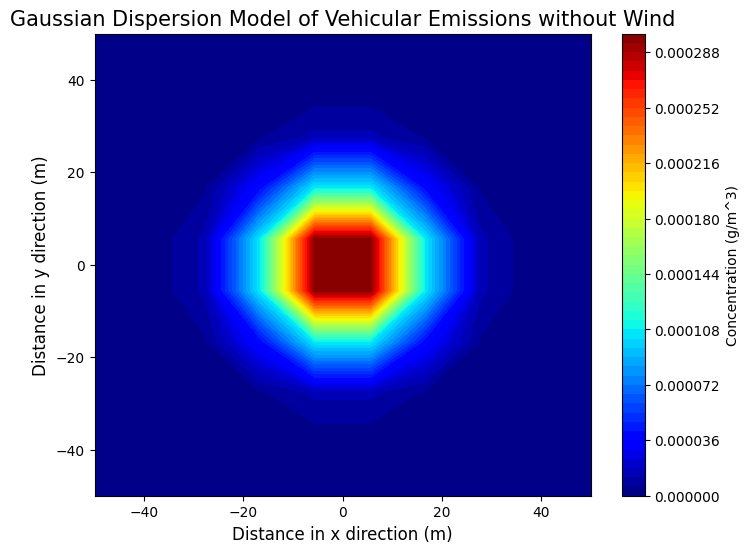

In [ ]:
import numpy as np

# Define parameters
Q = 1  # Emission rate (g/s)
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
time = 60  # Time in seconds for diffusion

# Define the domain
x = np.linspace(-50, 50, 10)  # Distance in x direction (m)
y = np.linspace(-50, 50, 10)  # Distance in y direction (m)
z = np.linspace(0, 100, 50)  # Height (m)

# Create a meshgrid for x, y, z
X, Y, Z = np.meshgrid(x, y, z)

# Calculate the dispersion standard deviations in x, y, z directions
sigma = np.sqrt(2 * D * time)

# Calculate concentration
C = (Q / (np.power((2 * np.pi * sigma**2), 1.5))) * np.exp(-(X**2 + Y**2 + (Z-H)**2) / (2 * sigma**2))

# Turner, D. B. (1964). A Diffusion Model for an Urban Area.
# Journal of Applied Meteorology and Climatology, 3(1), 83-91.

# Integrate over the entire volume for visualization in 2D plane at Z = H
C_xy = np.sum(C, axis=2)

# Plot the results
plt.figure(figsize=(8, 6))
cp = plt.contourf(X[:, :, 0], Y[:, :, 0], C_xy, levels=50, cmap='jet')
plt.colorbar(cp, label='Concentration (g/m^3)')
plt.title('Gaussian Dispersion Model of Vehicular Emissions without Wind', size=15)
plt.xlabel('Distance in x direction (m)', size=12)
plt.ylabel('Distance in y direction (m)', size=12)
plt.show()


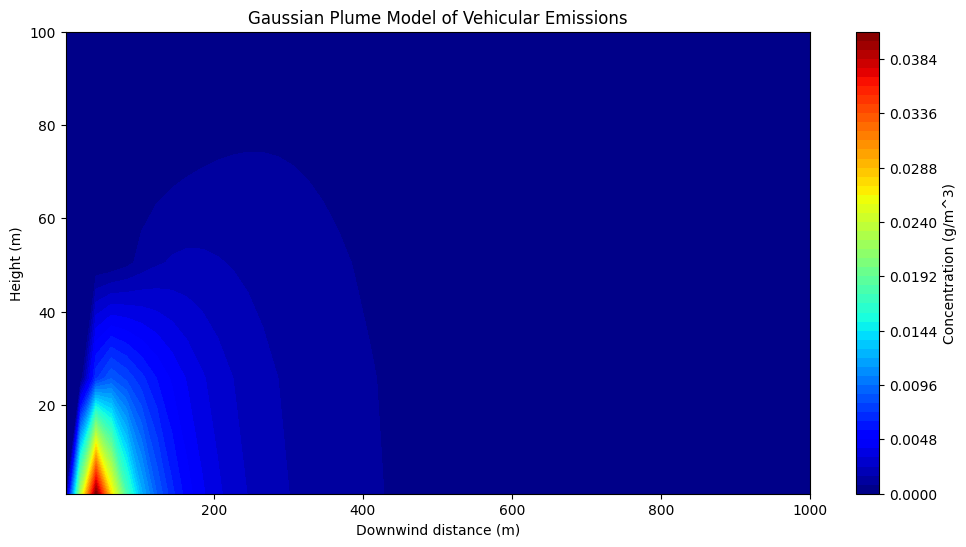

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
Q = 100  # Emission rate (g/s)
u = 5  # Wind speed (m/s)
H = 10  # Stack height (m)
y = 0  # Crosswind distance (m)

x = np.linspace(1, 1000, 50)  # Downwind distance (m)
z = np.linspace(1, 100, 5)  # Vertical distance (m)

# Define dispersion coefficients
def sigma_y(x):
    return 0.22 * x * (1 + 0.0001 * x)**-0.5

def sigma_z(x):
    return 0.20 * x

# Create meshgrid for z and x
X, Z = np.meshgrid(x, z)

# Calculate concentrations
C = (Q / (2 * np.pi * u * sigma_y(X) * sigma_z(X))) * \
    np.exp(-y**2 / (2 * sigma_y(X)**2)) * \
    (np.exp(-(Z-H)**2 / (2 * sigma_z(X)**2)) + np.exp(-(Z+H)**2 / (2 * sigma_z(X)**2)))

# Plot the results
plt.figure(figsize=(12, 6))
cp = plt.contourf(X, Z, C, levels=50, cmap='jet')
plt.colorbar(cp, label='Concentration (g/m^3)')
plt.title('Gaussian Plume Model of Vehicular Emissions')
plt.xlabel('Downwind distance (m)')
plt.ylabel('Height (m)')
plt.show()


In [ ]:
city = 'Pisa'
road_segments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/OSM_{}_raw_segment'.format(city))
road_segments.rename(columns={'s_id': 'start_point', 'e_id': 'end_point'}, inplace=True)
road_segments = road_segments.drop({'way_ids', 'bridge', 'maxspeed', 'lanes', 'inc_id'}, axis=1)
print(f"No. of road segments: {road_segments.shape[0]}")
road_segments.head()

No. of road segments: 67114


start_point   end_point      s_lon      s_lat      e_lon      e_lat  \
0     31770729  7257369708  10.401684  43.715550  10.401716  43.715600   
1   7257369708    31770729  10.401716  43.715600  10.401684  43.715550   
2     33681447  3044082602  10.394977  43.715603  10.395148  43.715668   
3   3044082602  6957424170  10.395148  43.715668  10.395325  43.715735   
4   6957424170  9986411817  10.395325  43.715735  10.395431  43.715778   

       c_lon      c_lat  length  radian  ...  c-centrality  b-centrality  \
0  10.401700  43.715575   6.135   0.996  ...      0.004264      0.031864   
1  10.401700  43.715575   6.135   4.137  ...      0.004259      0.001932   
2  10.395062  43.715635  15.567   0.365  ...      0.004130      0.027840   
3  10.395236  43.715702  16.040   0.365  ...      0.004121      0.027825   
4  10.395378  43.715756   9.738   0.380  ...      0.004112      0.027813   

   h-centrality  degree  cultural  education  food  health  service  \
0    316.680514     4.0       0.0        0.0   0.0     0.0      0.0   
1    315.933972     4.0       0.0        0.0   0.0     0.0      0.0   
2    319.862041     6.0       0.0        0.0   0.0     0.0      0.0   
3    315.973054     4.0       0.0        0.0   0.0     0.0      0.0   
4    313.690965     4.0       0.0        0.0   0.0     0.0      0.0   

   transportation  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 21 columns]

In [ ]:
embs_n_co2m = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/{}_embs_n_co2m.csv'.format(city.lower()))
# embs_n_co2m = embs_n_co2m[embs_n_co2m['CO_2/m']<=17.2]
carbon_per_meter = embs_n_co2m[['road_link', 'start_point', 'end_point', 'CO_2/m']]
# carbon_per_meter = embs_n_co2m
print(f"No. of road segments: {carbon_per_meter.shape[0]}")
carbon_per_meter.head()

No. of road segments: 30741


road_link  start_point   end_point    CO_2/m
0    (7257369708, 31770729, 0)   7257369708    31770729  0.266387
1    (33681447, 3044082602, 0)     33681447  3044082602  0.529803
2  (3044082602, 6957424170, 0)   3044082602  6957424170  0.239792
3  (6957424170, 9986411817, 0)   6957424170  9986411817  0.190269
4   (213417023, 9986411817, 0)    213417023  9986411817  0.351395

In [ ]:
roads_with_emissions = pd.merge(road_segments, carbon_per_meter, on=['start_point', 'end_point'])
print(f"No. of road segments: {roads_with_emissions.shape[0]}")
roads_with_emissions.head(1)

No. of road segments: 30741


start_point  end_point      s_lon    s_lat      e_lon     e_lat    c_lon  \
0   7257369708   31770729  10.401716  43.7156  10.401684  43.71555  10.4017   

       c_lat  length  radian  ...  h-centrality  degree  cultural  education  \
0  43.715575   6.135   4.137  ...    315.933972     4.0       0.0        0.0   

   food  health  service  transportation                  road_link    CO_2/m  
0   0.0     0.0      0.0             0.0  (7257369708, 31770729, 0)  0.266387  

[1 rows x 23 columns]

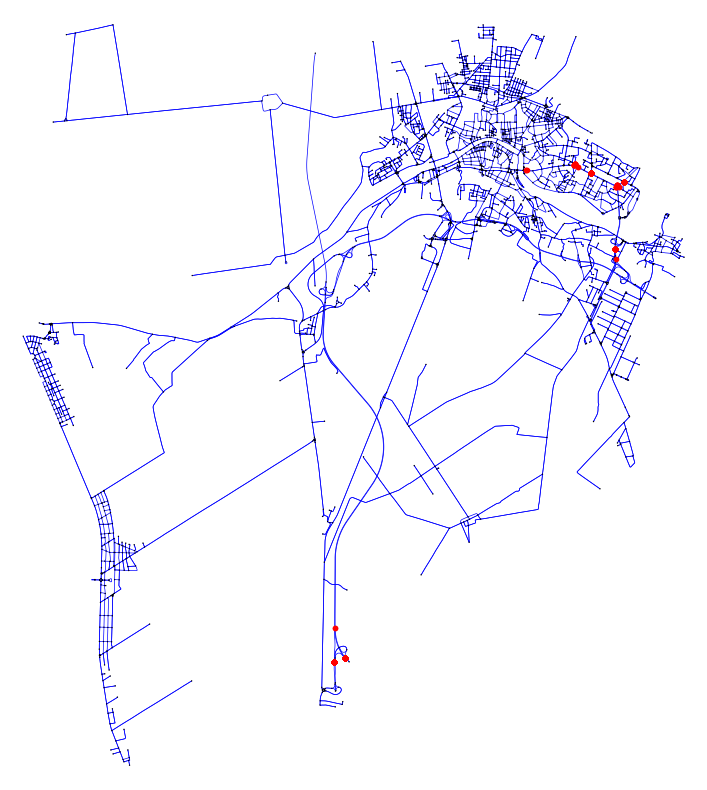

In [ ]:
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
import geopandas as gpd

# Example emissions data (use real road IDs if available)
emissions_data = pd.DataFrame({
    'road_id': [list(G.edges)[i] for i in range(10)],  # Example road IDs, take the first 10 roads
    'emission_amount': np.random.randint(500, 2000, size=10),  # Random emissions in grams/minute
    'road_length': [G.edges[list(G.edges)[i]]['length'] for i in range(10)]  # Road lengths in meters from the graph
})

# Function to create emission points along a road
def create_emission_points(road_id, road_length, emissions_per_minute, interval=10):
    start_node, end_node, _ = road_id
    start_coords = (G.nodes[start_node]['x'], G.nodes[start_node]['y'])
    end_coords = (G.nodes[end_node]['x'], G.nodes[end_node]['y'])
    line = LineString([start_coords, end_coords])
    num_points = max(int(road_length / interval), 1)  # At least one emission point per 10 meters
    points = [line.interpolate(i * interval) for i in range(num_points)]
    emissions_per_point_per_minute = emissions_per_minute / num_points
    return points, emissions_per_point_per_minute

# Create emission points for all roads
emission_points = []
emission_amounts = []

for _, row in emissions_data.iterrows():
    points, emissions_per_point_per_minute = create_emission_points(row['road_id'], row['road_length'], row['emission_amount'])
    emission_points.extend(points)
    emission_amounts.extend([emissions_per_point_per_minute] * len(points))

# Plot emission points on the road network
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, node_color='black', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Plot emission points
for point in emission_points:
    ax.plot(point.x, point.y, 'ro', markersize=3)

plt.show()


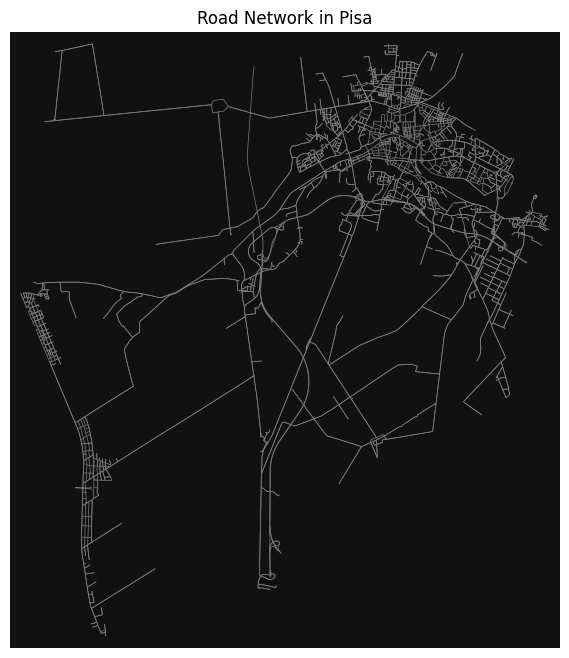

In [ ]:
import osmnx as ox

# Load the road network for Pisa
G = ox.graph_from_place('Pisa, Italy', network_type='drive')

# Plot the road network without nodes
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='grey', edge_linewidth=0.5, node_color='none')

plt.title('Road Network in Pisa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [ ]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the road network for Pisa
G = ox.graph_from_place('Pisa, Italy', network_type='drive')

# Specify roads with emissions (let's assume 100 roads)
roads_with_emissions_indices = np.random.choice(len(edges_list), size=100, replace=False)

# Simulate emissions along the specified roads
emission_points = []
for idx in roads_with_emissions_indices:
    edge = edges_list[idx]
    source, target = edge
    route = nx.shortest_path(G, source=source, target=target)  # Generate route
    route_gdf = ox.routing.route_to_gdf(G, route)
    road_geom = route_gdf['geometry'].iloc[0]  # Get the geometry of the first edge in the route
    road_length = route_gdf['length'].iloc[0]  # Get the length of the first edge in the route
    num_points = max(int(road_length), 1)  # At least one emission point per meter
    points = [road_geom.interpolate(i / num_points, normalized=True) for i in range(num_points)]
    emission_points.extend(points)

# Define dispersion parameters
sigma_y = 10  # Horizontal dispersion coefficient (m)
sigma_z = 10  # Vertical dispersion coefficient (m)
H = 1.5  # Emission height (m), assuming ground level emissions

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Get the bounding box of Pisa
bbox = ox.bbox_from_place('Pisa, Italy')

# Calculate concentration at each grid point
x_coords = np.linspace(bbox[0], bbox[2], num=100)
y_coords = np.linspace(bbox[1], bbox[3], num=100)
concentration_map = np.zeros((len(y_coords), len(x_coords)))

for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        total_concentration = 0
        for point in emission_points:
            distance = point.distance(Point(x, y))
            concentration = gaussian_concentration_simplified(1, sigma_y, sigma_z, distance, 0, H)
            total_concentration += concentration
        concentration_map[j, i] = total_concentration

# Plot the road network
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='grey', edge_linewidth=0.5)

# Overlay the concentration map on the road network
plt.imshow(concentration_map, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()), origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='CO2 Concentration (g/m³)')

plt.title('CO2 Dispersion in Pisa after 1 Hour of Emission from Specified Roads')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


AttributeError: module 'osmnx' has no attribute 'bbox_from_place'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point

# Define a function to calculate dispersion without wind
def calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range):
    x = np.linspace(*x_range, grid_size)  # Distance in x direction (m)
    y = np.linspace(*y_range, grid_size)  # Distance in y direction (m)
    X, Y = np.meshgrid(x, y)
    sigma = np.sqrt(2 * D * time)
    C = (Q / (2 * np.pi * sigma**2)) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return X, Y, C

# Load road network shapefile (replace 'your_shapefile.shp' with the actual file)
# Assuming we have a GeoDataFrame called `roads`
roads = gpd.read_file('your_shapefile.shp')

# Define emission sources (for simplicity, use a few points)
# Replace these with actual emission source coordinates
emission_sources = [
    Point(-73.985130, 40.758896),  # Example: Times Square, NYC
    Point(-73.985708, 40.758896),  # Nearby point
]

# Create a GeoDataFrame for emission sources
sources_gdf = gpd.GeoDataFrame(geometry=emission_sources, crs=roads.crs)

# Initialize map centered around the emission sources
m = folium.Map(location=[40.758896, -73.985130], zoom_start=15)

# Add road network to the map
folium.GeoJson(roads).add_to(m)

# Dispersion parameters
Q = 100  # Emission rate (g/s)
D = 1  # Diffusion coefficient (m^2/s)
H = 10  # Initial height of emission (m)
time = 3600  # Time in seconds for diffusion
grid_size = 100  # Grid size for dispersion calculation

# Calculate and plot dispersion for each source
for source in emission_sources:
    x_range = (source.x - 500, source.x + 500)
    y_range = (source.y - 500, source.y + 500)
    X, Y, C = calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range)

    # Create a folium feature group for the dispersion layer
    dispersion_layer = folium.FeatureGroup(name=f'Dispersion around {source}')

    # Normalize concentration for coloring
    C_norm = (C - np.min(C)) / (np.max(C) - np.min(C))

    for i in range(grid_size):
        for j in range(grid_size):
            if C[i, j] > 0:
                color = plt.cm.viridis(C_norm[i, j])
                folium.Circle(
                    location=[Y[i, j], X[i, j]],
                    radius=1,  # Adjust the radius for better visualization
                    color=plt.colors.rgb2hex(color),
                    fill=True,
                    fill_opacity=0.5
                ).add_to(dispersion_layer)

    dispersion_layer.add_to(m)

# Add emission sources to the map
for source in emission_sources:
    folium.Marker([source.y, source.x], popup='Emission Source').add_to(m)

# Add layer control and save the map
folium.LayerControl().add_to(m)
m.save('dispersion_map.html')


In [ ]:
import numpy as np
import folium
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import webbrowser

# Define a function to calculate dispersion without wind
def calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range):
    x = np.linspace(*x_range, grid_size)  # Distance in x direction (m)
    y = np.linspace(*y_range, grid_size)  # Distance in y direction (m)
    X, Y = np.meshgrid(x, y)
    sigma = np.sqrt(2 * D * time)
    C = (Q / (2 * np.pi * sigma**2)) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return X, Y, C

# Define the location and network type
location = 'Manhattan, New York, USA'
network_type = 'drive'

# Download the road network using osmnx
print("Downloading road network...")
G = ox.graph_from_place(location, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")

# Define emission sources (for simplicity, use a few points)
# Replace these with actual emission source coordinates
emission_sources = [
    Point(-73.985130, 40.758896),  # Example: Times Square, NYC
    Point(-73.985708, 40.758896),  # Nearby point
]
print(f"Emission sources: {emission_sources}")

# Initialize map centered around the emission sources
m = folium.Map(location=[40.758896, -73.985130], zoom_start=15)

# Add road network to the map
print("Adding road network to the map...")
folium.GeoJson(edges).add_to(m)

# Dispersion parameters
Q = 100  # Emission rate (g/s)
D = 1  # Diffusion coefficient (m^2/s)
H = 10  # Initial height of emission (m)
time = 3600  # Time in seconds for diffusion
grid_size = 100  # Grid size for dispersion calculation

# Calculate and plot dispersion for each source
print("Calculating and plotting dispersion...")
for source in emission_sources:
    x_range = (source.x - 0.005, source.x + 0.005)
    y_range = (source.y - 0.005, source.y + 0.005)
    X, Y, C = calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range)

    # Create a folium feature group for the dispersion layer
    dispersion_layer = folium.FeatureGroup(name=f'Dispersion around {source}')

    # Normalize concentration for coloring
    C_norm = (C - np.min(C)) / (np.max(C) - np.min(C))

    for i in range(grid_size):
        for j in range(grid_size):
            if C[i, j] > 0:
                color = plt.cm.viridis(C_norm[i, j])
                folium.Circle(
                    location=[Y[i, j], X[i, j]],
                    radius=10,  # Adjust the radius for better visualization
                    color=mcolors.rgb2hex(color),
                    fill=True,
                    fill_opacity=0.5
                ).add_to(dispersion_layer)

    dispersion_layer.add_to(m)
print("Dispersion plotted.")

# Add emission sources to the map
print("Adding emission sources to the map...")
for source in emission_sources:
    folium.Marker([source.y, source.x], popup='Emission Source').add_to(m)

# Add layer control and save the map
print("Adding layer control and saving the map...")
folium.LayerControl().add_to(m)
map_file = 'dispersion_map.html'
m.save(map_file)

# Open the saved map file in a web browser
print(f"Opening {map_file} in web browser...")
webbrowser.open(map_file)


Road network downloaded.
Emission sources: [<POINT (-73.985 40.759)>, <POINT (-73.986 40.759)>]
Adding road network to the map...
Calculating and plotting dispersion...
Dispersion plotted.
Adding emission sources to the map...
Adding layer control and saving the map...
Map file dispersion_map.html created successfully.
Failed to open the web browser automatically. Please open the file manually.


Road network downloaded.
Emission sources: [<POINT (-73.985 40.759)>, <POINT (-73.986 40.759)>]
Calculating and plotting dispersion...
Adding road network to the plot...
Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.


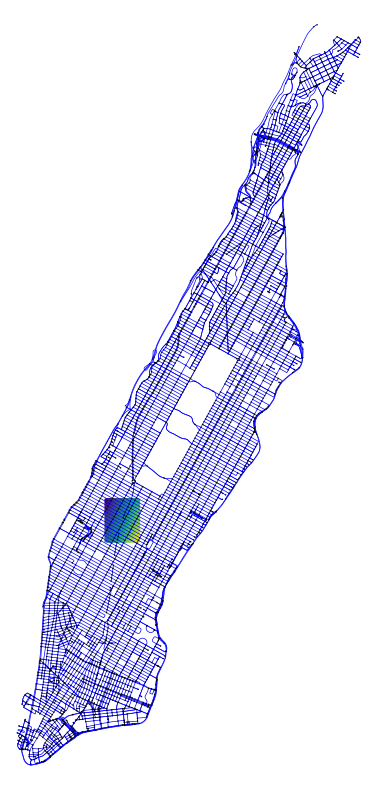

In [ ]:
import os
import numpy as np
import folium
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point

# Define a function to calculate dispersion without wind
def calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range):
    x = np.linspace(*x_range, grid_size)  # Distance in x direction (m)
    y = np.linspace(*y_range, grid_size)  # Distance in y direction (m)
    X, Y = np.meshgrid(x, y)
    sigma = np.sqrt(2 * D * time)
    C = (Q / (2 * np.pi * sigma**2)) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return X, Y, C

# Define the location and network type
location = 'Manhattan, New York, USA'
network_type = 'drive'

# Download the road network using osmnx
print("Downloading road network...")
G = ox.graph_from_place(location, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")

# Define emission sources (for simplicity, use a few points)
emission_sources = [
    Point(-73.985130, 40.758896),  # Example: Times Square, NYC
    Point(-73.985708, 40.758896),  # Nearby point
]
print(f"Emission sources: {emission_sources}")

# Dispersion parameters
Q = 100  # Emission rate (g/s) (Reference: [EPA](https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle))
D = 1  # Diffusion coefficient (m^2/s) (Reference: [Atmospheric Environment](https://www.sciencedirect.com/science/article/pii/S1352231019302091))
H = 1.5  # Initial height of emission (m) (Reference: [National Renewable Energy Laboratory](https://www.nrel.gov/docs/fy17osti/68394.pdf))
time = 31_536_000  # Time in seconds for a year (Reference: [ISO](https://www.iso.org/standard/68498.html))
grid_size = 400  # Grid size for dispersion calculation

# Calculate and plot dispersion for each source
print("Calculating and plotting dispersion...")
fig, ax = plt.subplots(figsize=(10, 10))
for source in emission_sources:
    x_range = (source.x - 0.005, source.x + 0.005)
    y_range = (source.y - 0.005, source.y + 0.005)
    X, Y, C = calculate_dispersion(Q, D, H, time, grid_size, x_range, y_range)

    # Normalize concentration for coloring
    C_norm = (C - np.min(C)) / (np.max(C) - np.min(C))

    # Plot the dispersion
    for i in range(grid_size):
        for j in range(grid_size):
            if C[i, j] > 0:
                color = plt.cm.viridis(C_norm[i, j])
                ax.add_patch(plt.Circle((X[i, j], Y[i, j]), radius=0.0001,
                                        color=mcolors.rgb2hex(color),
                                        alpha=0.2))  # Increased transparency

# Plot the road network
print("Adding road network to the plot...")
ox.plot_graph(G, ax=ax, node_color='black', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('dispersion_map.png', dpi=300)
plt.savefig('dispersion_map.pdf', dpi=300)
print("Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.")

# Show the plot
plt.show()


Road network downloaded.
Emission sources: [<POINT (-73.985 40.759)>, <POINT (-73.986 40.759)>]
Calculating and plotting dispersion...
Adding road network to the plot...
Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.


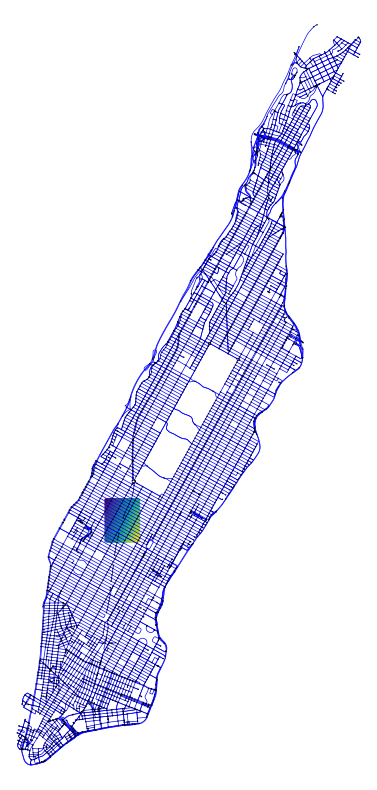

In [ ]:
# changed emission function

import os
import numpy as np
import folium
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Manhattan, New York, USA'
network_type = 'drive'

# Download the road network using osmnx
print("Downloading road network...")
G = ox.graph_from_place(location, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")

# Define emission sources (for simplicity, use a few points)
emission_sources = [
    Point(-73.985130, 40.758896),  # Example: Times Square, NYC
    Point(-73.985708, 40.758896),  # Nearby point
]
print(f"Emission sources: {emission_sources}")

# Dispersion parameters
Q_per_minute = 100  # Emission rate (g/minute)
Q = Q_per_minute * 60  # Convert to g/hour for continuous emission
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
time = 3600  # Time in seconds for an hour
sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
sigma_z = np.sqrt(2 * D * time)  # Vertical dispersion coefficient (m)
grid_size = 100  # Grid size for dispersion calculation

# Calculate and plot dispersion for each source
print("Calculating and plotting dispersion...")
fig, ax = plt.subplots(figsize=(10, 10))
for source in emission_sources:
    x_range = (source.x - 0.005, source.x + 0.005)
    y_range = (source.y - 0.005, source.y + 0.005)
    x = np.linspace(*x_range, grid_size)  # Distance in x direction (m)
    y = np.linspace(*y_range, grid_size)  # Distance in y direction (m)
    X, Y = np.meshgrid(x, y)
    C = gaussian_concentration_simplified(Q, sigma_y, sigma_z, X, Y, H)

    # Normalize concentration for coloring
    C_norm = (C - np.min(C)) / (np.max(C) - np.min(C))

    # Plot the dispersion
    for i in range(grid_size):
        for j in range(grid_size):
            if C[i, j] > 0:
                color = plt.cm.viridis(C_norm[i, j])
                ax.add_patch(plt.Circle((X[i, j], Y[i, j]), radius=0.0001,
                                        color=mcolors.rgb2hex(color),
                                        alpha=0.2))  # Increased transparency

# Plot the road network
print("Adding road network to the plot...")
ox.plot_graph(G, ax=ax, node_color='black', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('dispersion_map.png', dpi=300)
plt.savefig('dispersion_map.pdf', dpi=300)
print("Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.")

# Show the plot
plt.show()


Road network downloaded.
Size of concentration grid: (181, 0)
Adding road network to the plot...
Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.


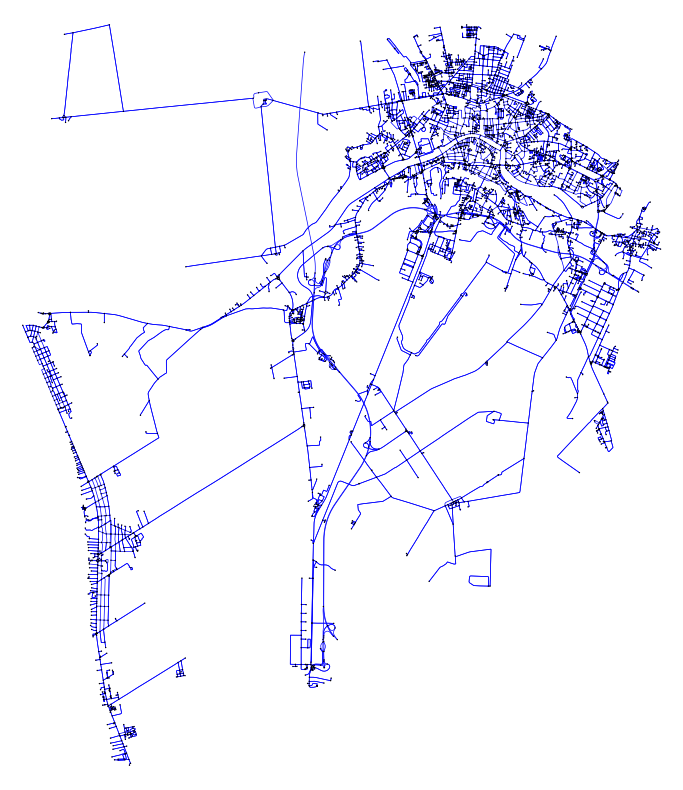

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Download the road network using osmnx
print("Downloading road network...")
G = ox.graph_from_place(location, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")

# Define grid parameters
cell_size = 10  # Cell size in meters
central_area = (43.716, 10.372, 43.704, 10.390)  # Specify the central area of Pisa (2x2 km)
xmin, ymin, xmax, ymax = central_area

# Create the grid
x_grid = np.arange(xmin, xmax, cell_size/100000)  # Convert meters to degrees approximately
y_grid = np.arange(ymin, ymax, cell_size/100000)
X, Y = np.meshgrid(x_grid, y_grid)

# Define emission sources randomly within the area
num_emission_sources = 200
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]

# Dispersion parameters
Q_per_minute = 100  # Emission rate (g/minute)
Q = Q_per_minute * 60  # Convert to g/hour for continuous emission
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
time = 3600  # Time in seconds for an hour
sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
sigma_z = np.sqrt(2 * D * time)  # Vertical dispersion coefficient (m)

# Calculate the concentration for each cell in the grid
concentration_grid = np.zeros_like(X)

for source in emission_sources:
    source_x = source.x
    source_y = source.y
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            distance_y = Y[j, i] - source_y
            distance_x = X[j, i] - source_x
            C = gaussian_concentration_simplified(Q, sigma_y, sigma_z, distance_x, distance_y, H)
            concentration_grid[j, i] += C

# Print the size of the concentration grid for debugging
print("Size of concentration grid:", concentration_grid.shape)

# Normalize concentration for coloring
if concentration_grid.size > 0:
    C_norm = (concentration_grid - np.min(concentration_grid)) / (np.max(concentration_grid) - np.min(concentration_grid))
else:
    C_norm = concentration_grid

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        if concentration_grid[j, i] > 0:
            color = plt.cm.viridis(C_norm[j, i])
            ax.add_patch(plt.Rectangle((X[j, i], Y[j, i]), cell_size/100000, cell_size/100000,
                                       color=mcolors.rgb2hex(color), alpha=0.5))

# Plot the road network
print("Adding road network to the plot...")
ox.plot_graph(G, ax=ax, node_color='black', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('dispersion_map.png', dpi=300)
plt.savefig('dispersion_map.pdf', dpi=300)
print("Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.")

# Show the plot
plt.show()


Road network downloaded.
Number of nodes: 1631
Number of edges: 2660
Initial concentration grid shape: (121, 181)
Final concentration grid shape: (121, 181)
Concentration grid shape: (121, 181)
Min concentration: 53.04335842436163
Max concentration: 53.043358870474464
Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.


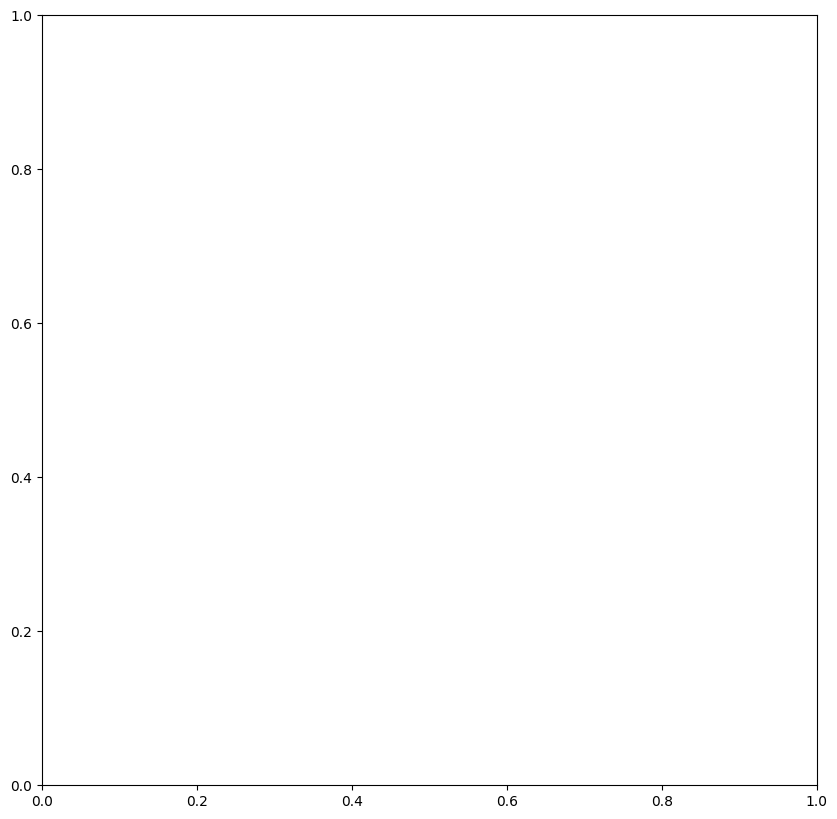

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the network type
network_type = 'drive_service'

# Define grid parameters
cell_size = 10  # Cell size in meters
central_area = (43.716, 43.704, 10.390, 10.372)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Filter the road network to the central area
print("Downloading road network...")
G = ox.graph_from_bbox(bbox=central_area, simplify=False, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")
print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

# Create the grid
x_grid = np.arange(xmin, xmax, cell_size/100000)
y_grid = np.arange(ymin, ymax, cell_size/100000)
X, Y = np.meshgrid(x_grid, y_grid)

# Define emission sources randomly within the area
num_emission_sources = 200
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]

# Dispersion parameters
Q_per_minute = 100  # Emission rate (g/minute)
Q = Q_per_minute * 60  # Convert to g/hour for continuous emission
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
time = 3600  # Time in seconds for an hour
sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
sigma_z = np.sqrt(2 * D * time)  # Vertical dispersion coefficient (m)

# Calculate the concentration for each cell in the grid
concentration_grid = np.zeros_like(X)

print("Initial concentration grid shape:", concentration_grid.shape)

for source in emission_sources:
    source_x = source.x
    source_y = source.y
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            distance_y = Y[j, i] - source_y
            distance_x = X[j, i] - source_x
            C = gaussian_concentration_simplified(Q, sigma_y, sigma_z, distance_x, distance_y, H)
            concentration_grid[j, i] += C

print("Final concentration grid shape:", concentration_grid.shape)

# Normalize concentration for coloring
if concentration_grid.size > 0:
    C_norm = (concentration_grid - np.min(concentration_grid)) / (np.max(concentration_grid) - np.min(concentration_grid))
else:
    C_norm = concentration_grid

print("Concentration grid shape:", concentration_grid.shape)
print("Min concentration:", np.min(concentration_grid))
print("Max concentration:", np.max(concentration_grid))

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        if concentration_grid[j, i] > 0:
            color = plt.cm.viridis(C_norm[j, i])
            ax.add_patch(plt.Rectangle((X[j, i], Y[j, i]), cell_size, cell_size,
                                       color=mcolors.rgb2hex(color), alpha=0.5))

# Save the figure
plt.savefig('dispersion_map.png', dpi=300)
plt.savefig('dispersion_map.pdf', dpi=300)
print("Figure saved as 'dispersion_map.png' and 'dispersion_map.pdf'.")

# Show the plot
plt.show()


Road network downloaded.
Number of nodes: 3888
Number of edges: 5742


<ipython-input-57-b8a637af2344>:109: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')


Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.


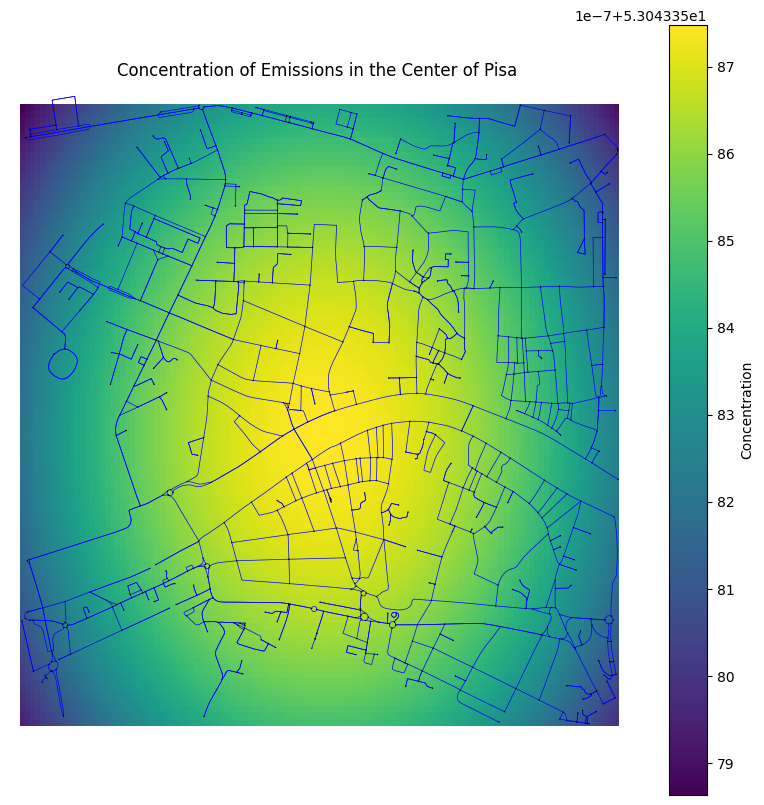

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 20  # Cell size in meters
central_area = (43.725, 43.707, 10.408, 10.384)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Filter the road network to the central area
print("Downloading road network...")
G = ox.graph_from_bbox(bbox=central_area, simplify=False, retain_all=True, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")
print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

# Create the grid
x_grid = np.arange(xmin, xmax, cell_size/100000)
y_grid = np.arange(ymin, ymax, cell_size/100000)
X, Y = np.meshgrid(x_grid, y_grid)

# Define emission sources randomly within the area
num_emission_sources = 200
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]

# Dispersion parameters
Q_per_minute = 100  # Emission rate (g/minute)
Q = Q_per_minute * 60  # Convert to g/hour for continuous emission
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
time = 3600  # Time in seconds for an hour
sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
sigma_z = np.sqrt(2 * D * time)  # Vertical dispersion coefficient (m)

# Calculate the concentration for each cell in the grid
concentration_grid = np.zeros_like(X)

for source in emission_sources:
    source_x = source.x
    source_y = source.y
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            distance_y = Y[j, i] - source_y
            distance_x = X[j, i] - source_x
            C = gaussian_concentration_simplified(Q, sigma_y, sigma_z, distance_x, distance_y, H)
            concentration_grid[j, i] += C

# Normalize concentration for coloring
if concentration_grid.size > 0:
    C_norm = (concentration_grid - np.min(concentration_grid)) / (np.max(concentration_grid) - np.min(concentration_grid))
else:
    C_norm = concentration_grid

# version 1
# # Plot the road network
# fig, ax = ox.plot_graph(G, node_color='black', bgcolor='w', node_size=0, edge_color='blue', edge_linewidth=0.5, show=False)

# # Plot the concentration map
# for i in range(len(x_grid)):
#     for j in range(len(y_grid)):
#         if concentration_grid[j, i] > 0:
#             color = plt.cm.viridis(C_norm[j, i])
#             ax.add_patch(plt.Rectangle((X[j, i], Y[j, i]), cell_size/100000, cell_size/100000,
#                                        color=mcolors.rgb2hex(color), alpha=0.1))



# version 2
# # Plot the results
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_facecolor('white')  # Set the background color to white
# for i in range(len(x_grid)):
#     for j in range(len(y_grid)):
#         if concentration_grid[j, i] > 0:
#             color = plt.cm.viridis(C_norm[j, i])
#             ax.add_patch(plt.Rectangle((X[j, i], Y[j, i]), cell_size, cell_size,
#                                        color=mcolors.rgb2hex(color), alpha=0.1))

# # Plot the road network
# ox.plot_graph(G, ax=ax, node_color='black', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)


# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa ')
plt.grid(True)

# Download and plot the road network
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')
ox.plot_graph(G, ax=plt.gca(), node_color='black', bgcolor='w', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)


# Save the figure
plt.savefig('road_and_concentration_map.png', dpi=300)
plt.savefig('road_and_concentration_map.pdf', dpi=300)
print("Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.")

# Show the plot
plt.show()


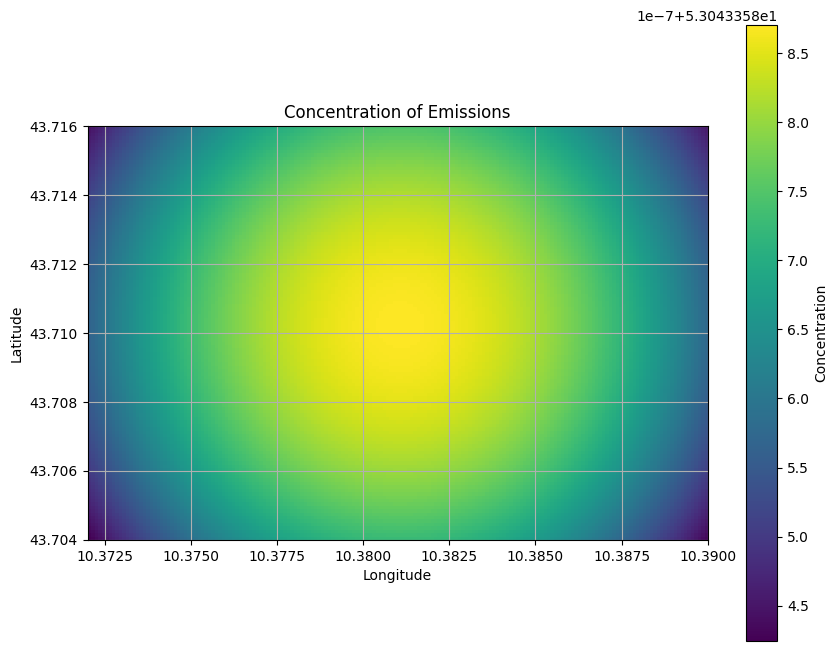

In [ ]:
# Plot the concentration grid
plt.figure(figsize=(10, 8))
plt.imshow(concentration_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration_simplified(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 20  # Cell size in meters
central_area = (43.725, 43.707, 10.408, 10.384)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Filter the road network to the central area
print("Downloading road network...")
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, simplify=False, retain_all=True, network_type=network_type)
nodes, edges = ox.graph_to_gdfs(G)
print("Road network downloaded.")
print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

In [ ]:
# Create the grid
x_grid = np.arange(xmin, xmax, cell_size/100000)
y_grid = np.arange(ymin, ymax, cell_size/100000)
X, Y = np.meshgrid(x_grid, y_grid)

# Define emission sources randomly within the area
num_emission_sources = 100
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]

# Dispersion parameters
Q_per_minute = 1  # Emission rate (g/minute)
D = 1  # Diffusion coefficient (m^2/s)
H = 1.5  # Initial height of emission (m)
total_time = 60  # Total time in minutes

# Initialize the concentration grid
concentration_grid = np.zeros_like(X)

# Simulate for each minute and accumulate the concentration
for minute in range(1, total_time + 1):
    time = minute * 60  # Convert time to seconds for each minute
    sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
    sigma_z = np.sqrt(2 * D * time)  # Vertical dispersion coefficient (m)

    for source in emission_sources:
        source_x = source.x
        source_y = source.y
        for i in range(len(x_grid)):
            for j in range(len(y_grid)):
                distance_y = Y[j, i] - source_y
                distance_x = X[j, i] - source_x
                C = gaussian_concentration_simplified(Q_per_minute, sigma_y, sigma_z, distance_x, distance_y, H)
                concentration_grid[j, i] += C


<ipython-input-3-4474cf2e9d92>:27: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, simplify=False, retain_all=True, network_type=network_type)


Road network downloaded.
Number of nodes: 3888
Number of edges: 5742
Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.


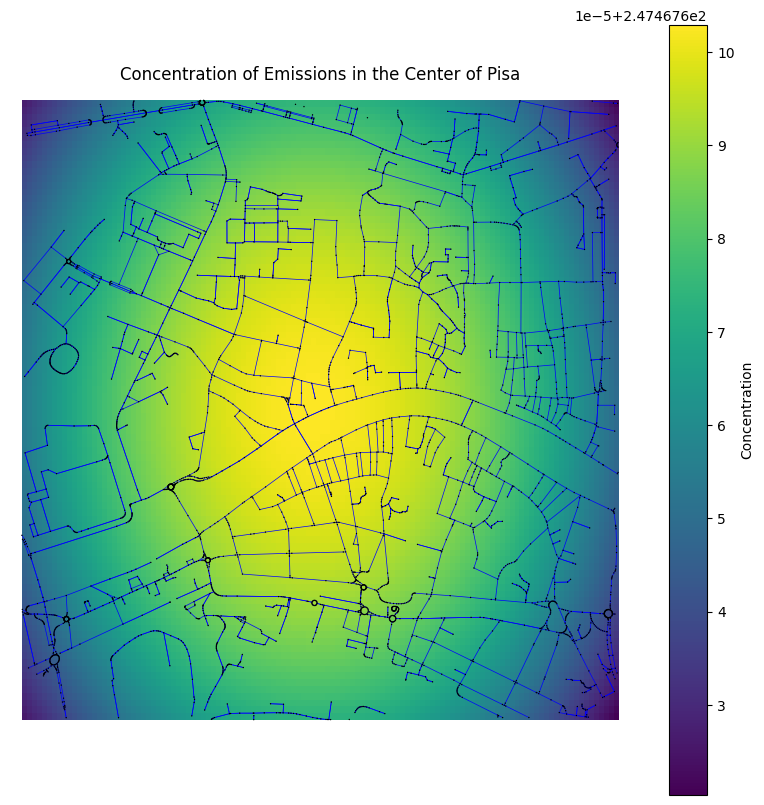

In [ ]:
# Normalize concentration for coloring
if concentration_grid.size > 0:
    C_norm = (concentration_grid - np.min(concentration_grid)) / (np.max(concentration_grid) - np.min(concentration_grid))
else:
    C_norm = concentration_grid

# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Download and plot the road network
ox.plot_graph(G, ax=plt.gca(), node_color='black', bgcolor='w', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('road_and_concentration_map.png', dpi=300)
plt.savefig('road_and_concentration_map.pdf', dpi=300)
print("Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.")

# Show the plot
plt.show()


In [ ]:
def calculate_concentration(emission_point, grid_shape, cell_size, time):
    # Define dispersion parameters
    Q_per_minute = 100  # Emission rate (g/minute)
    Q = Q_per_minute * 60  # Convert to g/hour for continuous emission
    D = 1  # Diffusion coefficient (m^2/minute)
    H = 0.5  # Initial height of emission (m)
    sigma_z = 0.76 * H  # Vertical dispersion coefficient (m)

    # Initialize concentration grid
    concentration_grid = np.zeros(grid_shape)

    # Calculate emission center cell indices
    center_x = grid_shape[1] // 2
    center_y = grid_shape[0] // 2

    # Calculate concentration for each cell in the grid
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            # Calculate distance from emission point to current cell
            distance_x = (j - center_x) * cell_size
            distance_y = (i - center_y) * cell_size

            # Calculate concentration using Gaussian dispersion model
            concentration = gaussian_concentration_simplified(Q, sigma_y, sigma_z, distance_x, distance_y, H)

            # Add concentration to grid
            concentration_grid[i, j] += concentration

    return concentration_grid


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import random

# Define center of Pisa and grid parameters
central_point = (43.715766, 10.401526)  # Ponte di Mezzo
grid_size = (200, 200)  # 2x2 km area divided into 5x5 meter cells

# Generate emission points
num_emission_points = 100
emission_points = [Point(random.uniform(central_point[0] - 0.001, central_point[0] + 0.001),
                         random.uniform(central_point[1] - 0.001, central_point[1] + 0.001))
                   for _ in range(num_emission_points)]
emission_amounts = [random.uniform(0.001, 0.5) for _ in range(num_emission_points)]

# Initialize concentration grid for the area
concentration_grid = np.zeros(grid_size)

# Calculate concentration grid for the emission point
point_concentration_grid = calculate_concentration(point, grid_size, 5, 60)  # Assuming 60 minutes

# Loop over each emission point
for point, amount in zip(emission_points, emission_amounts):
    # Scale the concentration grid by emission amount
    scaled_concentration_grid = point_concentration_grid * amount

    # Add the scaled concentration grid to the overall concentration grid
    concentration_grid += scaled_concentration_grid

# Visualize road network and concentration grid
# First, download and plot road network
print("Downloading road network...")
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, simplify=False, retain_all=True, network_type=network_type)
ox.plot_graph(G, node_color='black', edge_color='gray', bgcolor='white', node_size=0, edge_linewidth=0.5)

# Plot the concentration grid
plt.imshow(concentration_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 5  # Cell size in meters
central_area = (43.725, 43.707, 10.408, 10.384)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Create the map grid
x_map_grid = np.arange(xmin, xmax, cell_size/100000)
y_map_grid = np.arange(ymin, ymax, cell_size/100000)
X_map, Y_map = np.meshgrid(x_map_grid, y_map_grid)
map_grid_shape = X_map.shape
concentration_map_grid = np.zeros(map_grid_shape)

# Define emission sources randomly within the area
num_emission_sources = 100
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]
emission_rates = [random.uniform(0.001, 0.5) for _ in range(num_emission_sources)]

# Dispersion parameters
D = 1  # Diffusion coefficient (m^2/s)
H = 0.5  # Initial height of emission (m)
time = 3600  # Time in seconds for an hour
sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
sigma_z = 0.76 * H  # Vertical dispersion coefficient (m)

# Precompute the emission grid for a single point
grid_radius = int(sigma_y * 3)  # 3 standard deviations to capture most of the distribution
emission_grid_size = int(2 * grid_radius / cell_size) + 1
x_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
y_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
X_emission, Y_emission = np.meshgrid(x_emission_grid, y_emission_grid)
Z_emission = np.zeros_like(X_emission) + 0.76 * H  # Set Z to be 0.76 * H

# Calculate concentration values for the emission grid
emission_grid = gaussian_concentration(1, sigma_y, sigma_z, X_emission, Y_emission, H)

# Function to add emission grid to the map grid
def add_emission_to_map(concentration_map, emission_grid, pr, pc, scale_factor):
    grid_size = emission_grid.shape[0]
    for i in range(grid_size):
        for j in range(grid_size):
            if 0 <= pr + i < concentration_map.shape[0] and 0 <= pc + j < concentration_map.shape[1]:
                concentration_map[pr + i, pc + j] += emission_grid[i, j] * scale_factor

# Add emission grids to the map grid
for source, rate in zip(emission_sources, emission_rates):
    # Calculate the position in the map grid
    pr = int((source.y - ymin) / (ymax - ymin) * map_grid_shape[0])
    pc = int((source.x - xmin) / (xmax - xmin) * map_grid_shape[1])

    # Add the scaled emission grid to the map grid
    add_emission_to_map(concentration_map_grid, emission_grid, pr - emission_grid_size // 2, pc - emission_grid_size // 2, rate)

# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_map_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Download and plot the road network
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')
ox.plot_graph(G, ax=plt.gca(), node_color='black', bgcolor='w', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('road_and_concentration_map.png', dpi=300)
plt.savefig('road_and_concentration_map.pdf', dpi=300)
print("Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.")

# Show the plot
plt.show()


<ipython-input-3-e8c0508604ba>:86: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')


Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.


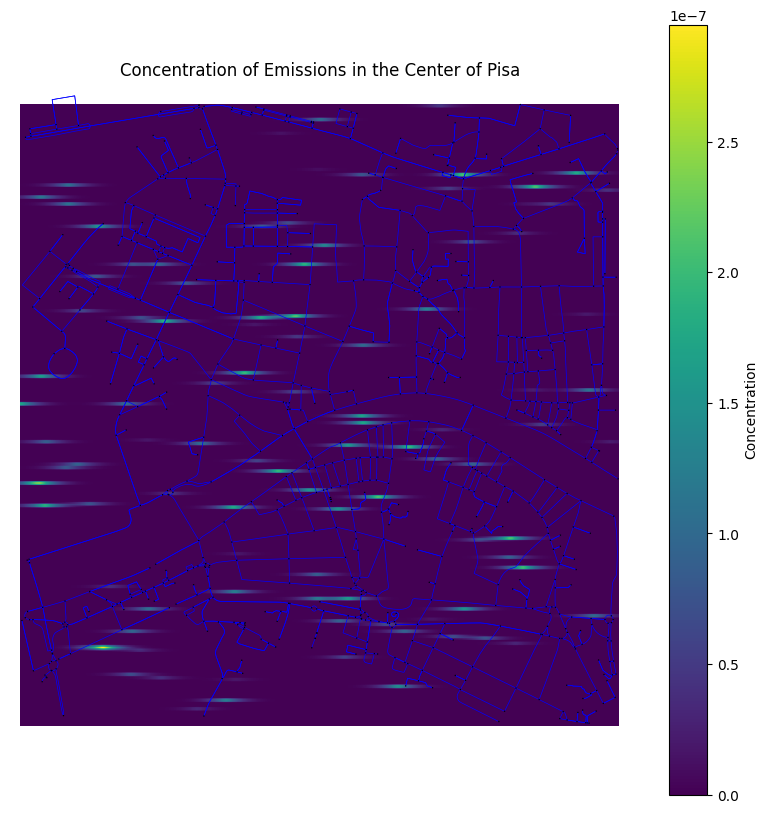

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 5  # Cell size in meters
central_area = (43.725, 43.707, 10.408, 10.384)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Create the map grid
x_map_grid = np.arange(xmin, xmax, cell_size/100000)
y_map_grid = np.arange(ymin, ymax, cell_size/100000)
X_map, Y_map = np.meshgrid(x_map_grid, y_map_grid)
map_grid_shape = X_map.shape
concentration_map_grid = np.zeros(map_grid_shape)

# Define emission sources randomly within the area
num_emission_sources = 100
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]
emission_rates = [random.uniform(0.001, 0.5) for _ in range(num_emission_sources)]

# Dispersion parameters
D = 1  # Diffusion coefficient (m^2/s)
H = 0.5  # Initial height of emission (m)
minutes_per_hour = 60
sigma_z = 0.76 * H  # Vertical dispersion coefficient (m)

# Precompute the emission grid for a single point
grid_radius = int(np.sqrt(2 * D * minutes_per_hour * 60) * 3)  # 3 standard deviations to capture most of the distribution
emission_grid_size = int(2 * grid_radius / cell_size) + 1
x_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
y_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
X_emission, Y_emission = np.meshgrid(x_emission_grid, y_emission_grid)
Z_emission = np.zeros_like(X_emission) + 0.76 * H  # Set Z to be 0.76 * H

# Calculate concentration values for the emission grid over 60 minutes
accumulated_emission_grid = np.zeros_like(X_emission)
for minute in range(1, minutes_per_hour + 1):
    time = minute * 60  # Convert minutes to seconds
    sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
    emission_grid = gaussian_concentration(1, sigma_y, sigma_z, X_emission, Y_emission, H)
    accumulated_emission_grid += emission_grid

# Function to add emission grid to the map grid
def add_emission_to_map(concentration_map, emission_grid, pr, pc, scale_factor):
    grid_size = emission_grid.shape[0]
    for i in range(grid_size):
        for j in range(grid_size):
            if 0 <= pr + i < concentration_map.shape[0] and 0 <= pc + j < concentration_map.shape[1]:
                concentration_map[pr + i, pc + j] += emission_grid[i, j] * scale_factor

# Add emission grids to the map grid
for source, rate in zip(emission_sources, emission_rates):
    # Calculate the position in the map grid
    pr = int((source.y - ymin) / (ymax - ymin) * map_grid_shape[0])
    pc = int((source.x - xmin) / (xmax - xmin) * map_grid_shape[1])

    # Add the scaled emission grid to the map grid
    add_emission_to_map(concentration_map_grid, accumulated_emission_grid, pr - emission_grid_size // 2, pc - emission_grid_size // 2, rate)

# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_map_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Download and plot the road network
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')
ox.plot_graph(G, ax=plt.gca(), node_color='black', bgcolor='w', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('road_and_concentration_map.png', dpi=300)
plt.savefig('road_and_concentration_map.pdf', dpi=300)
print("Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.")

# Show the plot
plt.show()


<ipython-input-82-97442e96931b>:86: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')


Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.


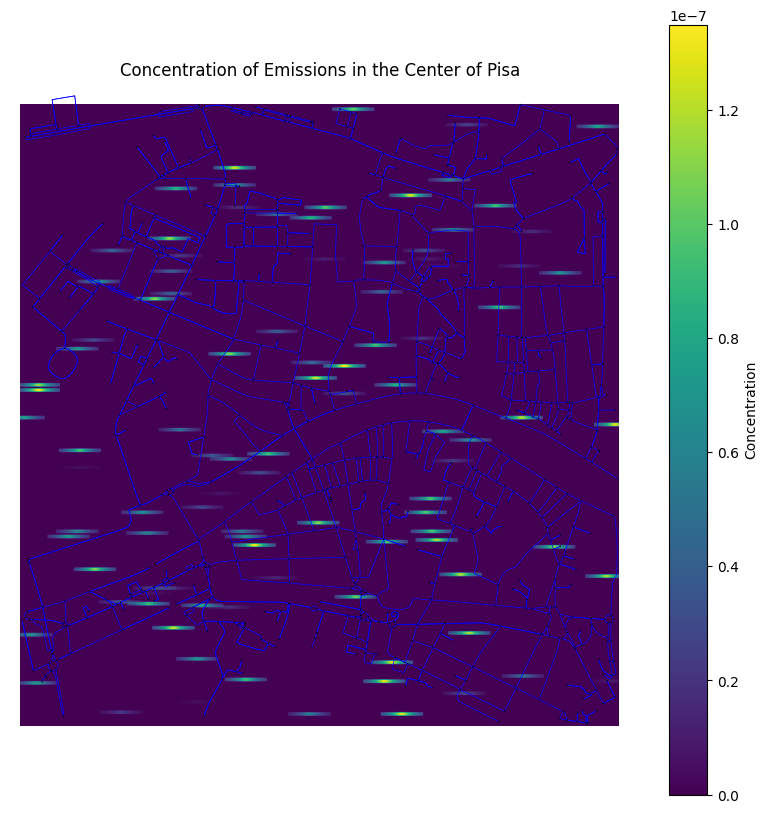

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point
import osmnx as ox
import random

# Function to calculate concentration using Gaussian model without wind
def gaussian_concentration(Q, sigma_y, sigma_z, y, z, H):
    term1 = (Q / (2 * np.pi * sigma_y * sigma_z))
    term2 = np.exp(-y**2 / (2 * sigma_y**2))
    term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
    term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
    return term1 * term2 * (term3 + term4)

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 5  # Cell size in meters
central_area = (43.725, 43.707, 10.408, 10.384)  # Specify the central area of Pisa (2x2 km)
ymax, ymin, xmax, xmin = central_area

# Create the map grid
x_map_grid = np.arange(xmin, xmax, cell_size/100000)
y_map_grid = np.arange(ymin, ymax, cell_size/100000)
X_map, Y_map = np.meshgrid(x_map_grid, y_map_grid)
map_grid_shape = X_map.shape
concentration_map_grid = np.zeros(map_grid_shape)

# Define emission sources randomly within the area
num_emission_sources = 100
emission_sources = [Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax)) for _ in range(num_emission_sources)]
emission_rates = [random.uniform(0.001, 0.5) for _ in range(num_emission_sources)]

# Dispersion parameters
D = 1  # Diffusion coefficient (m^2/s)
H = 0.5  # Initial height of emission (m)
minutes_per_hour = 60
sigma_z = 0.76 * H  # Vertical dispersion coefficient (m)

# Precompute the emission grid for a single point
grid_radius = #int(np.sqrt(2 * D * minutes_per_hour * 60) * 3)  # 3 standard deviations to capture most of the distribution
emission_grid_size = int(2 * grid_radius / cell_size) + 1
x_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
y_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
X_emission, Y_emission = np.meshgrid(x_emission_grid, y_emission_grid)
Z_emission = np.zeros_like(X_emission) + 0.76 * H  # Set Z to be 0.76 * H

# Calculate concentration values for the emission grid over 60 minutes
accumulated_emission_grid = np.zeros_like(X_emission)
for minute in range(1, minutes_per_hour + 1):
    time = minute * 60  # Convert minutes to seconds
    sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
    emission_grid = gaussian_concentration(1, sigma_y, sigma_z, X_emission, Y_emission, H)
    accumulated_emission_grid += emission_grid

# Function to add emission grid to the map grid
def add_emission_to_map(concentration_map, emission_grid, pr, pc, scale_factor):
    grid_size = emission_grid.shape[0]
    for i in range(grid_size):
        for j in range(grid_size):
            if 0 <= pr + i < concentration_map.shape[0] and 0 <= pc + j < concentration_map.shape[1]:
                concentration_map[pr + i, pc + j] += emission_grid[i, j] * scale_factor

# Add emission grids to the map grid
for source, rate in zip(emission_sources, emission_rates):
    # Calculate the position in the map grid
    pr = int((source.y - ymin) / (ymax - ymin) * map_grid_shape[0])
    pc = int((source.x - xmin) / (xmax - xmin) * map_grid_shape[1])

    # Add the scaled emission grid to the map grid
    add_emission_to_map(concentration_map_grid, accumulated_emission_grid, pr - emission_grid_size // 2, pc - emission_grid_size // 2, rate)

# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_map_grid, cmap='viridis', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Download and plot the road network
G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='drive_service')
ox.plot_graph(G, ax=plt.gca(), node_color='black', bgcolor='w', node_size=1, edge_color='blue', edge_linewidth=0.5, show=False, close=False)

# Save the figure
plt.savefig('road_and_concentration_map.png', dpi=300)
plt.savefig('road_and_concentration_map.pdf', dpi=300)
print("Figure saved as 'road_and_concentration_map.png' and 'road_and_concentration_map.pdf'.")

# Show the plot
plt.show()


In [ ]:
concentration_map_grid.shape

(361, 480)

In [ ]:
# import osmnx as ox
# import pandas as pd
# import random

# # Define the location and network type
# location = 'Pisa, Italy'
# network_type = 'drive_service'

# # Load the street network graph for Pisa
# G = ox.graph_from_place(location, truncate_by_edge=True, simplify=False, clean_periphery=False, retain_all=True, network_type=network_type)

# # Extract road segment IDs (start node ID and end node ID) from the street network graph
# road_segment_ids = [(u, v) for u, v, k in G.edges(keys=True)][:100]

# # Generate random emission amounts for each road segment
# emission_amounts = [random.uniform(1, 50) for _ in range(len(road_segment_ids))]

# # Create a DataFrame to store road segment IDs and emission amounts
# df = pd.DataFrame({'s_id': [s for s, e in road_segment_ids],
#                    'e_id': [e for s, e in road_segment_ids],
#                    'emission_amount': emission_amounts})

# print("Sample DataFrame:")
# print(df.head())


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:396: FutureWarning: The clean_periphery argument has been deprecated and will be removed in the v2.0.0 release. Future behavior will be as though clean_periphery=True. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = graph_from_polygon(


Sample DataFrame:
      s_id         e_id  emission_amount
0  8437272   7756825242        10.039757
1  8437273    346412821        40.110690
2  8437274   7734557046        16.677379
3  8437276  11886496367         9.947039
4  8437277    346410765        28.459407


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:396: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  G = graph_from_polygon(


# Concentration Map

In [ ]:
city = 'Pisa'
path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'
date = '06_21_2024'

embs_n_co2m = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/{}_embs_n_co2m.csv'.format(city.lower()))
embs_n_co2m = embs_n_co2m[['start_point', 'end_point', 'CO_2/m']]
embs_n_co2m = embs_n_co2m[embs_n_co2m['CO_2/m']<=100]
# embs_n_co2m = embs_n_co2m[embs_n_co2m['CO_2/m']>0.8]

embs_with_predictions = pd.read_csv(path+'xgb_xgb/mdi_preds_{}_{}_125.csv'.format(city.lower(), date))
embs_with_predictions = embs_with_predictions.rename(columns={'predicted_carbon':'CO_2/m'})
embs_with_predictions = embs_with_predictions[['start_point', 'end_point', 'CO_2/m']]
# embs_with_predictions = embs_with_predictions[['road_link', 'CO_2/m']]

embs_all = pd.concat([embs_with_predictions, embs_n_co2m], ignore_index=True)
# embs_n_co2m = embs_all

embs_n_co2m = embs_n_co2m.rename(columns={'start_point':'s_id', 'end_point':'e_id', 'CO_2/m':'emission_amount'})
df = embs_n_co2m[['s_id', 'e_id', 'emission_amount']]#.head(3000)
df['emission_amount'] = df['emission_amount'] / 365 / 24 / 60 # annual amission amount turned into average minute amount

print(len(df))
print(np.min(df.emission_amount), np.max(df.emission_amount))
df.head()


# embs_with_predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/{}_embs_with_predictions.csv'.format(city.lower()))
# embs_with_predictions = embs_with_predictions.rename(columns={'predicted_carbon':'CO_2/m'})
# embs_n_co2m = pd.concat([embs_with_predictions, embs_n_co2m], ignore_index=True)

30719
2.358085491105974e-09 0.0001840908819622425


s_id        e_id  emission_amount
0  7257369708    31770729     5.068239e-07
1    33681447  3044082602     1.007998e-06
2  3044082602  6957424170     4.562248e-07
3  6957424170  9986411817     3.620026e-07
4   213417023  9986411817     6.685588e-07

In [ ]:
embs_n_co2m

s_id        e_id  emission_amount
0      7257369708    31770729         0.266387
1        33681447  3044082602         0.529803
2      3044082602  6957424170         0.239792
3      6957424170  9986411817         0.190269
4       213417023  9986411817         0.351395
...           ...         ...              ...
30736  9493840970   907488570         0.957110
30737   907485021   251215592         0.029946
30738   251215592   907485021         0.012648
30739  9493840959  9493840987         5.077490
30740  9493840987  9493840959         2.147011

[30719 rows x 3 columns]

In [ ]:
edge_lens = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/OSM_{}_raw_segment'.format(city))
edge_lens = edge_lens[['s_id', 'e_id', 'length']]
# edge_lens.rename(columns={'s_id': 'start_point', 'e_id': 'end_point'}, inplace=True)
edge_lens.head()

s_id        e_id  length
0    31770729  7257369708   6.135
1  7257369708    31770729   6.135
2    33681447  3044082602  15.567
3  3044082602  6957424170  16.040
4  6957424170  9986411817   9.738

In [ ]:
df = pd.merge(df, edge_lens, on=['s_id', 'e_id'])
df['emission_amount'] = df['emission_amount'] * df['length']
df = df.drop(['length'], axis=1)
print(len(df))
df.head()

30719


s_id        e_id  emission_amount
0  7257369708    31770729         0.000003
1    33681447  3044082602         0.000016
2  3044082602  6957424170         0.000007
3  6957424170  9986411817         0.000004
4   213417023  9986411817         0.000005

In [ ]:
# df.emission_amount = np.log(df.emission_amount)
# print(np.min(df.emission_amount), np.max(df.emission_amount))
# df.head()

-14.299307509342357 -2.393167717032031


s_id        e_id  emission_amount
0  7257369708    31770729       -12.681092
1    33681447  3044082602       -11.062392
2  3044082602  6957424170       -11.825195
3  6957424170  9986411817       -12.555579
4   213417023  9986411817       -12.121474

In [ ]:
print(np.min(df.emission_amount), np.max(df.emission_amount))
# all
# 2.0138006088280058e-07 0.12532398587691443

# original
# 6.164383561643764e-07 0.09133988620808263

6.164383561643764e-07 0.09133988620808263


In [ ]:
# embs_with_predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/{}_embs_with_predictions.csv'.format(city.lower()))
# embs_with_predictions = embs_with_predictions.rename(columns={'predicted_carbon':'CO_2/m'})
# embs_all = embs_with_predictions.append(embs_n_co2m, ignore_index=True)

In [ ]:
# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define grid parameters
cell_size = 5  # Cell size in meters

# Fetch the boundary and bounding box for Pisa
# gdf = ox.geocode_to_gdf(location)
# xmin, ymin, xmax, ymax = gdf.total_bounds
# road = ox.graph_from_place(location, network_type=network_type, retain_all=True, truncate_by_edge=True, simplify=False)

central_area = (43.7295, 43.7025, 10.4214, 10.3824)  # Specify the central area of Pisa (3x3 km)
ymax, ymin, xmax, xmin = central_area
road = ox.graph_from_bbox(bbox=(ymax, ymin, xmax, xmin), network_type='drive_service',
                          retain_all=True, truncate_by_edge=True, simplify=False)

G_proj = ox.project_graph(road)
gdfs = ox.graph_to_gdfs(G_proj)
gdfs[1].reset_index(inplace=True)
roads_with_geometries = gdfs[1]
roads_with_geometries = roads_with_geometries.rename(columns={'u':'s_id', 'v':'e_id'})

roads_with_geometries = roads_with_geometries.merge(df, on=['s_id', 'e_id'])
print("There are %s road segments with emission in the map" %len(roads_with_geometries))
# 13955
# 8750

There are 8750 road segments with emission in the map


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Point, LineString
import random
from pyproj import Transformer

debug = False

# Dispersion parameters
D = 1  # Diffusion coefficient (m^2/s)
H = 0.5  # Initial height of emission (m)
minutes_per_hour = 60
sigma_z = 0.76 * H  # Vertical dispersion coefficient (m)

# Create a transformer from UTM (assuming UTM zone 32N, EPSG:32632) to WGS84
transformer = Transformer.from_crs("epsg:32632", "epsg:4326", always_xy=True)

# Function to calculate concentration using Gaussian model without wind

def gaussian_concentration(Q, sigma_y, sigma_z, x, y, H):
    # calculate time-integrated concentration at x, y, z
    dist = np.sqrt(x**2 + y**2)
    z = H
    f = np.exp(-(dist**2./(2.*sigma_y**2)))

    g1 = np.exp(-((z - H)**2./(2.*sigma_z**2)))
    g2 = np.exp(-((z + H)**2./(2.*sigma_z**2)))
    return Q * f/(sigma_y*np.sqrt(2.*np.pi)) * (g1 + g2)/(sigma_z*np.sqrt(2.*np.pi))

# def old_gaussian_concentration(Q, sigma_y, sigma_z, y, z, H):
#     term1 = (Q / (2 * np.pi * sigma_y * sigma_z))

#     term2 = np.exp(-y**2 / (2 * sigma_y**2))

#     term3 = np.exp(-(z-H)**2 / (2 * sigma_z**2))
#     term4 = np.exp(-(z+H)**2 / (2 * sigma_z**2))
#     return term1 * term2 * (term3 + term4)

# Create the map grid
x_map_grid = np.arange(xmin, xmax, cell_size/100000)
y_map_grid = np.arange(ymin, ymax, cell_size/100000)
X_map, Y_map = np.meshgrid(x_map_grid, y_map_grid)
map_grid_shape = X_map.shape
concentration_map_grid = np.zeros(map_grid_shape)

# Define emission sources based on road segments
num_emission_sources = 0
emission_sources = []

# Iterate over the DataFrame rows
for idx, row in roads_with_geometries.iterrows():
    s_id = row['s_id']
    e_id = row['e_id']
    emission_amount = row['emission_amount']
    if debug:
     print(s_id, e_id)

    # retrieve road geometry
    geometry = row['geometry']
    line = LineString(geometry)

    # calculate the length of the road segment
    road_length = line.length

    # calculate the number of emission points on the road segment
    num_points = int(road_length) + 1
    if debug:
      print(line.length, num_points)

    # distribute emission amount equally among the points
    emission_per_point = emission_amount / num_points

    # generate emission points along the road segment
    for distance in np.linspace(start=0, stop=int(road_length), num=num_points):
        point = line.interpolate(distance)
        # print(distance, point)
        x, y = transformer.transform(point.x, point.y)  # Transform to WGS84
        # print(x, y)
        emission_sources.append((x, y, emission_per_point))
        num_emission_sources += 1

print("The number of emission sources is %s" %num_emission_sources)

# Precompute the emission grid for a single point
grid_radius = int(np.sqrt(2 * D * minutes_per_hour * 60) * 3)  # 3 standard deviations to capture most of the distribution
emission_grid_size = int(2 * grid_radius / cell_size) + 1

x_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)
y_emission_grid = np.linspace(-grid_radius, grid_radius, emission_grid_size)

X_emission, Y_emission = np.meshgrid(x_emission_grid, y_emission_grid)
# Z_emission = np.zeros_like(X_emission) + 0.76 * H  # Set Z to be 0.76 * H

# Calculate concentration values for the emission grid over 60 minutes
accumulated_emission_grid = np.zeros_like(X_emission)

for minute in range(1, minutes_per_hour + 1):
    time = minute * 60  # Convert minutes to seconds
    sigma_y = np.sqrt(2 * D * time)  # Horizontal dispersion coefficient (m)
    emission_grid = gaussian_concentration(1, sigma_y, sigma_z, X_emission, Y_emission, H)
    accumulated_emission_grid += emission_grid # SHOULD WE SPECIFY COORDINATES?

# Function to add emission grid to the map grid
def add_emission_to_map(concentration_map, emission_grid, pr, pc, scale_factor):
    grid_size = emission_grid.shape[0]
    for i in range(grid_size):
        for j in range(grid_size):
            if 0 <= pr + i < concentration_map.shape[0] and 0 <= pc + j < concentration_map.shape[1]:
                concentration_map[pr + i, pc + j] += emission_grid[i, j] * scale_factor
# WHY NOt WHOLLY ADDED ?


# Add emission grids to the map grid
for source in emission_sources:
    x, y, rate = source
    # Calculate the position in the map grid
    pr = int((y - ymin) / (ymax - ymin) * map_grid_shape[0])
    pc = int((x - xmin) / (xmax - xmin) * map_grid_shape[1])

    # Add the scaled emission grid to the map grid
    add_emission_to_map(concentration_map_grid, accumulated_emission_grid, pr - emission_grid_size // 2, pc - emission_grid_size // 2, rate)

  # emission sources:
  # 252538, 252391
  # 198532


The number of emission sources is 198532


In [ ]:
print("Minimum: %s\nMaximum: %s\nMean: %s" %(np.min(concentration_map_grid), np.max(concentration_map_grid), np.mean(concentration_map_grid)))

# all emissions:
# Minimum: 1.5920775785202082e-08
# Maximum: 0.014539067097976225
# Mean: 0.0004013696682315049

# below 100
# Minimum: 0.0
# Maximum: 0.004961519509492084
# Mean: 0.00035085278450715186

# original emissions:
# Minimum: 0.0
# Maximum: 0.004934669300394761
# Mean: 0.0003318534384155065

Minimum: 0.0
Maximum: 0.004934669300394761
Mean: 0.0003318534384155065


In [ ]:
# concentration_map_grid = np.log(concentration_map_grid)

<ipython-input-70-de377153c511>:1: RuntimeWarning: divide by zero encountered in log
  concentration_map_grid = np.log(concentration_map_grid)


In [ ]:
# Step 1: Identify the minimum non-zero value
non_zero_values = concentration_map_grid[concentration_map_grid != 0]
min_non_zero_value = non_zero_values.min()
print(min_non_zero_value)

# Step 2: Replace zeros with this minimum non-zero value
concentration_map_grid = np.where(concentration_map_grid == 0, min_non_zero_value, concentration_map_grid)

1.0029083876740059e-11


## Plot the Map

In [ ]:
# Assuming `concentration_map_grid` is already calculated
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'  # Define your output path
emissions = 'original' # original/all

# Save the concentration map grid to a file
# np.save(output_path + 'minute_concentration_map_pisa_3x3_original_below_100.npy', concentration_map_grid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Minimum cell concentration:1.0029083876740059e-11
Maximum cell concentraation:0.004934669300394761



(<Figure size 1000x1000 with 2 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

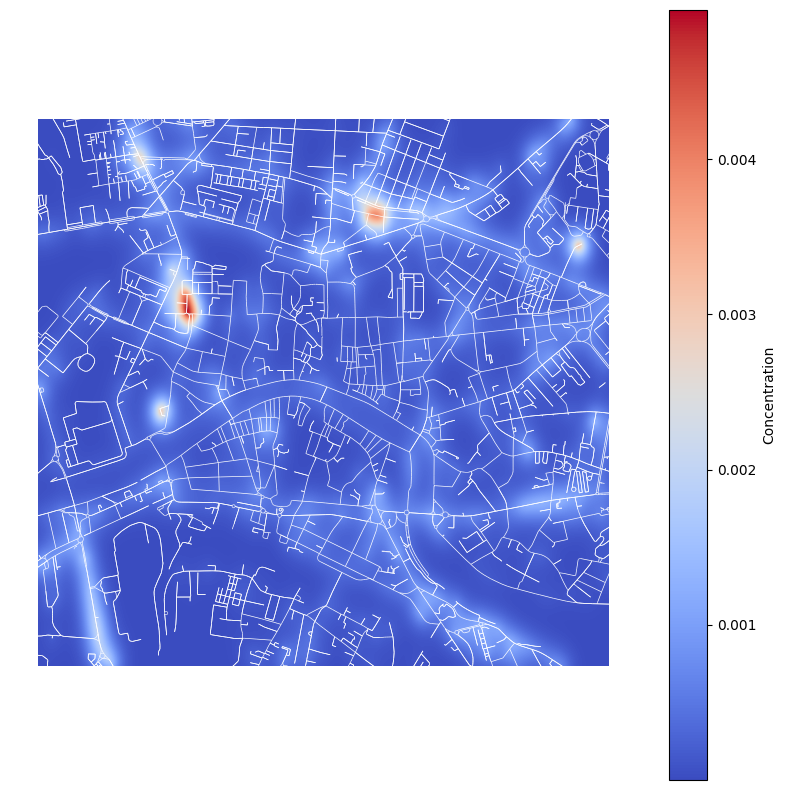

In [ ]:
debug = False

central_area = (43.7295, 43.7025, 10.4214, 10.3824)  # Specify the central area of Pisa (3x3 km)
ymax, ymin, xmax, xmin = central_area
road = ox.graph_from_bbox(bbox=(ymax, ymin, xmax, xmin), network_type='drive_service',
                          retain_all=True, truncate_by_edge=True, simplify=False)

emissions = 'original' # original/all
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'  # Define your output path

concentration_map_grid = np.load(output_path + 'minute_concentration_map_pisa_3x3_{}_below_100.npy'.format(emissions))
print("Minimum cell concentration:%s\nMaximum cell concentraation:%s\n" %(np.min(concentration_map_grid), np.max(concentration_map_grid)))
# 1.5920775785202082e-08 0.004961519509492084
# 1.0029083876740059e-11 0.004934669300394761


# Define new color scale limits
vmin = 1.0029083876740059e-11  # minimum value for the color bar
vmax = 0.004961519509492084  # maximum value for the color bar


# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(concentration_map_grid, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax]) # vmin=vmin, vmax=vmax,
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Plot emission points on the road network
if debug:
  for source in emission_sources:
      x, y, _ = source
      plt.plot(x, y, 'ro', markersize=0.05)

# Download and plot the road network
ox.plot_graph(road, ax=plt.gca(), node_color='none', bgcolor='w', node_size=0, edge_color='white', edge_linewidth=0.5, show=False, close=False)

In [ ]:
iusave = False
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/plots/'  # Define your output path

# Save the figure
if save:
  plt.savefig(output_path+'carbon_all_concentration_pisa_below_100.png', dpi=300, bbox_inches='tight')
  plt.savefig(output_path+'carbon_all_concentration_pisa_below_100.pdf', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

Minimum cell concentration:-17.955640927491192
Maximum cell concentraation:-5.306043232441535

-17.955640927491192 -5.306043232441535


(<Figure size 1000x1000 with 2 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

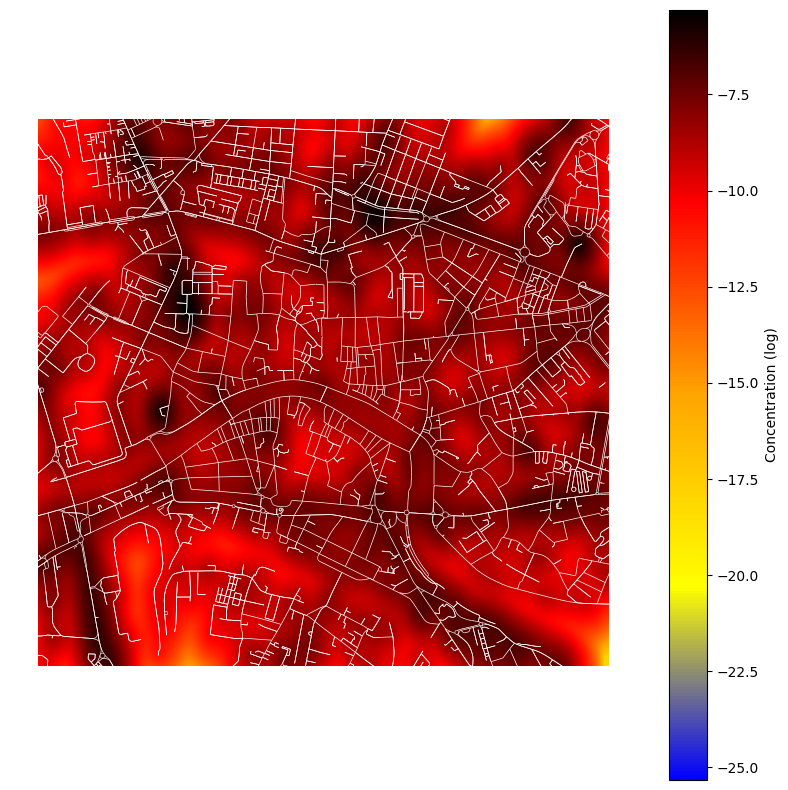

In [ ]:
from matplotlib.colors import LinearSegmentedColormap


debug = False

central_area = (43.7295, 43.7025, 10.4214, 10.3824)  # Specify the central area of Pisa (3x3 km)
ymax, ymin, xmax, xmin = central_area
road = ox.graph_from_bbox(bbox=(ymax, ymin, xmax, xmin), network_type='drive_service',
                          retain_all=True, truncate_by_edge=True, simplify=False)

emissions = 'all' # original/all
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'  # Define your output path

concentration_map_grid = np.load(output_path + 'minute_concentration_map_pisa_3x3_{}_below_100.npy'.format(emissions))
log_concentration_map_grid = np.log(concentration_map_grid)
print("Minimum cell concentration:%s\nMaximum cell concentraation:%s\n" %(np.min(log_concentration_map_grid), np.max(log_concentration_map_grid)))


# Define new color scale limits
vmin = -25.32553185643736  # minimum value for the color bar
vmax = -5.306043232441535  # maximum value for the color bar
print(np.min(log_concentration_map_grid), np.max(log_concentration_map_grid))
# (-17.955640927491192, -5.306043232441535)
# -25.32553185643736 -5.3114696194069255

# Define custom colormap (green to yellow to red)
cmap = LinearSegmentedColormap.from_list('custom_colormap', ['blue', 'yellow', 'orange', 'red', 'black'])

# Plot the concentration grid
plt.figure(figsize=(10, 10))
plt.imshow(log_concentration_map_grid, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax]) # vmin=vmin, vmax=vmax,
plt.colorbar(label='Concentration (log)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Concentration of Emissions in the Center of Pisa')
plt.grid(True)

# Plot emission points on the road network
if debug:
  for source in emission_sources:
      x, y, _ = source
      plt.plot(x, y, 'ro', markersize=0.05)

# Download and plot the road network
ox.plot_graph(road, ax=plt.gca(), node_color='none', bgcolor='w', node_size=0, edge_color='white', edge_linewidth=0.5, show=False, close=False)

In [ ]:
save = False
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/plots/'  # Define your output path

# Save the figure
if save:
  plt.savefig(output_path+'log_carbon_original_concentration_pisa_below_100.png', dpi=300, bbox_inches='tight')
  plt.savefig(output_path+'log_carbon_original_concentration_pisa_below_100.pdf', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

Check the problem of concentration ranges

# Exposure

In [ ]:
# Get schools within the bounding box
tags = {'amenity': 'school'}
schools = ox.geometries_from_bbox(ymax, ymin, xmax, xmin, tags)

# Convert to UTM coordinates
# schools_utm = schools.to_crs(G_proj.graph['crs'])

print(f"\nThere are {len(schools)} schools in Pisa.")

# # Load schools data (assuming it's a GeoDataFrame)
# schools = ox.geocode_to_gdf(['Pisa, Italy'])
# schools_utm = ox.project_gdf(schools)  # Project to UTM

# # Filter schools within the defined central area
# schools_filtered = schools_utm.cx[xmin:xmax, ymin:ymax]


<ipython-input-11-593d44ea99dd>:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  schools = ox.geometries_from_bbox(ymax, ymin, xmax, xmin, tags)
/usr/local/lib/python3.10/dist-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)



There are 37 schools in Pisa.


In [ ]:
# Function to get concentration from the precomputed grid
def get_concentration_from_grid(concentration_map, x, y, xmin, xmax, ymin, ymax):
    pr = int((y - ymin) / (ymax - ymin) * concentration_map.shape[0])
    # print("y: %s" %y)
    # print("pr: %s" %pr)
    pc = int((x - xmin) / (xmax - xmin) * concentration_map.shape[1])
    # print("pc: %s" %pc)
    if 0 <= pr < concentration_map.shape[0] and 0 <= pc < concentration_map.shape[1]:
        return concentration_map[pr, pc]
    else:
        return 0


In [ ]:
concentration_map_grid_copy = concentration_map_grid * 24 * 365

# Calculate concentration at each school within the 2x2 km area
school_concentrations = []
for idx, school in schools.iterrows():
    point = school.geometry
    # print(idx, point)

    # Check if the geometry is a point or a polygon
    if isinstance(point, Point):
        school_x, school_y = point.x, point.y
        # print("school_x: %s, school_y: %s" %(school_x, school_y))
    elif isinstance(point, Polygon):
        centroid = point.centroid
        school_x, school_y = centroid.x, centroid.y
        # print("school_x: %s, school_y: %s" %(school_x, school_y))
    else:
        # Skip if geometry type is not handled
        continue

    concentration = get_concentration_from_grid(concentration_map_grid_copy, school_x, school_y, xmin, xmax, ymin, ymax)
    school_concentrations.append((school['name'], school_x, school_y, concentration))

# Now you have the concentrations at each school in the `school_concentrations` list


Number of schools: 36
Mean concentration: 2.21
Median concentration: 1.71
Max concentration: 6.87
Min concentration: 0.00
Standard deviation of concentration: 1.72


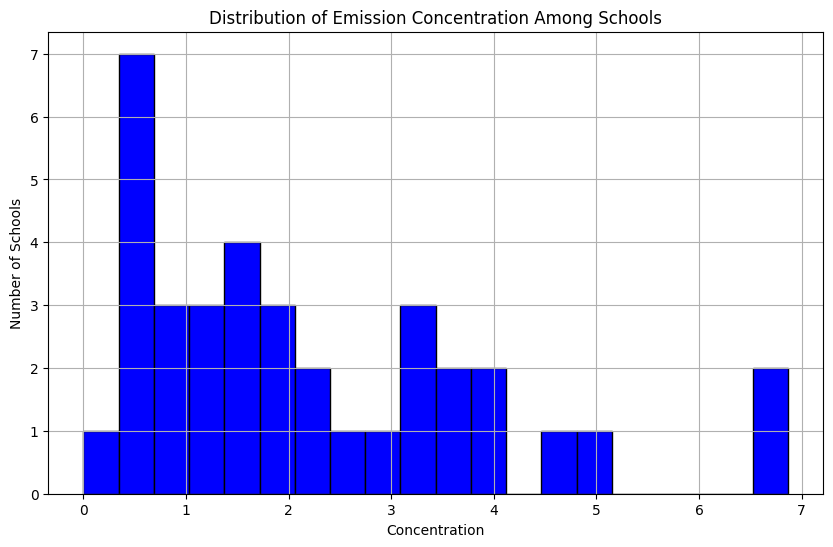

In [ ]:
# Convert to a DataFrame for easier analysis
school_concentration_df = pd.DataFrame(school_concentrations, columns=['school_name', 'school_x', 'school_y', 'concentration'])
# school_concentration_df['concentration'] = np.exp(school_concentration_df['concentration'])

# Count the number of schools
num_schools = len(school_concentration_df)

# Calculate basic statistics
mean_concentration = school_concentration_df['concentration'].mean()
median_concentration = school_concentration_df['concentration'].median()
max_concentration = school_concentration_df['concentration'].max()
min_concentration = school_concentration_df['concentration'].min()
std_concentration = school_concentration_df['concentration'].std()

# Print the statistics
print(f"Number of schools: {num_schools}")
print(f"Mean concentration: {mean_concentration:.2f}")
print(f"Median concentration: {median_concentration:.2f}")
print(f"Max concentration: {max_concentration:.2f}")
print(f"Min concentration: {min_concentration:.2f}")
print(f"Standard deviation of concentration: {std_concentration:.2f}")

# Plot the concentration distribution among schools
plt.figure(figsize=(10, 6))
plt.hist(school_concentration_df['concentration'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Concentration')
plt.ylabel('Number of Schools')
plt.title('Distribution of Emission Concentration Among Schools')
plt.grid(True)
plt.show()

In [ ]:
# Rank the schools based on concentration
school_concentration_df['rank'] = school_concentration_df['concentration'].rank(method='min', ascending=False).astype(int)
school_concentration_df = school_concentration_df.sort_values('rank')
school_concentration_df['concentration'] = np.exp(school_concentration_df['concentration'])

# Print ranked schools
school_concentration_df

school_name   school_x   school_y  \
7                          Scuola Primaria De Sanctis  10.415800  43.712802   
34                            Scuola Primaria "Biagi"  10.385646  43.709495   
3                                      Santa Caterina  10.404116  43.721462   
11                          Scuola Primaria D. Chiesa  10.408033  43.718319   
21                         IPSSAR "Giacomo Matteotti"  10.417732  43.717126   
2                    Liceo Classico "Galileo Galilei"  10.402882  43.710677   
0                     Liceo scientifico "Ulisse Dini"  10.401278  43.710799   
31                     Scuole Elementari "De Sanctis"  10.415647  43.712410   
12                                   IPSIA "Fascetti"  10.393784  43.726743   
33                      Scuola Primaria “C. Battisti”  10.404682  43.707367   
1    Istituto Tecnico Commerciale "Antonio Pacinotti"  10.402105  43.710749   
4                                    Scuola di Musica  10.395816  43.711170   
14                              Liceo Giosuè Carducci  10.404212  43.722429   
15                      Scuola Media Giuseppe Mazzini  10.396445  43.727895   
18         Scuola Materna ed Elementare "Fabio Filzi"  10.392887  43.726051   
20                                 Accademia Estetica  10.387814  43.724791   
28                          Scuola Primaria "Cambini"  10.395358  43.712908   
9                   Centro Sociale Suore Immacolatine  10.406966  43.721586   
6                                 Accademia Estetista  10.405829  43.704824   
27                       Scuola Elementare "N. Sauro"  10.398910  43.703905   
10           Scuola pubblica media "Giuseppe Toniolo"  10.394893  43.712819   
13                           ITIS "Leonardo da Vinci"  10.394908  43.725284   
5                                                CILT  10.403043  43.718945   
22  Istituto Arcivescovile Paritario - Santa Caterina  10.405632  43.721606   
30                         Collegio "Tiziano Terzani"  10.405757  43.720109   
26                 Scuola dell'infanzia San Francesco  10.397308  43.706175   
17             Complesso scolastico Concetto Marchesi  10.418191  43.714327   
8   Liceo Scientifico "Filippo Buonarroti" e I.T.G...  10.417628  43.714373   
35                               Succursale IC Fucini  10.401917  43.711887   
16                       Liceo Artistico "F. Russoli"  10.399301  43.718839   
25                  Scuola Elementare "Carlo Collodi"  10.397616  43.729447   
24                     Scuola Primaria "E. Zerboglio"  10.402584  43.713070   
29                     Scuola Primaria “O. Lorenzini”  10.406322  43.702602   
32                Scuola primaria "Guglielmo Oberdan"  10.418263  43.707254   
19       Istituto d’Istruzione Superiore “E. Santoni”  10.407481  43.703278   
23                 Istituto Comprensivo Renato Fucini  10.401804  43.702251   

    concentration  rank  
7      958.818135     1  
34     796.991285     2  
3      142.700671     3  
11      87.038512     4  
21      48.462176     5  
2       44.629666     6  
0       39.932977     7  
31      34.682448     8  
12      27.929158     9  
33      27.554315    10  
1       23.340304    11  
4       21.184366    12  
14      11.350951    13  
15       9.730621    14  
18       9.470475    15  
20       7.597249    16  
28       7.007009    17  
9        5.749503    18  
6        5.313590    19  
27       5.025891    20  
10       4.608244    21  
13       4.546153    22  
5        3.695270    23  
22       3.321942    24  
30       2.931330    25  
26       2.750919    26  
17       2.407876    27  
8        2.097324    28  
35       1.912252    29  
16       1.904693    30  
25       1.892503    31  
24       1.574443    32  
29       1.572045    33  
32       1.446701    34  
19       1.438694    35  
23       1.000000    36

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'
# school_concentration_df.to_csv('school_concentrations_{}.csv'.format(city.lower()), index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
# Extract the top 10 schools with the highest concentrations
top_10_schools = school_concentration_df.nlargest(5, 'concentration')

# Extract the bottom 10 schools with the lowest concentrations
bottom_10_schools = school_concentration_df.nsmallest(5, 'concentration')

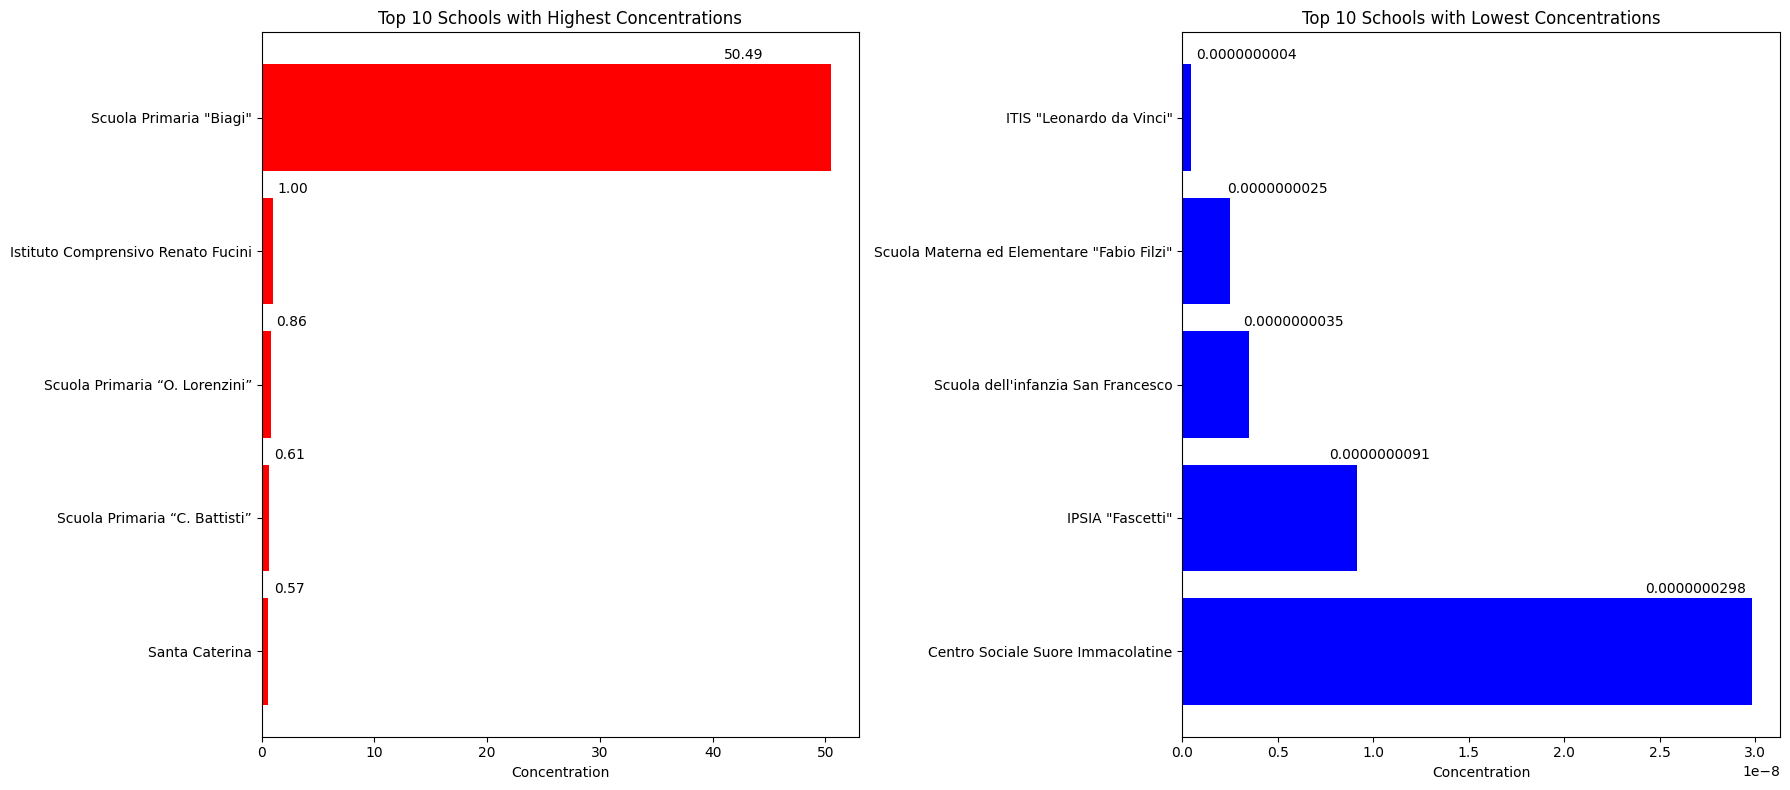

In [ ]:
# Set up the figure and axes for the bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Bar plot for the top 10 schools
bars_top = axes[0].barh(top_10_schools['school_name'], top_10_schools['concentration'], color='red')
axes[0].set_title('Top 10 Schools with Highest Concentrations')
axes[0].set_xlabel('Concentration')
axes[0].invert_yaxis()  # Highest concentration on top

# Annotate bars with concentration values
for bar in bars_top:
    width = bar.get_width()
    axes[0].annotate(f'{width:.2f}', xy=(width*4/5, bar.get_y() + bar.get_height() / 2),
                     xytext=(5, 45), textcoords='offset points', va='center', ha='left')

# Bar plot for the bottom 10 schools
bars_bottom = axes[1].barh(bottom_10_schools['school_name'], bottom_10_schools['concentration'], color='blue')
axes[1].set_title('Top 10 Schools with Lowest Concentrations')
axes[1].set_xlabel('Concentration')
axes[1].invert_yaxis()  # Lowest concentration on top

# Annotate bars with concentration values
for bar in bars_bottom:
    width = bar.get_width()
    axes[1].annotate(f'{width:.10f}', xy=(width*4/5, bar.get_y() + bar.get_height() / 2),
                     xytext=(5, 45), textcoords='offset points', va='center', ha='left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:

# Display the concentrations at each school
for school in school_concentrations:
    print(f"School at ({school[0]}, {school[1]}) has an estimated concentration of {school[2]:.2f}.")

# Optionally, plot the concentrations on the map
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(concentration_map_grid, cmap='coolwarm', origin='lower', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Concentration of Emissions in Pisa')
plt.grid(True)

# Plot schools on the map
for school in school_concentrations:
    plt.plot(school[0], school[1], 'bo')


## Route Exposure

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'  # Define your output path

# Load the concentration map grid from the file
concentration_map_grid = np.load(output_path + 'log_preds_concentration_map_pisa_3x3.npy')

Create routes

In [ ]:
def get_route_tomtom(start_lat, start_lon, end_lat, end_lon, departure_time_start, key, num_alternatives=3, routing_type='fastest', create_map=True):

    base_url = "https://api.tomtom.com/routing/1/calculateRoute/"

    # starting and ending locations (as strings)
    start = "%s,%s" %(start_lat,start_lon)
    end = "%s,%s" %(end_lat,end_lon)

    # departure time
    # departure_time = departure_time_start.replace(hour=departure_time_start.hour)
    departure_time = departure_time_start.strftime('%Y-%m-%dT%H:%M:%S')

    #print(departure_time)

    # create request URL
    request_params = (urllib.parse.quote(start) + ":" + urllib.parse.quote(end)
                      + "/json?departAt=" + urllib.parse.quote(departure_time)
                      + "&routeType=" + urllib.parse.quote(routing_type)
                      + f"&maxAlternatives={num_alternatives}"
                      +  "&alternativeType=anyRoute"
                      + "&travelMode=pedestrian"
                      + "&coordinatePrecision=full")


    request_url = base_url + request_params + "&key=" + key

    # get data
    response = requests.get(request_url)
    print(response)

    # convert to JSON
    json_result = response.json()
    if 'detailedError' in json_result.keys():
        print(json_result['detailedError']['message'])
        print(json_result['detailedError']['code'])
        return None
    # json_result is an object that also has a 'summary' dict indicating a few details on the computed route:
    # {'lengthInMeters','travelTimeInSeconds', 'trafficDelayInSeconds', 'trafficLengthInMeters', 'departureTime','arrivalTime'}
    # It can be obtained as: json_result['routes'][0]['summary']

    # getting the points forming the route
    list_route_points = json_result['routes'][0]['legs'][0]['points']
    df_route = pd.json_normalize(list_route_points)
    points = [[lng, lat] for lat,lng in zip(df_route['latitude'],df_route['longitude'])]

    if create_map:
        m = folium.Map(location=[start_lat, start_lon], tiles='cartodbpositron', zoom_start=15)
        folium.PolyLine(points).add_to(m)
    else:
        m = None

    return {"points": points, "summary": json_result["routes"][0]["summary"]}

In [ ]:
def get_route_tomtom(start_lat, start_lon, end_lat, end_lon, departure_time_start, key, num_alternatives=3, routing_type='fastest', create_map=False, route_colors=None):

    base_url = "https://api.tomtom.com/routing/1/calculateRoute/"

    # starting and ending locations (as strings)
    start = "%s,%s" %(start_lat, start_lon)
    end = "%s,%s" %(end_lat, end_lon)

    # departure time
    # departure_time = departure_time_start.replace(hour=departure_time_start.hour)
    departure_time = departure_time_start.strftime('%Y-%m-%dT%H:%M:%S')
    #print(departure_time)

    # create request URL
    request_params = (urllib.parse.quote(start) + ":" + urllib.parse.quote(end)
                      + "/json?departAt=" + urllib.parse.quote(departure_time)
                      + "&routeType=" + urllib.parse.quote(routing_type)
                      + f"&maxAlternatives={num_alternatives}"
                      +  "&alternativeType=anyRoute"
                      + "&travelMode=pedestrian"
                      + "&coordinatePrecision=full")


    request_url = base_url + request_params + "&key=" + key

    # get data
    response = requests.get(request_url)
    print(response)

    # convert to JSON
    json_result = response.json()

    routes = []
    for i, route in enumerate(json_result.get('routes', [])):
        points = [[point['latitude'], point['longitude']] for leg in route['legs'] for point in leg['points']]
        summary = route['summary']
        route['summary']['id'] = i+1
        routes.append({"points": points, "summary": summary})

    if create_map:
        if not route_colors:
            # Define colors for each route
            route_colors = ['#333333', '#990000', '#006600', '#FF6600']  # Dark black, dark red, dark green, dark orange

        m = folium.Map(location=[start_lat, start_lon], tiles='cartodbpositron', zoom_start=15)

        for i, route in enumerate(routes):
            color = route_colors[i % len(route_colors)]  # Ensure colors wrap around if fewer than routes
            folium.PolyLine(route['points'], color=color, tooltip=f'Route {i+1}').add_to(m)
        return m
    else:
        return routes

In [ ]:
# Example usage:
start_lat, start_lon = 43.7183, 10.4084
end_lat, end_lon = 43.7085, 10.3991

departure_time_start = datetime.now()
key = 'wXzrr5HuBroHvGNtXo0rRNBgOBgtjFLl'

# Define specific colors for each route
route_colors = ['#333333', '#990000', '#006600', '#FF6600']  # Dark black, dark red, dark green, dark orange

map_object = get_route_tomtom(start_lat, start_lon, end_lat, end_lon,
                              departure_time_start, key, create_map=False,
                              route_colors=route_colors)

if isinstance(map_object, folium.Map):
    map_object.save('routes_map.html')
    print("Map saved as 'routes_map.html'.")
else:
    for i, route in enumerate(map_object):
        print(f"Route {i + 1}:")
        print(f"Summary: {route['summary']}")
        print(f"Points: {route['points']}")
        print("\n")


<Response [200]>
Route 1:
Summary: {'lengthInMeters': 1663, 'travelTimeInSeconds': 1197, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-24T12:54:31+02:00', 'arrivalTime': '2024-06-24T13:14:28+02:00', 'id': 1}
Points: [[43.718604, 10.4083496], [43.7185478, 10.4077005], [43.7185183, 10.4073867], [43.71847, 10.406692], [43.7184164, 10.4061824], [43.7183788, 10.405772], [43.7183306, 10.4054287], [43.7183064, 10.4051685], [43.7182984, 10.4050988], [43.7182313, 10.4042485], [43.7178558, 10.4042754], [43.7172523, 10.404329], [43.7172362, 10.4041922], [43.7172201, 10.403983], [43.7172121, 10.4038784], [43.717196, 10.4037657], [43.7171718, 10.4034868], [43.7172014, 10.4031864], [43.7172148, 10.4029691], [43.7172067, 10.402886], [43.7171987, 10.4027975], [43.7171558, 10.4025105], [43.7171236, 10.4023415], [43.7168661, 10.4024273], [43.7167802, 10.4024273], [43.7165764, 10.4024112], [43.7164262, 10.4023334], [43.716343, 10.4022235], [43.716276, 10.402151], [43.7

In [ ]:
# Sample call
# start_lat, start_lon = 43.7183, 10.4084 # UniPi CS department
# end_lat, end_lon = 43.7085, 10.3991 # Pisa train station

# departure_time_start = datetime.now()  # Example: current time
# key = 'wXzrr5HuBroHvGNtXo0rRNBgOBgtjFLl'

# result = get_route_tomtom(start_lat, start_lon, end_lat, end_lon, departure_time_start, key)
print(map_object)

[{'points': [[43.718604, 10.4083496], [43.7185478, 10.4077005], [43.7185183, 10.4073867], [43.71847, 10.406692], [43.7184164, 10.4061824], [43.7183788, 10.405772], [43.7183306, 10.4054287], [43.7183064, 10.4051685], [43.7182984, 10.4050988], [43.7182313, 10.4042485], [43.7178558, 10.4042754], [43.7172523, 10.404329], [43.7172362, 10.4041922], [43.7172201, 10.403983], [43.7172121, 10.4038784], [43.717196, 10.4037657], [43.7171718, 10.4034868], [43.7172014, 10.4031864], [43.7172148, 10.4029691], [43.7172067, 10.402886], [43.7171987, 10.4027975], [43.7171558, 10.4025105], [43.7171236, 10.4023415], [43.7168661, 10.4024273], [43.7167802, 10.4024273], [43.7165764, 10.4024112], [43.7164262, 10.4023334], [43.716343, 10.4022235], [43.716276, 10.402151], [43.7161928, 10.4020679], [43.7159461, 10.4019177], [43.7155598, 10.4016817], [43.7155223, 10.4016656], [43.7154821, 10.4017997], [43.7152836, 10.4016763], [43.7151951, 10.4016012], [43.7150261, 10.4014242], [43.7150019, 10.401392], [43.7149698,

In [ ]:
for route in result:
  print(route['summary'])

{'lengthInMeters': 1663, 'travelTimeInSeconds': 1197, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-18T07:46:16+02:00', 'arrivalTime': '2024-06-18T08:06:13+02:00'}
{'lengthInMeters': 1750, 'travelTimeInSeconds': 1260, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-18T07:46:16+02:00', 'arrivalTime': '2024-06-18T08:07:16+02:00', 'deviationDistance': 52, 'deviationTime': 37, 'deviationPoint': {'latitude': 43.7185478, 'longitude': 10.4077005}}
{'lengthInMeters': 1669, 'travelTimeInSeconds': 1202, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-18T07:46:16+02:00', 'arrivalTime': '2024-06-18T08:06:17+02:00', 'deviationDistance': 808, 'deviationTime': 582, 'deviationPoint': {'latitude': 43.7154821, 'longitude': 10.4017997}}
{'lengthInMeters': 1847, 'travelTimeInSeconds': 1330, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-18T07:46:16+02:00', 'arrivalTime

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'

# Load the concentration map grid from the file
# concentration_map_grid = np.load(output_path + 'log_preds_concentration_map_pisa_3x3.npy')
# concentration_map_grid = np.exp(concentration_map_grid)

Haversine distance

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers (can be adjusted for miles)

    return distance


Exposure based on distance

In [ ]:
def calculate_exposure_along_route(route_points, concentration_map, xmin, xmax, ymin, ymax):
    total_exposure = 0.0

    for i in range(len(route_points) - 1):
        lat1, lon1 = route_points[i]
        lat2, lon2 = route_points[i + 1]

        # Calculate distance (you may need to implement a distance function)
        distance = haversine_distance(lat1, lon1, lat2, lon2)
        # print(distance)
        # Alternatively, you can calculate time based on traffic data or assume constant speed
        # time = calculate_time(lat1, lon1, lat2, lon2)

        # Interpolate concentration for the midpoint of the segment
        midpoint_lat = (lat1 + lat2) / 2.0
        # print("midpoint lat: %s" %midpoint_lat)
        midpoint_lon = (lon1 + lon2) / 2.0

        concentration = get_concentration_from_grid(concentration_map, midpoint_lon, midpoint_lat, xmin, xmax, ymin, ymax)
        # print(concentration)
        # Calculate exposure (concentration * distance or concentration * time)
        exposure = concentration * distance

        # Add to total exposure
        total_exposure += exposure

    return total_exposure

In [ ]:
# Function to get concentration from the precomputed grid
def get_concentration_from_grid(concentration_map, x, y, xmin, xmax, ymin, ymax, debug=False):
    pr = int((y - ymin) / (ymax - ymin) * concentration_map.shape[0])
    if debug:
      print("y: %s" %y)
      print("pr: %s" %pr)
    pc = int((x - xmin) / (xmax - xmin) * concentration_map.shape[1])
    if debug:
      print("pc: %s" %pc)
    if 0 <= pr < concentration_map.shape[0] and 0 <= pc < concentration_map.shape[1]:
        return concentration_map[pr, pc]
    else:
        return 0


In [ ]:
# Example usage:
central_area = (43.7295, 43.7025, 10.4214, 10.3824)  # Specify the central area of Pisa (3x3 km)
ymax, ymin, xmax, xmin = central_area

route_points = [(43.7183, 10.4084), (43.7156, 10.4057), (43.7132, 10.4021), (43.7102, 10.3995), (43.7085, 10.3991)]
concentration_map = concentration_map_grid  # Your precomputed concentration map
xmin, xmax = xmin, xmax  # Define your xmin, xmax from the concentration map
ymin, ymax = ymin, ymax  # Define your ymin, ymax from the concentration map

total_exposure = calculate_exposure_along_route(route_points, concentration_map, xmin, xmax, ymin, ymax)
print(f"Total exposure along the route: {total_exposure} units.")

Total exposure along the route: 0.0003380958026169551 units.


In [ ]:
# route_points = [(43.7183, 10.4084), (43.7156, 10.4057), (43.7132, 10.4021), (43.7102, 10.3995), (43.7085, 10.3991)]
concentration_map = concentration_map_grid  # Your precomputed concentration map
xmin, xmax = xmin, xmax  # Define your xmin, xmax from the concentration map
ymin, ymax = ymin, ymax  # Define your ymin, ymax from the concentration map

for route in map_object:
  route_points = route['points']
  summary = route['summary']
  print(summary)
  total_exposure = calculate_exposure_along_route(route_points, concentration_map, xmin, xmax, ymin, ymax)
  rounded_emission = round(total_exposure, 2)
  route['summary']['emission'] = rounded_emission
  print(f"Total exposure along the route: {total_exposure*1000} mgrams.\n")

{'lengthInMeters': 1663, 'travelTimeInSeconds': 1197, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-24T12:54:31+02:00', 'arrivalTime': '2024-06-24T13:14:28+02:00', 'id': 1, 'emission': 0.0}
Total exposure along the route: 0.42899454229244227 mgrams.

{'lengthInMeters': 1750, 'travelTimeInSeconds': 1260, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-24T12:54:31+02:00', 'arrivalTime': '2024-06-24T13:15:31+02:00', 'deviationDistance': 52, 'deviationTime': 37, 'deviationPoint': {'latitude': 43.7185478, 'longitude': 10.4077005}, 'id': 2, 'emission': 0.0}
Total exposure along the route: 0.825043801332436 mgrams.

{'lengthInMeters': 1669, 'travelTimeInSeconds': 1202, 'trafficDelayInSeconds': 0, 'trafficLengthInMeters': 0, 'departureTime': '2024-06-24T12:54:31+02:00', 'arrivalTime': '2024-06-24T13:14:32+02:00', 'deviationDistance': 808, 'deviationTime': 582, 'deviationPoint': {'latitude': 43.7154821, 'longitude': 10.401799

In [ ]:
import folium

# Example routes data structure with emission information
# routes = [
#     {
#         "id": 1,
#         "points": [(43.7183, 10.4084), (43.7086021, 10.39918)],
#         "summary": {
#             "travel_time": "3 hours 30 minutes",
#             "emission": "25 kg CO2"
#         }
#     },
#     {
#         "id": 2,
#         "points": [(43.7183, 10.4084), (43.7086021, 10.39918)],
#         "summary": {
#             "travel_time": "5 hours",
#             "emission": "35 kg CO2"
#         }
#     },
#     {
#         "id": 3,
#         "points": [(43.7183, 10.4084), (43.7086021, 10.39918)],
#         "summary": {
#             "travel_time": "3 hours 30 minutes",
#             "emission": "25 kg CO2"
#         }
#     },
#     {
#         "id": 4,
#         "points": [(43.7183, 10.4084), (43.7086021, 10.39918)],
#         "summary": {
#             "travel_time": "3 hours 30 minutes",
#             "emission": "25 kg CO2"
#         }
#     }
# ]

# Assume you have the initial map already created
start_lat, start_lon = 43.7183, 10.4084
end_lat, end_lon = 43.7085, 10.3991

# Define colors for each route
route_colors = ['#333333', '#990000', '#006600', '#FF6600']  # Dark black, dark red, dark green, dark orange

m = folium.Map(location=[start_lat, start_lon], tiles='cartodbpositron', zoom_start=15)

for i, route in enumerate(map_object):
    color = route_colors[i % len(route_colors)]  # Ensure colors wrap around if fewer than routes
    folium.PolyLine(route['points'], color=color, tooltip=f'Route {i+1}').add_to(m)

    # Calculate the midpoint for adding a marker with popup
    midpoint = [sum(x) / len(x) for x in zip(*route['points'])]

    # Create HTML content with travel time and emission details
    info_html = f"""
    <div style="font-size: 12px; font-weight: bold;">
        Route {route['summary']['id']} Details<br>
        Travel Time: {route['summary']['travelTimeInSeconds']}<br>
        Emission: {route['summary']['emission']}<br>
    </div>
    """

    # Create a popup HTML with travel time and emission details
    # popup_html = f"<b>Route {route['summary']['id']} Details</b><br>"
    # popup_html += f"Travel Time: {route['summary']['travelTimeInSeconds']}<br>"
    # popup_html += f"Emission: {route['summary']['emission']}<br>"

    # Add a marker at the midpoint with the popup
    icon = folium.DivIcon(html=info_html)
    folium.Marker(location=midpoint, icon=icon).add_to(m)

# Save the updated map to an HTML file
html_file = 'updated_route_map_with_emissions.html'
m.save(html_file)

# Display the HTML file path
html_file


'updated_route_map_with_emissions.html'

# Extra Dispersion

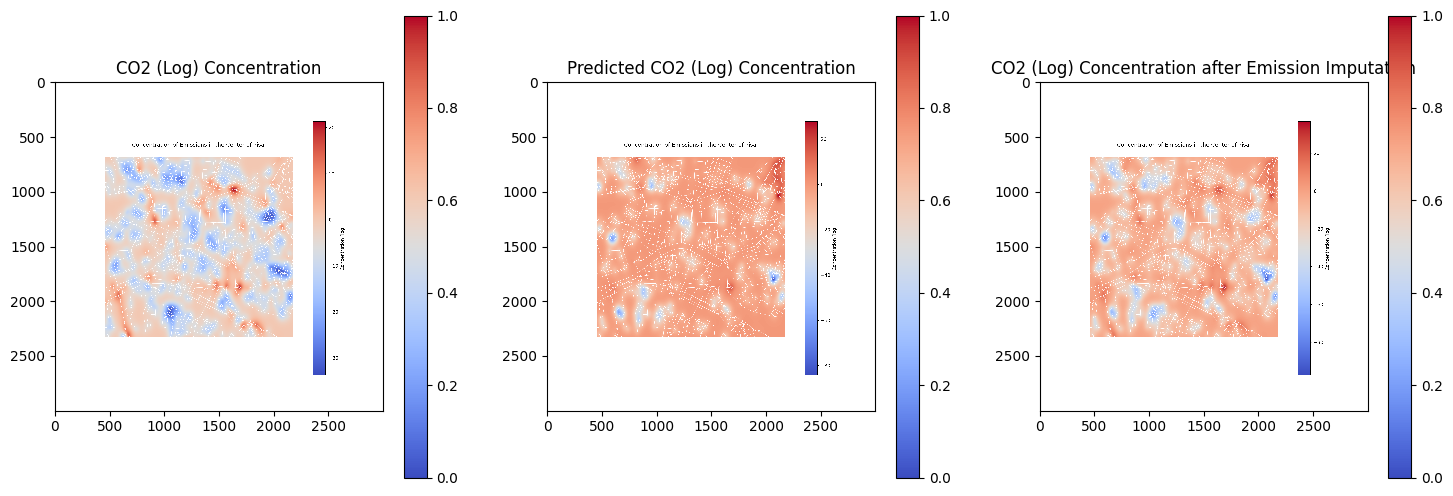

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'
# Load the images
img1_path = path+'carbon_log_concentration_below_100_pisa_3x3.png'
img2_path = path+'carbon_predicted_log_concentration_below_100_pisa_3x3.png'
img3_path = path+'carbon_imputed_log_concentration_below_100_pisa_3x3.png'

img1 = mpimg.imread(img1_path)
img2 = mpimg.imread(img2_path)
img3 = mpimg.imread(img3_path)

# Calculate the global vmin and vmax
vmin = min(np.min(img1), np.min(img2), np.min(img3))
vmax = max(np.max(img1), np.max(img2), np.max(img3))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Display the images with the same color scale
cax1 = axs[0].imshow(img1, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
cax2 = axs[1].imshow(img2, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
cax3 = axs[2].imshow(img3, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)

# Add colorbars
fig.colorbar(cax1, ax=axs[0], orientation='vertical')
fig.colorbar(cax2, ax=axs[1], orientation='vertical')
fig.colorbar(cax3, ax=axs[2], orientation='vertical')

# Set titles
axs[0].set_title('CO2 (Log) Concentration')
axs[1].set_title('Predicted CO2 (Log) Concentration')
axs[2].set_title('CO2 (Log) Concentration after Emission Imputation')

# Save the figure
fig.savefig('concentration_plots.pdf', bbox_inches='tight')

plt.show()


In [ ]:
from pyproj import Transformer

# Create a transformer object to convert from one CRS to another
# Replace 'epsg:xxxx' with the appropriate EPSG codes for your source and target CRS
transformer = Transformer.from_crs("epsg:source_crs", "epsg:target_crs", always_xy=True)

# Transform a point
x, y = transformer.transform(613410.855, 4840967.538)
print(x, y)

In [ ]:
G_proj = ox.project_graph(road)
gdfs = ox.graph_to_gdfs(G_proj)
gdfs[1].geometry

u            v            key
31770719     5598713027   0      LINESTRING (613416.783 4840767.477, 613420.561...
5598713027   8730764539   0      LINESTRING (613420.561 4840772.785, 613421.706...
31770722     1952494735   0      LINESTRING (613410.855 4840967.538, 613405.754...
             3011686026   0      LINESTRING (613410.855 4840967.538, 613413.891...
1952494735   5596491630   0      LINESTRING (613405.754 4840970.373, 613395.057...
                                                       ...                        
11883633577  11883633578  0      LINESTRING (611623.245 4840420.695, 611621.535...
11883633578  3594295539   0      LINESTRING (611621.535 4840426.565, 611620.086...
11883633580  11881873923  0      LINESTRING (611616.274 4840424.589, 611617.356...
11883633583  11883633584  0      LINESTRING (611622.532 4840451.323, 611623.311...
11883633584  3186515847   0      LINESTRING (611623.311 4840452.958, 611624.087...
Name: geometry, Length: 5864, dtype: geometry

In [ ]:
gdfs[1].reset_index(inplace=True)
roads = gdfs[1]
roads

u            v  key       osmid  oneway  \
0        31770719   5598713027    0   155210922    True   
1      5598713027   8730764539    0   155210922    True   
2        31770722   1952494735    0     5036121    True   
3        31770722   3011686026    0   302998691   False   
4      1952494735   5596491630    0     5036121    True   
...           ...          ...  ...         ...     ...   
5859  11883633577  11883633578    0   353614526    True   
5860  11883633578   3594295539    0   353614526    True   
5861  11883633580  11881873923    0   301614547    True   
5862  11883633583  11883633584    0  1074309446    True   
5863  11883633584   3186515847    0  1074309446    True   

                             name   highway  reversed  length lanes maxspeed  \
0     Lungarno Leonardo Fibonacci  tertiary     False   6.514   NaN      NaN   
1     Lungarno Leonardo Fibonacci  tertiary     False   3.482   NaN      NaN   
2        Lungarno Galileo Galilei  tertiary     False   5.826     2       50   
3            Ponte della Fortezza  tertiary      True   5.723   NaN       50   
4        Lungarno Galileo Galilei  tertiary     False  11.595     2       50   
...                           ...       ...       ...     ...   ...      ...   
5859         Via Ponte a Piglieri   primary     False   6.119     1       50   
5860         Via Ponte a Piglieri   primary     False   5.454     1       50   
5861         Via Ponte a Piglieri   primary     False   3.226     1       50   
5862  Rotatoria Vincenzo Muccioli   primary     False   1.812     2       50   
5863  Rotatoria Vincenzo Muccioli   primary     False   2.388     2       50   

     width bridge tunnel service  ref    junction access  \
0      NaN    NaN    NaN     NaN  NaN         NaN    NaN   
1      NaN    NaN    NaN     NaN  NaN         NaN    NaN   
2      NaN    NaN    NaN     NaN  NaN         NaN    NaN   
3      NaN    NaN    NaN     NaN  NaN         NaN    NaN   
4      NaN    NaN    NaN     NaN  NaN         NaN    NaN   
...    ...    ...    ...     ...  ...         ...    ...   
5859   NaN    NaN    NaN     NaN  NaN         NaN    NaN   
5860   NaN    NaN    NaN     NaN  NaN         NaN    NaN   
5861   NaN    NaN    NaN     NaN  NaN         NaN    NaN   
5862   NaN    NaN    NaN     NaN  SS1  roundabout    NaN   
5863   NaN    NaN    NaN     NaN  SS1  roundabout    NaN   

                                               geometry  
0     LINESTRING (613416.783 4840767.477, 613420.561...  
1     LINESTRING (613420.561 4840772.785, 613421.706...  
2     LINESTRING (613410.855 4840967.538, 613405.754...  
3     LINESTRING (613410.855 4840967.538, 613413.891...  
4     LINESTRING (613405.754 4840970.373, 613395.057...  
...                                                 ...  
5859  LINESTRING (611623.245 4840420.695, 611621.535...  
5860  LINESTRING (611621.535 4840426.565, 611620.086...  
5861  LINESTRING (611616.274 4840424.589, 611617.356...  
5862  LINESTRING (611622.532 4840451.323, 611623.311...  
5863  LINESTRING (611623.311 4840452.958, 611624.087...  

[5864 rows x 19 columns]

In [ ]:
point = line.interpolate(int(line.length))
point.x

10.3982212

In [ ]:
line.length

0.0003123239504099022

In [ ]:
distance

0.0

In [ ]:
print(line)

LINESTRING (10.4017161 43.7156003, 10.4016837 43.7155503)


In [ ]:
distance

0.0

In [ ]:
edges_with_data[0]

(31770719,
 5598713027,
 0,
 {'osmid': 155210922,
  'oneway': True,
  'name': 'Lungarno Leonardo Fibonacci',
  'highway': 'tertiary',
  'reversed': False,
  'length': 6.514})

In [ ]:
len(road.nodes)

3960

In [ ]:
counter = 0

for x in road.nodes:
  # print(x)
  if 'x' in road.nodes[x]:
    counter +=1

print(counter)

3960


# Validation

## Rome

In [ ]:
stations_dictionary_rome = {
 'Arenula': {'number': '56', 'lat': 41.89397, 'lon': 12.47538},
 'Bufalotta': {'number': '48', 'lat': 41.94765, 'lon': 12.53366},
 'C.so Francia': {'number': '3', 'lat': 41.94744, 'lon': 12.46956},
#  'Castel di Guido': {'number': '40', 'lat': 41.889451, 'lon': 12.266327},
 'Cinecitta': {'number': '8', 'lat': 41.85771, 'lon': 12.56865},
 'Cipro': {'number': '49', 'lat': 41.90635, 'lon': 12.44758},
 'Fermi': {'number': '47', 'lat': 41.86399, 'lon': 12.46956},
 'L.go Magna Grecia': {'number': '5', 'lat': 41.88307, 'lon': 12.50894},
#  'Tenuta del Cavaliere': {'number': '41', 'lat': 41.92947, 'lon': 12.65847},
 'Villa Ada': {'number': '39', 'lat': 41.93289, 'lon': 12.50694},
 'Malagrotta': {'number': '57', 'lat': 41.87478, 'lon': 12.34558},
 'Preneste': {'number': '2', 'lat': 41.88601, 'lon': 12.54161},
#  'Boncompagni': {'number': '58', 'lat': 41.90956, 'lon': 12.49659},
 'Tiburtina': {'number': '55', 'lat': 41.910268, 'lon': 12.548854}
}

rome_traffic_stations_dictionary = {
 'C.so Francia': {'number': '3', 'lat': 41.94744, 'lon': 12.46956},
 'Fermi': {'number': '47', 'lat': 41.86399, 'lon': 12.46956},
 'L.go Magna Grecia': {'number': '5', 'lat': 41.88307, 'lon': 12.50894},
 'Tiburtina': {'number': '55', 'lat': 41.91026, 'lon': 12.54885}
}

rome_background_stations_dictionary = {
 'Arenula': {'number': '56', 'lat': 41.89397, 'lon': 12.47538},
 'Bufalotta': {'number': '48', 'lat': 41.94765, 'lon': 12.53366},
 'Cinecitta': {'number': '8', 'lat': 41.85771, 'lon': 12.56865},
 'Cipro': {'number': '49', 'lat': 41.90635, 'lon': 12.44758},
 'Villa Ada': {'number': '39', 'lat': 41.93289, 'lon': 12.50694},
 'Malagrotta': {'number': '57', 'lat': 41.87478, 'lon': 12.34558},
 'Preneste': {'number': '2', 'lat': 41.88601, 'lon': 12.54161},
}

rome_good_stations_dictionary = {
#  'Arenula': {'number': '56', 'lat': 41.89397, 'lon': 12.47538},
 'Bufalotta': {'number': '48', 'lat': 41.94765, 'lon': 12.53366},
 'C.so Francia': {'number': '3', 'lat': 41.94744, 'lon': 12.46956},
#  'Castel di Guido': {'number': '40', 'lat': 41.889451, 'lon': 12.266327},
 'Cinecitta': {'number': '8', 'lat': 41.85771, 'lon': 12.56865},
#  'Cipro': {'number': '49', 'lat': 41.90635, 'lon': 12.44758},
 'Fermi': {'number': '47', 'lat': 41.86399, 'lon': 12.46956},
 'L.go Magna Grecia': {'number': '5', 'lat': 41.88307, 'lon': 12.50894},
#  'Tenuta del Cavaliere': {'number': '41', 'lat': 41.92947, 'lon': 12.65847},
 'Villa Ada': {'number': '39', 'lat': 41.93289, 'lon': 12.50694},
 'Malagrotta': {'number': '57', 'lat': 41.87478, 'lon': 12.34558},
 'Preneste': {'number': '2', 'lat': 41.88601, 'lon': 12.54161},
#  'Boncompagni': {'number': '58', 'lat': 41.90956, 'lon': 12.49659},
 'Tiburtina': {'number': '55', 'lat': 41.91026, 'lon': 12.54885}
}

rome_bad_stations_dictionary = {
 'Arenula': {'number': '56', 'lat': 41.89397, 'lon': 12.47538},
 'Cipro': {'number': '49', 'lat': 41.90635, 'lon': 12.44758},
 'L.go Magna Grecia': {'number': '5', 'lat': 41.88307, 'lon': 12.50894},
 'Preneste': {'number': '2', 'lat': 41.88601, 'lon': 12.54161},
}

#exclude arenola and cipro


In [ ]:
def get_road_segments(lat, lon, dist=200, network_type='all', retain_all=True, truncate_by_edge=False, simplify=False):
    """
    Generate road segments within a specified distance from a geographic point.

    Parameters:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - dist (int): Distance around the point to generate the graph (in meters).
    - network_type (str): Type of network ('drive', 'bike', 'all', etc.).
    - retain_all (bool): Whether to retain all the components of the graph.
    - truncate_by_edge (bool): Whether to truncate the graph by the edge.
    - simplify (bool): Whether to simplify the graph topology.

    Returns:
    - road_segments (DataFrame): DataFrame containing road segments with start point, end point, and length.
    """

    # Generate the graph from the given point
    G = ox.graph_from_point((lat, lon), dist=dist, network_type=network_type,
                            retain_all=retain_all, truncate_by_edge=truncate_by_edge, simplify=simplify)

    # Convert the graph to GeoDataFrames (only edges)
    road_segments = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()

    # Rename the columns to 'start_point' and 'end_point'
    road_segments = road_segments.rename(columns={'u': 'start_point', 'v': 'end_point'})

    # Keep only 'start_point', 'end_point', and 'length' columns
    # road_segments = road_segments[['start_point', 'end_point', 'length']]

    # Print the number of road segments
    print(f"No. of roads around the station in {area}: {road_segments.shape[0]}")

    return road_segments

In [ ]:
# import pandas as pd
# from scipy import stats

# def calculate_correlations(sensor_df, stations_dict, time_period='quarter'):
#     """
#     This function calculates Pearson correlation coefficients between CO2 estimations
#     and NOx sensor data for multiple areas, allowing for grouping by week, month, or quarter.

#     Parameters:
#     sensor_df (pd.DataFrame): DataFrame containing NOx sensor data for multiple areas.
#     stations_dict (dict): Dictionary containing model estimations (ts_weekly) for different areas.
#     time_period (str): The time period for grouping ('week', 'month', 'quarter'). Default is 'quarter'.

#     Returns:
#     pd.DataFrame: A DataFrame containing the correlations and p-values for each time period.
#     """

#     # Ensure the time period is valid
#     if time_period not in ['week', 'month', 'quarter']:
#         raise ValueError("Invalid time period. Choose from 'week', 'month', or 'quarter'.")

#     # Ensure the time period column is numeric in sensor_df
#     if not pd.api.types.is_numeric_dtype(sensor_df[time_period]):
#         sensor_df[time_period] = sensor_df[time_period].astype(int)

#     # Extract the area numbers from the Rome dictionary that exist in both sensor_df and stations_dict
#     valid_areas = [info['number'] for info in stations_dict.values() if info['number'] in sensor_df.columns]
#     print(valid_areas)

#     # Prepare an empty list to store all model data
#     model_data_list = []

#     # Loop over each area in the stations dictionary to collect model data (ts_weekly)
#     for station_name, info in stations_dict.items():
#         area_number = info['number']
#         ts_weekly = info.get('ts_weekly')

#         if ts_weekly is not None:
#             # Add the area column to the ts_weekly DataFrame for merging
#             ts_weekly['area'] = area_number
#             model_data_list.append(ts_weekly)

#     # Combine all model data into a single DataFrame
#     model_df = pd.concat(model_data_list, ignore_index=True)

#     # Reshape the sensor data to long format using only the valid areas
#     sensor_long = pd.melt(sensor_df, id_vars=[time_period], value_vars=valid_areas,
#                           var_name='area', value_name='NOx_sensor')

#     # Merge sensor and model data by time period and area
#     merged_df = pd.merge(sensor_long, model_df, on=[time_period, 'area'], suffixes=('_sensor', '_model'))

#     # Create a DataFrame to store correlation results
#     results = []

#     # Loop through each time period (week, month, or quarter) and calculate correlation
#     for period in merged_df[time_period].unique():
#         period_data = merged_df[merged_df[time_period] == period]

#         # Check for sufficient data to compute correlation (need at least 2 points)
#         if len(period_data) > 1:
#             y_values = period_data['NOx_sensor']  # Sensor measurements (y-axis)
#             x_values = period_data['CO_2']       # Model estimations (x-axis)

#             # Calculate correlation
#             correlation, p_value = stats.pearsonr(x_values, y_values)
#         else:
#             correlation, p_value = None, None  # Insufficient data for correlation

#         # Store the results
#         results.append({
#             time_period: period,
#             'correlation': correlation,
#             'p_value': p_value
#         })

#     # Convert the results into a DataFrame
#     results_df = pd.DataFrame(results)

#     # Return the correlation results
#     return results_df

In [ ]:
import pandas as pd
from scipy import stats

def calculate_correlations(sensor_df, stations_dict, time_period='month'):
    """
    This function calculates Pearson correlation coefficients between CO2 estimations
    and NOx sensor data for multiple areas, allowing for grouping by week, month, or quarter.

    Parameters:
    sensor_df (pd.DataFrame): DataFrame containing NOx sensor data for multiple areas.
    stations_dict (dict): Dictionary containing model estimations (ts_weekly) for different areas.
    time_period (str): The time period for grouping ('week', 'month', 'quarter'). Default is 'month'.

    Returns:
    pd.DataFrame: A DataFrame containing the correlations and p-values for each time period.
    """

    # Ensure the time period is valid
    if time_period not in ['week', 'month', 'quarter']:
        raise ValueError("Invalid time period. Choose from 'week', 'month', or 'quarter'.")

    # Ensure the time period column is numeric in sensor_df
    if not pd.api.types.is_numeric_dtype(sensor_df[time_period]):
        sensor_df[time_period] = sensor_df[time_period].astype(int)

    # Extract the area numbers from the Rome dictionary that exist in both sensor_df and stations_dict
    valid_areas = [info['number'] for info in stations_dict.values() if info['number'] in sensor_df.columns]
    print("Valid areas:", valid_areas)

    # Prepare an empty list to store all model data
    model_data_list = []

    # Loop over each area in the stations dictionary to collect model data (ts_weekly)
    for station_name, info in stations_dict.items():
        area_number = info['number']
        ts_weekly = info.get('ts_weekly')

        if ts_weekly is not None:
            # Add the area column to the ts_weekly DataFrame for merging
            ts_weekly['area'] = area_number
            model_data_list.append(ts_weekly)

    # Combine all model data into a single DataFrame
    model_df = pd.concat(model_data_list, ignore_index=True)

    # Aggregate model data by the time period and area using the mean
    model_df = model_df.groupby(['area', time_period]).sum('CO_2').reset_index()

    # Aggregate the sensor data by the time period using the mean
    sensor_df_agg = sensor_df.groupby(time_period).mean().reset_index()

    # Reshape the sensor data to long format using only the valid areas
    sensor_long = pd.melt(sensor_df_agg, id_vars=[time_period], value_vars=valid_areas,
                          var_name='area', value_name='NOx_sensor')

    # Merge sensor and model data by time period and area
    merged_df = pd.merge(sensor_long, model_df, on=[time_period, 'area'], suffixes=('_sensor', '_model'))

    # Create a DataFrame to store correlation results
    results = []

    # Loop through each time period (week, month, or quarter) and calculate correlation
    for period in merged_df[time_period].unique():
        period_data = merged_df[merged_df[time_period] == period]

        # Check for sufficient data to compute correlation (need at least 2 points)
        if len(period_data) > 1:
            # Drop rows with NaN values in either 'NOx_sensor' or 'CO_2'
            period_data_clean = period_data[['NOx_sensor', 'CO_2']].dropna()

            # Ensure there are still at least 2 data points after dropping NaNs
            if len(period_data_clean) > 1:
                y_values = period_data_clean['NOx_sensor']  # Sensor measurements (y-axis)
                x_values = period_data_clean['CO_2']        # Model estimations (x-axis)

                print(period_data_clean)
                print()
                # Calculate Pearson correlation
                correlation, p_value = stats.pearsonr(x_values, y_values)
            else:
                correlation, p_value = None, None  # Insufficient data after removing NaNs
        else:
            correlation, p_value = None, None  # Insufficient data for correlation

        # Store the results
        results.append({
            time_period: period,
            'correlation': correlation,
            'p_value': p_value
        })

    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)

    # Return the correlation results
    return results_df


In [ ]:
    import matplotlib.pyplot as plt

def plot_pollutant_correlation(df, sensor_df, time_period='quarter', area_name='Borghetto', co2_col='CO_2', no2_col='no2'):
    """
    This function groups CO2 data by a specified time period (week, month, or quarter),
    calculates the mean, computes the Pearson correlation coefficient between NO2 and CO2 data,
    and plots both time series. The title of the plot dynamically includes the area name.

    Parameters:
    df (pd.DataFrame): DataFrame containing time period and CO2 data.
    sensor_df (pd.DataFrame): DataFrame containing time period and NO2 sensor data.
    time_period (str): Time period for grouping ('week', 'month', 'quarter'). Default is 'quarter'.
    area_name (str): Name of the area for which the data is being plotted. Default is 'Borghetto'.
    co2_col (str): The name of the CO2 column in df. Default is 'CO_2'.
    no2_col (str): The name of the NO2 column in sensor_df. Default is 'no2'.

    Returns:
    None: Displays the plot and prints the correlation coefficient.
    """

    # Group CO2 data by the specified time period and calculate the mean
    grouped_co2 = df.groupby([time_period])[co2_col].mean().reset_index()

    # Calculate Pearson correlation coefficient between NO2 and CO2 data
    correlation = sensor_df[no2_col].corr(grouped_co2[co2_col])

    # Display the correlation result
    print(f'Correlation coefficient between Model and Sensor ({time_period}ly, {area_name}): {correlation:.2f}')

    # Create figure and axis for the plot
    fig, ax1 = plt.subplots()

    # Plot the CO2 model data on the first axis
    ax1.plot(grouped_co2[time_period], grouped_co2[co2_col], 'b-', label='Model Estimation')
    ax1.set_xlabel(time_period.capitalize())  # Dynamically set x-label based on the time period
    ax1.set_ylabel(f'CO2 Amount ({time_period.capitalize()})', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis for the NO2 sensor data
    ax2 = ax1.twinx()
    ax2.plot(sensor_df[time_period], sensor_df[no2_col], 'r-', label='Sensor Data')
    ax2.set_ylabel(f'NOx Amount ({time_period.capitalize()})', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legends to both plots
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Add title to the plot
    plt.title(f'{area_name}: {time_period.capitalize()}ly CO2 Estimations vs NO2 Sensor Data')

    # Show the plot
    plt.show()
    print()

    return correlation

-------------

Preprocessing Sensor Data

In [ ]:
import pandas as pd

# Load your data
input_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/validation/'
sensors_rome = pd.read_csv(input_path + 'rome_nox_sensor_data_2017.csv')

# Convert Julian day to datetime and set the year to 2017
sensors_rome['date'] = pd.to_datetime(sensors_rome['jd'], format='%j')
sensors_rome['date'] = sensors_rome['date'].apply(lambda x: x.replace(year=2017))

# Count occurrences of the value 2 across the entire DataFrame
count_in_df = (sensors_rome.eq(-999)).sum().sum()
print("Count of 2 in the entire DataFrame:", count_in_df)


# Replace -999 values with the mean of each column
for column in sensors_rome.columns:
    mean_value = sensors_rome[column][sensors_rome[column] != -999].mean()  # Calculate mean excluding -999
    sensors_rome[column] = sensors_rome[column].replace(-999, mean_value)  # Replace -999 with the mean

# Display the updated DataFrame
sensors_rome.head()

Count of 2 in the entire DataFrame: 256


anno  jd      2      3      5      8     10     11    14    15  ...     55  \
0  2017   1  198.0  160.0  245.0  237.0   87.0  150.0   7.0  89.0  ...  284.0   
1  2017   2  191.0  325.0  211.0  198.0  180.0  189.0  14.0  35.0  ...  233.0   
2  2017   3   86.0  216.0  112.0   54.0   82.0   57.0  10.0  13.0  ...  163.0   
3  2017   4  149.0  233.0  184.0  158.0   89.0   94.0   7.0  40.0  ...  235.0   
4  2017   5   52.0  103.0   78.0   49.0   55.0   69.0   5.0  15.0  ...   72.0   

      56    57    60    83    84     85     86         87       date  
0  137.0  86.0  64.0  84.0  33.0  139.0  164.0  46.030581 2017-01-01  
1  159.0  62.0  31.0  34.0  29.0   70.0   98.0  46.030581 2017-01-02  
2   94.0  14.0  12.0  20.0  27.0   46.0   27.0  46.030581 2017-01-03  
3  174.0  66.0  46.0  74.0  41.0  100.0   64.0  46.030581 2017-01-04  
4   59.0  19.0  17.0  24.0  23.0   41.0   57.0  46.030581 2017-01-05  

[5 rows x 28 columns]

In [ ]:
# Aggregating NO2 data to weekly averages
sensors_rome['week'] = pd.to_datetime(sensors_rome['date']).dt.isocalendar().week
# Aggregating NO2 data to monthly averages
sensors_rome['month'] = pd.to_datetime(sensors_rome['date']).dt.month
# Aggregating NO2 data to quarterly averages
sensors_rome['quarter'] = pd.to_datetime(sensors_rome['date']).dt.quarter

# Create the 'week_start' column showing the Monday of the respective ISO week
sensors_rome['week_start'] = sensors_rome['date'] - pd.to_timedelta(sensors_rome['date'].dt.weekday, unit='D')

# Filter out rows where:
# 1. The 'week' is 52 and the date is in January 2017 (this belongs to 2016's last week).
# 2. The 'week' is 1 and the date is in December 2017 (this belongs to 2018's first week).
sensors_rome = sensors_rome[
    ~(
        ((sensors_rome['week'] == 52) & (sensors_rome['anno'] == 2017) & (sensors_rome['date'].dt.month == 1)) |
        ((sensors_rome['week'] == 1) & (sensors_rome['anno'] == 2017) & (sensors_rome['date'].dt.month == 12))
    )
]

sensors_rome

anno   jd      2      3      5      8     10     11    14    15  ...  \
1    2017    2  191.0  325.0  211.0  198.0  180.0  189.0  14.0  35.0  ...   
2    2017    3   86.0  216.0  112.0   54.0   82.0   57.0  10.0  13.0  ...   
3    2017    4  149.0  233.0  184.0  158.0   89.0   94.0   7.0  40.0  ...   
4    2017    5   52.0  103.0   78.0   49.0   55.0   69.0   5.0  15.0  ...   
5    2017    6   27.0   52.0   46.0   18.0    4.0   18.0   0.0   6.0  ...   
..    ...  ...    ...    ...    ...    ...    ...    ...   ...   ...  ...   
360  2017  361   25.0   91.0   58.0   20.0   30.0   15.0   7.0   7.0  ...   
361  2017  362   67.0  152.0  105.0   58.0   66.0   34.0   6.0  25.0  ...   
362  2017  363  119.0  172.0  109.0   90.0   55.0   67.0   6.0  33.0  ...   
363  2017  364  165.0  154.0  204.0  157.0  124.0   95.0  13.0  24.0  ...   
364  2017  365  266.0  168.0  235.0  235.0  115.0   92.0   9.0  14.0  ...   

       83    84     85     86          87       date  week  month  quarter  \
1    34.0  29.0   70.0   98.0   46.030581 2017-01-02     1      1        1   
2    20.0  27.0   46.0   27.0   46.030581 2017-01-03     1      1        1   
3    74.0  41.0  100.0   64.0   46.030581 2017-01-04     1      1        1   
4    24.0  23.0   41.0   57.0   46.030581 2017-01-05     1      1        1   
5    10.0  16.0   24.0   10.0   46.030581 2017-01-06     1      1        1   
..    ...   ...    ...    ...         ...        ...   ...    ...      ...   
360  12.0  24.0   18.0    4.0   18.000000 2017-12-27    52     12        4   
361  49.0  40.0   70.0    3.0   33.000000 2017-12-28    52     12        4   
362  74.0  32.0  120.0   31.0   65.000000 2017-12-29    52     12        4   
363  23.0  22.0   70.0  107.0  107.000000 2017-12-30    52     12        4   
364  17.0  16.0   46.0   70.0   65.000000 2017-12-31    52     12        4   

     week_start  
1    2017-01-02  
2    2017-01-02  
3    2017-01-02  
4    2017-01-02  
5    2017-01-02  
..          ...  
360  2017-12-25  
361  2017-12-25  
362  2017-12-25  
363  2017-12-25  
364  2017-12-25  

[364 rows x 32 columns]

-------------

In [ ]:
station_numbers = ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']
filtered_df = sensors_rome[station_numbers]

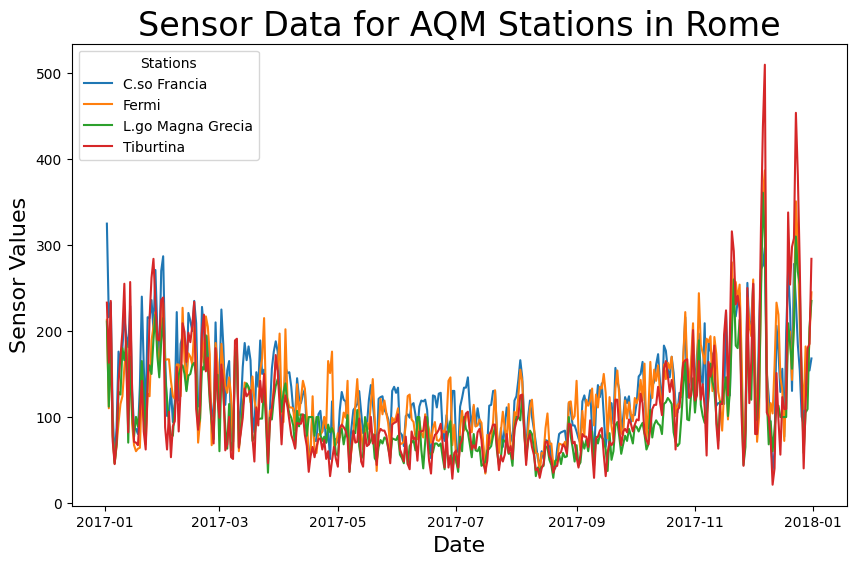

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop over the stations and plot
for city in rome_traffic_stations_dictionary:
    col_num = stations_dictionary_rome[city]['number']
    plt.plot(sensors_rome.date, sensors_rome[col_num], label=city)  # Add label for the legend

# Add title
plt.title("Sensor Data for AQM Stations in Rome", size=24)

# Add legend
plt.legend(title="Stations")  # The title inside the legend

# Optionally, add labels to the axes
plt.xlabel("Date", size=16)
plt.ylabel("Sensor Values", size=16)

# Show the plot
plt.show()


In [ ]:
for col in station_numbers:
  filtered_df = sensors_rome[col]
  # Count occurrences of the value 2 across the entire DataFrame
  count_in_df = (filtered_df.eq(-999)).sum().sum()
  print("Count of 2 in the entire DataFrame:", count_in_df)


Count of 2 in the entire DataFrame: 3
Count of 2 in the entire DataFrame: 7
Count of 2 in the entire DataFrame: 7
Count of 2 in the entire DataFrame: 9
Count of 2 in the entire DataFrame: 0
Count of 2 in the entire DataFrame: 2
Count of 2 in the entire DataFrame: 19
Count of 2 in the entire DataFrame: 15
Count of 2 in the entire DataFrame: 18
Count of 2 in the entire DataFrame: 4
Count of 2 in the entire DataFrame: 3


In [ ]:
import pandas as pd

# Define the station numbers you want to analyze
station_numbers = ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']

# Create a mapping from station number to station name
station_mapping = {
    '56': 'Arenula',
    '48': 'Bufalotta',
    '3': 'C.so Francia',
    '8': 'Cinecitta',
    '49': 'Cipro',
    '47': 'Fermi',
    '5': 'L.go Magna Grecia',
    '39': 'Villa Ada',
    '57': 'Malagrotta',
    '2': 'Preneste',
    '55': 'Tiburtina'
}

# Calculate the mean values and round to 1 decimal place
mean_values_selected_stations = sensors_rome[station_numbers].mean().round(1)

# Convert the result to a DataFrame with station names
mean_values_with_names = pd.DataFrame({
    'Station Name': [station_mapping[col] for col in mean_values_selected_stations.index],
    'Mean NOx': mean_values_selected_stations.values
})

# Display the DataFrame
print(mean_values_with_names)


         Station Name  Mean NOx
0             Arenula      71.2
1           Bufalotta      59.5
2        C.so Francia     130.2
3           Cinecitta      71.0
4               Cipro      78.8
5               Fermi     124.3
6   L.go Magna Grecia      99.8
7           Villa Ada      60.8
8          Malagrotta      28.9
9            Preneste      73.2
10          Tiburtina     109.2


### Before Imputation

In [ ]:
# city = 'rome'
# path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'
# df = pd.read_csv(path+'rome_simple_directed_network_emissions_38903_users.csv')
# # city_df = city_df[['week', 'week_start', 'road_link', 'CO_2']]

# total = df['CO_2'].sum()
# print(total)

# # Group NO2 data by week and take mean
# df = df.groupby(['road_link', 'week'], as_index=False)[['CO_2', 'NO_x']].sum()

# import ast
# # Convert string representation of tuples into actual tuples
# df['road_link'] = df['road_link'].apply(ast.literal_eval)

# # Now split the tuples into two columns
# df[['start_point', 'end_point', 'zero']] = pd.DataFrame(df['road_link'].tolist(), index=df.index)


# df = df[['week', 'start_point', 'end_point', 'road_link', 'CO_2', 'NO_x']]

# # Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
# start_of_year = pd.to_datetime('2017-01-01')
# # Calculate the start date of each week
# df['week_start'] = df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# # df = df[
# #     ~(
# #         ((df['week'] == 52) & (df['anno'] == 2017) & (df['date'].dt.month == 1)) |
# #         ((df['week'] == 1) & (df['anno'] == 2017) & (df['date'].dt.month == 12))
# #     )
# # ]


# print(len(df))
# df.head()

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'

df = pd.read_csv(path + 'rome_weekly_emissions_simple_undirected_network.csv')
df = df[df['CO_2']>0]

# Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
start_of_year = pd.to_datetime('2017-01-01')

# Calculate the start date of each week
df['week_start'] = df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
  week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
  month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
  return month_counts.idxmax()  # Return the month with the most days

# Map the week to the a month
df['month'] = df['week_start'].apply(get_majority_month)

# estimations_df = df.groupby(['start_point', 'end_point', 'month'])['CO_2'].mean().reset_index()
print(len(df))
df.head()

KeyboardInterrupt: 

In [ ]:
estimations_df = df.groupby(['start_point', 'end_point', 'month'])['CO_2'].sum().reset_index()
print(len(estimations_df))
estimations_df.head()

In [ ]:
# Calculate emissions around stations

# OK: Arenula, Bufalotta, Cipro, C.so Francia, Cinecitta, Fermi, L.go Magna Grecia, Villa Ada, Malagrotta, Preneste, Boncompagni, Tiburtina
# PROBLEM: Castel di Guido, Tenuta del Cavaliere (can't simplify)

# area = 'Tiburtina'

for area in stations_dictionary_rome:

    lat = stations_dictionary_rome[area]['lat']
    lon = stations_dictionary_rome[area]['lon']

    roads_around_point = get_road_segments(lat, lon, dist=200, network_type='drive_service',
                                  retain_all=True, truncate_by_edge=False, simplify=True)

    # Merge the two dataframes based on start_point and end_point
    monthly_estimations = roads_around_point.merge(estimations_df, on=['start_point','end_point'], how='inner')

    # Print the length of the merge dataframe
    print(f"No.: {monthly_estimations.shape[0]}")

    # Group by standardized start and end points and month, then sum CO_2/m
    df_grouped = monthly_estimations.groupby(['month']).agg({
    'CO_2': 'sum',
    }).reset_index()

    # Sort the DataFrame based on the 'date' column
    ts_monthly = df_grouped.sort_values(by='month')

    stations_dictionary_rome[area]['ts_weekly'] = ts_monthly
    print(f"Total amount of CO_2: {sum(ts_monthly['CO_2'])}")


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 105
No.: 229
Total amount of CO_2: 1233.0732054051373


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 81
No.: 146
Total amount of CO_2: 210.24662298261444


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 68
No.: 263
Total amount of CO_2: 922.5447667873242


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 39
No.: 114
Total amount of CO_2: 428.93619102082107


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 61
No.: 282
Total amount of CO_2: 819.5299597475359


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 93
No.: 445
Total amount of CO_2: 1418.7023093434204


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 54
No.: 270
Total amount of CO_2: 8241.250476505958


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Villa Ada: 10
No.: 35
Total amount of CO_2: 129.68453795314105


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Malagrotta: 42
No.: 108
Total amount of CO_2: 230.97025890325529


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 112
No.: 320
Total amount of CO_2: 975.9445762830368


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 54
No.: 201
Total amount of CO_2: 683.9174071688742


In [ ]:
# OK: Arenula, Bufalotta, Cipro, C.so Francia, Cinecitta, Fermi, L.go Magna Grecia, Villa Ada, Malagrotta, Preneste, Boncompagni, Tiburtina
# PROBLEM: Castel di Guido, Tenuta del Cavaliere (can't simplify)

# area = 'Tiburtina'

for area in stations_dictionary_rome:
    lat = stations_dictionary_rome[area]['lat']
    lon = stations_dictionary_rome[area]['lon']
    roads_around_point = get_road_segments(lat, lon, dist=200, network_type='drive_service',
                                  retain_all=True, truncate_by_edge=False, simplify=True)

    # Merge the two dataframes based on start_point and end_point
    weekly_estimations = roads_around_point.merge(df, on=['start_point','end_point'], how='inner')
    # Print the length of the merge dataframe
    print(f"No. of estimations: {weekly_estimations.shape[0]}")

    # Group by standardized start and end points and week, then sum CO_2 and NO_x
    df_grouped = weekly_estimations.groupby(['week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum'
    }).reset_index()

    # Sort the DataFrame based on the 'date' column
    ts_weekly = df_grouped.sort_values(by='week')

    # Function to determine month based on majority of days in the week
    def get_majority_month(week_start):
      week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
      month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
      return month_counts.idxmax()  # Return the month with the most days

    # Map the week to the a month
    ts_weekly['month'] = ts_weekly['week_start'].apply(get_majority_month)

    # Define the quarter based on the month
    ts_weekly['quarter'] = ts_weekly['month'].apply(lambda x: (x - 1) // 3 + 1)

    stations_dictionary_rome[area]['ts_weekly'] = ts_weekly
    print(f"Total amount of CO_2: {sum(ts_weekly['CO_2'])}")


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 105
No. of estimations: 379
Total amount of CO_2: 2483.869718359046


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 81
No. of estimations: 239
Total amount of CO_2: 355.11419808312473


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 68
No. of estimations: 624
Total amount of CO_2: 2822.824439123879


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 39
No. of estimations: 249
Total amount of CO_2: 992.1564312641369


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 61
No. of estimations: 673
Total amount of CO_2: 2389.238970381387


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 93
No. of estimations: 1036
Total amount of CO_2: 4620.556145380284


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 54
No. of estimations: 631
Total amount of CO_2: 29397.207577146644


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Villa Ada: 10
No. of estimations: 69
Total amount of CO_2: 257.28024954240743


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Malagrotta: 42
No. of estimations: 195
Total amount of CO_2: 465.885943371238


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 112
No. of estimations: 545
Total amount of CO_2: 1818.1721339984203


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 54
No. of estimations: 479
Total amount of CO_2: 1810.6087432610027


In [ ]:
# Copy ts_weekly to the smaller dictionaries
for area_name, info in stations_dictionary_rome.items():
    if area_name in rome_traffic_stations_dictionary:
        rome_traffic_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_background_stations_dictionary:
        rome_background_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_good_stations_dictionary:
        rome_good_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_bad_stations_dictionary:
        rome_bad_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']

# Check the results
# print("Rome Traffic Stations:", rome_traffic_stations_dictionary)

**All Stations**

In [ ]:
# all stations
results_by_quarter = calculate_correlations(sensors_rome, stations_dictionary_rome, time_period='quarter')
print(results_by_quarter)

Valid areas: ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']
    NOx_sensor        CO_2
0    90.542057   40.300069
4    75.353179    5.690662
8   162.418147   77.838003
12   96.618072   21.082082
16   95.539326   43.039675
20  139.587241   84.043843
24  125.112360  412.960604
28   72.364719    5.541304
32   35.322637   11.501545
36   87.800305   37.082968
40  136.035415   26.332507

    NOx_sensor        CO_2
1    45.923077   58.079993
5    36.549451    6.166730
9   103.831266   46.603110
13   38.956044   21.017790
17   52.956044   59.132636
21   97.816093   86.635830
25   77.210189  745.795556
29   52.828352    3.806029
33   17.491370    7.339355
37   42.582418   42.626869
41   71.670330   21.487241

    NOx_sensor         CO_2
2    45.505285    56.777609
6    35.048670     5.986737
10   95.678589    41.763227
14   39.097826    13.745429
18   44.521739    47.437966
22   91.826087    92.122479
26   65.219213  1046.999713
30   40.202609     6.411603
34   18.562116     7.9

In [ ]:
# all stations
results_by_month = calculate_correlations(sensors_rome, stations_dictionary_rome, time_period='month')
print(results_by_month)

Valid areas: ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']
     NOx_sensor       CO_2
0    108.874770  22.081643
12    85.400000   4.155281
24   181.566667  30.713776
36   109.333333   9.372351
48   110.400000  40.060402
60   133.900000  94.299644
72   138.666667  10.485169
84    90.700000   4.497465
96    41.996830   8.908419
108  103.333333  13.310871
120  159.800000  30.951907

     NOx_sensor       CO_2
1     86.428571  47.191805
13    78.944034   4.687741
25   162.043396  43.439281
37   101.785714  26.932059
49    93.964286  31.341828
61   155.928571  83.829847
73   132.142857  12.940890
85    72.529286   3.642009
97    37.035714  16.461293
109   90.250000  36.531765
121  139.433998  19.394731

     NOx_sensor         CO_2
2     76.516129    49.361422
14    62.387097     7.721305
26   144.225806   143.056362
38    79.645433    25.769885
50    82.580645    54.781371
62   130.331112    76.010399
74   105.645161  1054.956723
86    54.472258     7.895812
98    27.3164

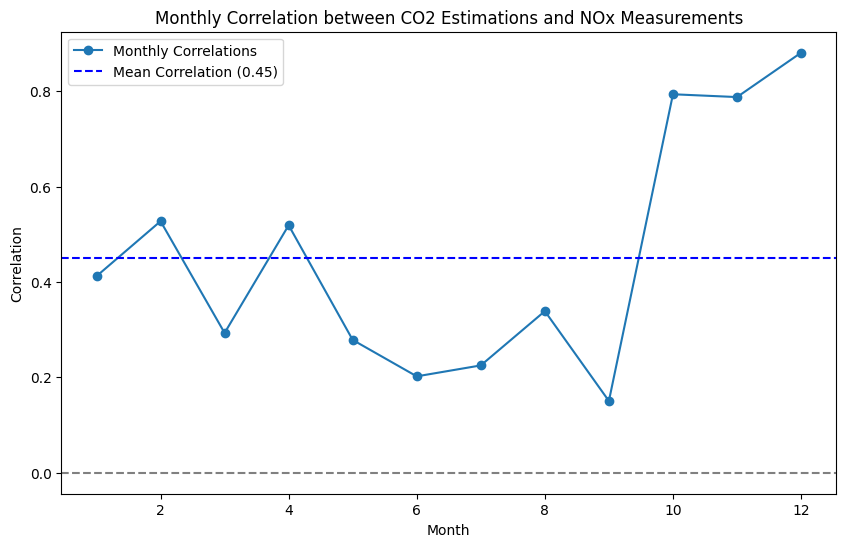

In [ ]:
import matplotlib.pyplot as plt

mean_correlation = results_by_month['correlation'].mean()

# plot for monthly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_month['month'], results_by_month['correlation'], marker='o', label='Monthly Correlations')
plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Monthly Correlation between CO2 Estimations and NOx Measurements')
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.legend()
plt.show()


In [ ]:
results_by_week = calculate_correlations(sensors_rome, stations_dictionary_rome, time_period='week')
# print(results_by_week)

Valid areas: ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']
     NOx_sensor       CO_2
0     96.000000   3.591696
52    71.428571   7.044466
103  170.285714  13.905432
155   87.571429   6.957482
206   98.857143  22.652493
258  117.714286  48.743292
310  118.285714   6.725007
362   74.714286   4.719906
406   31.142857   2.884301
458   91.000000  10.722867
510  137.000000  18.774027

     NOx_sensor        CO_2
1    115.142857    3.876374
53    82.000000    6.775782
104  185.000000   37.298174
156  139.857143    8.858589
207  117.571429   67.354123
259  144.000000  195.607857
311  143.142857   12.994797
363   84.857143    4.460339
407   39.714286   13.521638
459  117.000000   17.068881
511  179.000000   26.831999

     NOx_sensor       CO_2
2     79.891871  65.709041
54    44.857143   1.141875
105  127.428571  46.771740
157   52.428571  11.196746
208   60.285714  21.417314
260   78.857143  50.770935
312  106.142857  11.988688
364   62.142857   2.212000
408   22.129271   9

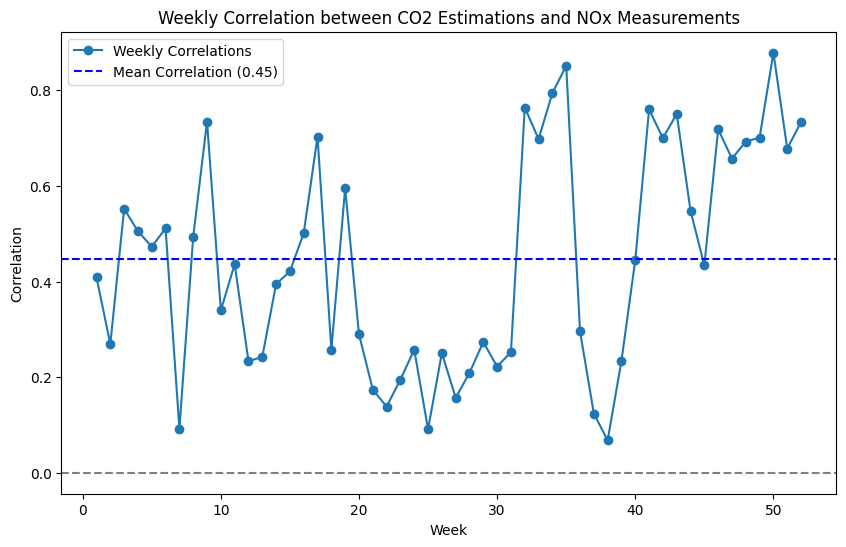

In [ ]:
import matplotlib.pyplot as plt

# the mean of the correlations
mean_correlation = results_by_week['correlation'].mean()

# the plot for weekly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_week['week'], results_by_week['correlation'], marker='o', label='Weekly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Weekly Correlation between CO2 Estimations and NOx Measurements')
plt.xlabel('Week')
plt.ylabel('Correlation')
plt.legend()
plt.show()


Filtered Results:
    week  correlation   p_value
0      1     0.408681  0.212048
1      2     0.269041  0.423714
2      3     0.552228  0.078153
3      4     0.505083  0.113034
4      5     0.472782  0.141946
5      6     0.511210  0.108020
6      7     0.091759  0.788451
7      8     0.493675  0.122766
8      9     0.734382  0.010062
9     10     0.339733  0.306695
10    11     0.436263  0.179776
11    12     0.233660  0.489251
12    13     0.241951  0.473507
13    14     0.394695  0.229638
34    35     0.851165  0.001787
35    36     0.295919  0.406446
36    37     0.123856  0.716740
37    38     0.067751  0.843103
38    39     0.233892  0.488806
39    40     0.445039  0.170179
40    41     0.759963  0.006643
41    42     0.699803  0.016514
42    43     0.750627  0.007772
43    44     0.547805  0.081071
44    45     0.433785  0.182545
45    46     0.718375  0.012764
46    47     0.657141  0.028020
47    48     0.692775  0.018121
48    49     0.701135  0.016222
49    50     0.878591 

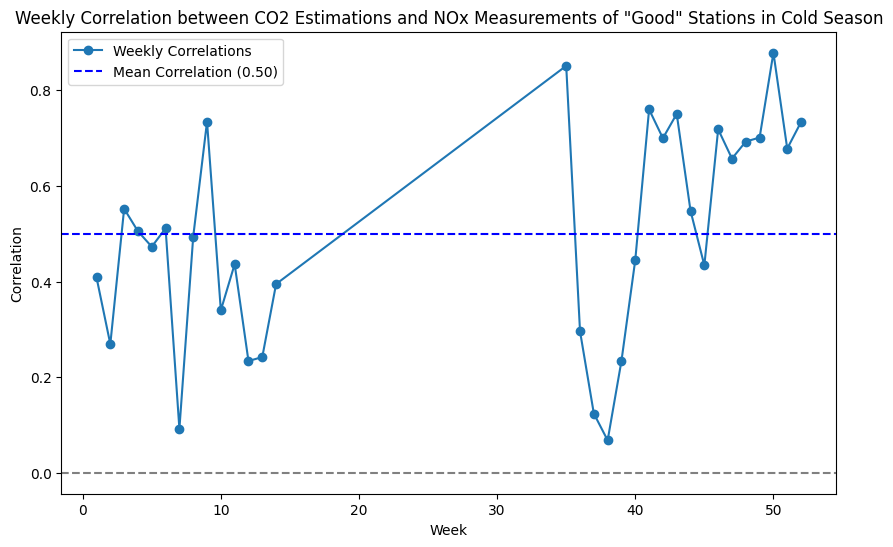

In [ ]:
import matplotlib.pyplot as plt

# Assuming results_by_week is a DataFrame
cold_season_results_by_week = results_by_week[~results_by_week['week'].between(15, 34)]

# Filter out weeks 15-34 from the already defined results_by_week_good_stations
cold_season_results_by_week = results_by_week[~results_by_week['week'].between(15, 34)]

# Print the filtered results to verify
print("Filtered Results:")
print(cold_season_results_by_week)

# Calculate the mean of the correlations for the filtered data
mean_correlation = cold_season_results_by_week['correlation'].mean()

# Create the plot for weekly correlations
plt.figure(figsize=(10, 6))

plt.plot(cold_season_results_by_week['week'],
         cold_season_results_by_week['correlation'],
         marker='o', label='Weekly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Weekly Correlation between CO2 Estimations and NOx Measurements of "Good" Stations in Cold Season')
plt.xlabel('Week')
plt.ylabel('Correlation')
plt.legend()
plt.show()


**Good Stations**

In [ ]:
# good stations
results_by_quarter_good_stations = calculate_correlations(sensors_rome, rome_good_stations_dictionary, time_period='quarter')
print(results_by_quarter_good_stations)

Valid areas: ['48', '3', '8', '47', '5', '39', '57', '2', '55']
   quarter  correlation   p_value
0        1     0.373360  0.322304
1        2     0.297763  0.436452
2        3     0.199897  0.606090
3        4     0.897421  0.001028


In [ ]:
# good stations
results_by_month_good_stations = calculate_correlations(sensors_rome, rome_good_stations_dictionary, time_period='month')
print(results_by_month_good_stations)

Valid areas: ['48', '3', '8', '47', '5', '39', '57', '2', '55']
    NOx_sensor       CO_2
0    85.400000   4.155281
12  181.566667  30.713776
24  109.333333   9.372351
36  133.900000  94.299644
48  138.666667  10.485169
60   90.700000   4.497465
72   41.996830   8.908419
84  103.333333  13.310871
96  159.800000  30.951907

    NOx_sensor       CO_2
1    78.944034   4.687741
13  162.043396  43.439281
25  101.785714  26.932059
37  155.928571  83.829847
49  132.142857  12.940890
61   72.529286   3.642009
73   37.035714  16.461293
85   90.250000  36.531765
97  139.433998  19.394731

    NOx_sensor         CO_2
2    62.387097     7.721305
14  144.225806   143.056362
26   79.645433    25.769885
38  130.331112    76.010399
50  105.645161  1054.956723
62   54.472258     7.895812
74   27.316445     9.608247
86   70.555714    56.541607
98  109.967742    28.187206

    NOx_sensor        CO_2
3    42.533333    4.536491
15  102.933333   49.831205
27   48.833333   49.607368
39  109.366667  118.42620

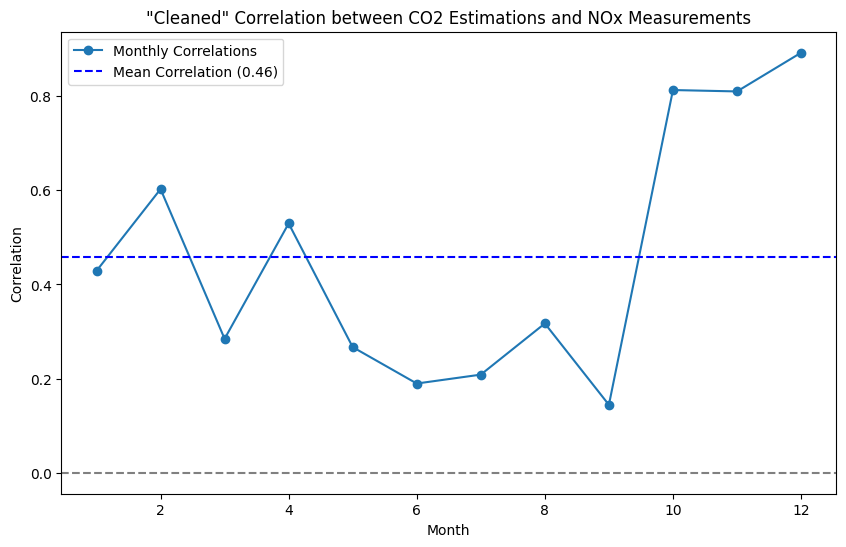

In [ ]:
import matplotlib.pyplot as plt

mean_correlation = results_by_month_good_stations['correlation'].mean()

# plot for monthly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_month_good_stations['month'], results_by_month_good_stations['correlation'], marker='o', label='Monthly Correlations')
plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('"Cleaned" Correlation between CO2 Estimations and NOx Measurements')
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.legend()
plt.show()


In [ ]:
results_by_week_good_stations = calculate_correlations(sensors_rome, rome_good_stations_dictionary, time_period='week')
# print(results_by_week_good_stations)

Valid areas: ['48', '3', '8', '47', '5', '39', '57', '2', '55']


KeyError: 'week'

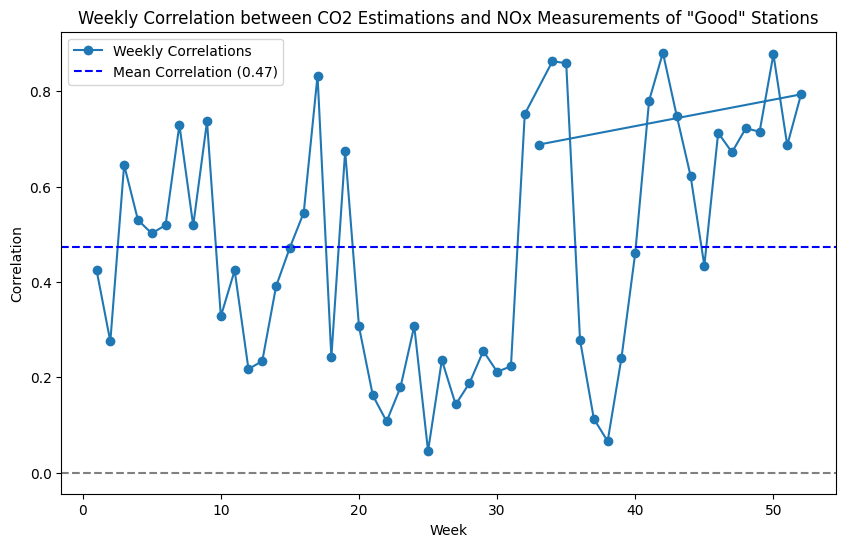

In [ ]:
import matplotlib.pyplot as plt

# the mean of the correlations
mean_correlation = results_by_week_good_stations['correlation'].mean()

# the plot for weekly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_week_good_stations['week'], results_by_week_good_stations['correlation'], marker='o', label='Weekly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Weekly Correlation between CO2 Estimations and NOx Measurements of "Good" Stations')
plt.xlabel('Week')
plt.ylabel('Correlation')
plt.legend()
plt.show()

# week 31 has a negative value of -0.026

**Traffic Stations**

In [ ]:
# traffic stations
results_by_quarter_traffic_stations = calculate_correlations(sensors_rome, rome_traffic_stations_dictionary, time_period='quarter')
print(results_by_quarter_traffic_stations)

Valid areas: ['3', '47', '5', '55']
   quarter  correlation   p_value
0        1    -0.602394  0.397606
1        2    -0.397756  0.602244
2        3    -0.640624  0.359376
3        4     0.566400  0.433600


In [ ]:
# traffic stations
results_by_month_traffic_stations = calculate_correlations(sensors_rome, rome_traffic_stations_dictionary, time_period='month')
print(results_by_month_traffic_stations)

Valid areas: ['3', '47', '5', '55']
    month  correlation   p_value
0       1    -0.395608  0.604392
1       2     0.745697  0.254303
2       3    -0.548415  0.451585
3       4     0.158412  0.841588
4       5    -0.525775  0.474225
5       6    -0.565249  0.434751
6       7    -0.646009  0.353991
7       8    -0.592140  0.407860
8       9    -0.618582  0.381418
9      10     0.677448  0.322552
10     11     0.106735  0.893265
11     12     0.925458  0.074542


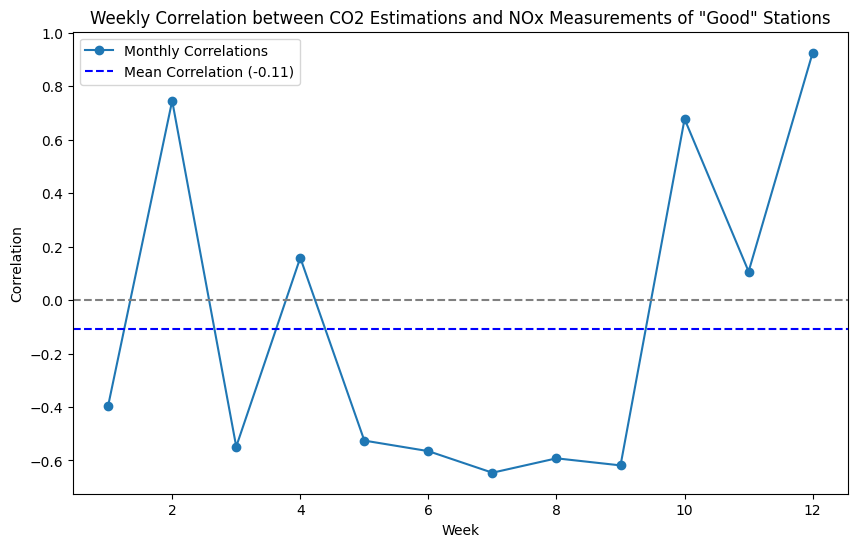

In [ ]:
import matplotlib.pyplot as plt

# the mean of the correlations
mean_correlation = results_by_month_traffic_stations['correlation'].mean()

# the plot for weekly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_month_traffic_stations['month'], results_by_month_traffic_stations['correlation'], marker='o', label='Monthly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Weekly Correlation between CO2 Estimations and NOx Measurements of "Good" Stations')
plt.xlabel('Week')
plt.ylabel('Correlation')
plt.legend()
plt.show()

# week 31 has a negative value of -0.026

--------------------------------------------
Time Series Correlation

Correlation coefficient between Model and Sensor (weekly, Arenula): -0.04


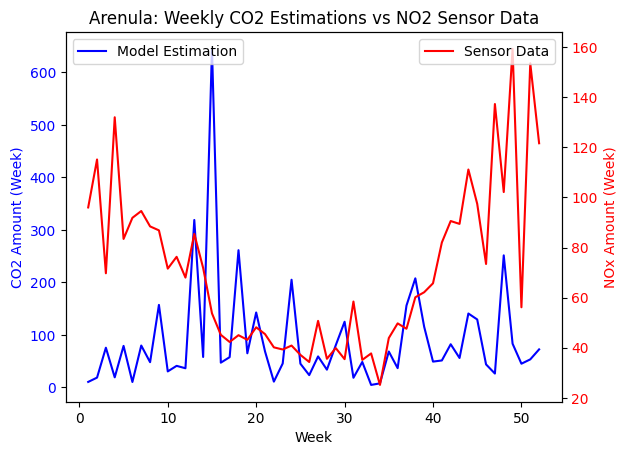


Correlation coefficient between Model and Sensor (weekly, Bufalotta): 0.04


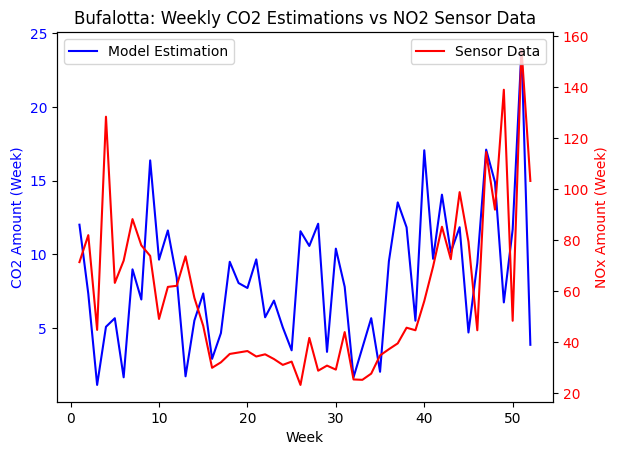


Correlation coefficient between Model and Sensor (weekly, C.so Francia): 0.06


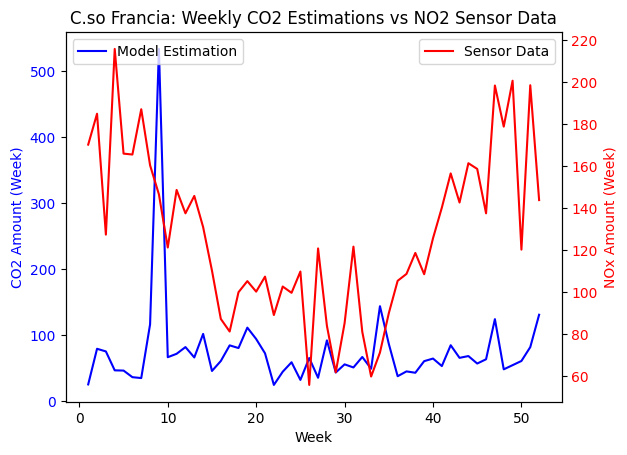


Correlation coefficient between Model and Sensor (weekly, Cinecitta): 0.10


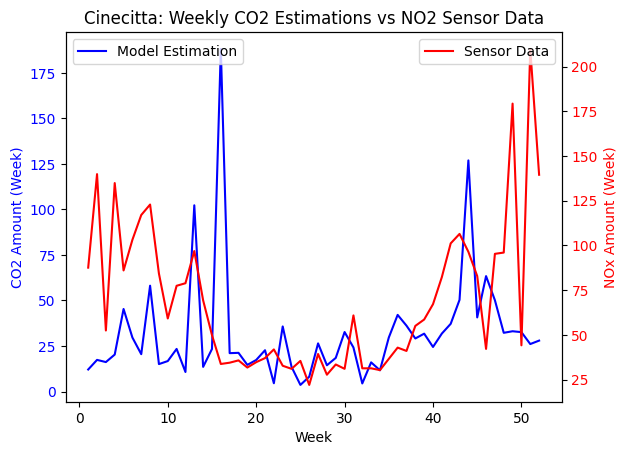


Correlation coefficient between Model and Sensor (weekly, Cipro): -0.18


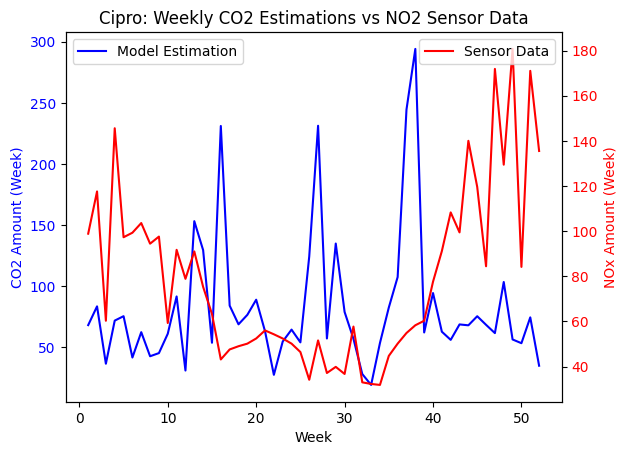


Correlation coefficient between Model and Sensor (weekly, Fermi): 0.05


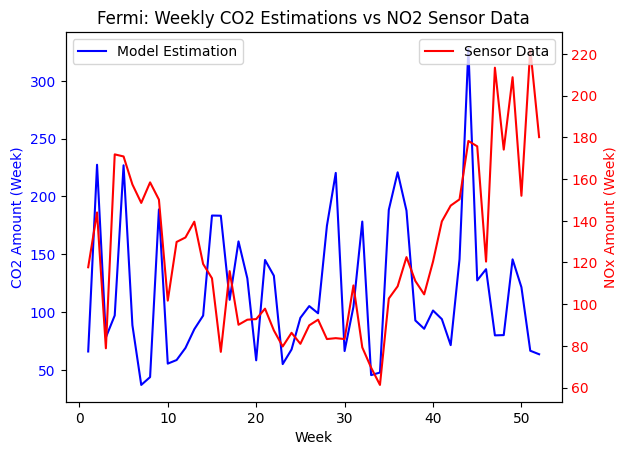


Correlation coefficient between Model and Sensor (weekly, L.go Magna Grecia): -0.33


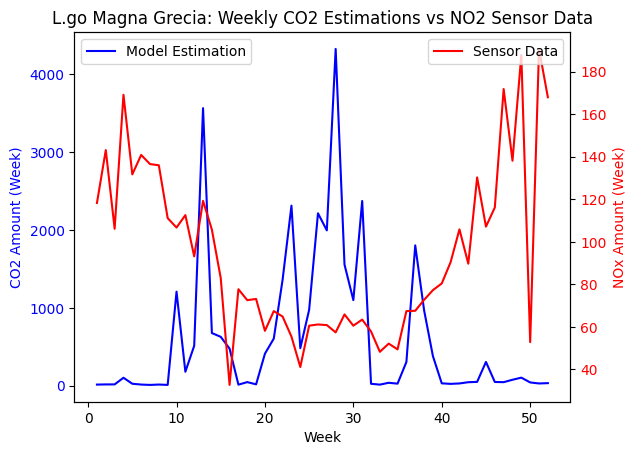


Correlation coefficient between Model and Sensor (weekly, Villa Ada): 0.15


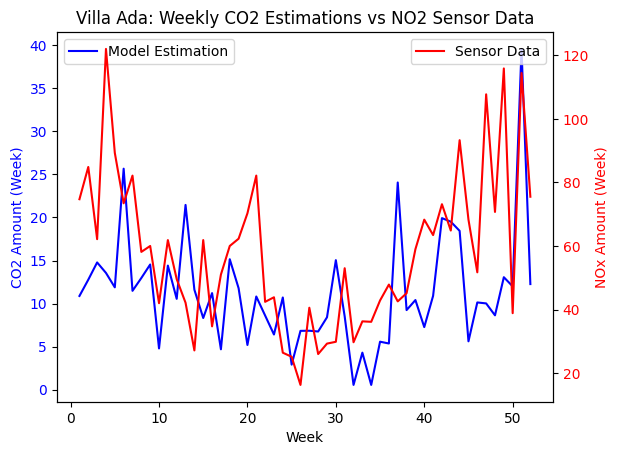


Correlation coefficient between Model and Sensor (weekly, Malagrotta): 0.38


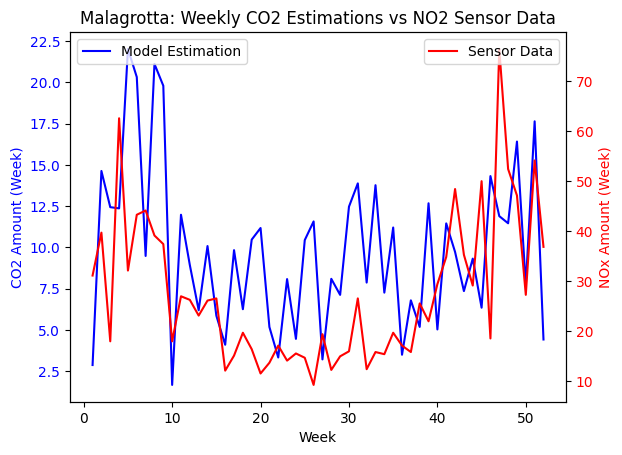


Correlation coefficient between Model and Sensor (weekly, Preneste): -0.18


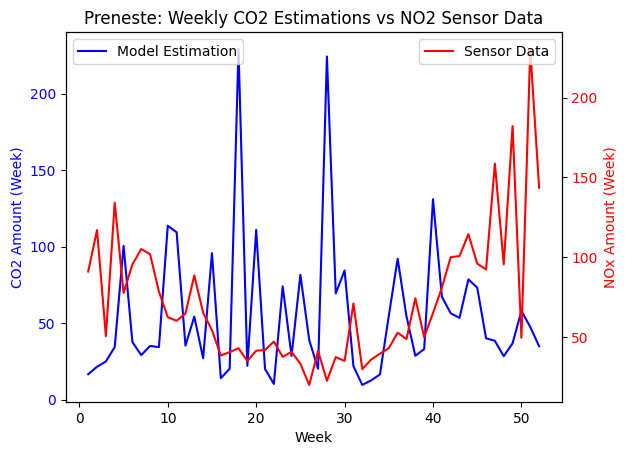


Correlation coefficient between Model and Sensor (weekly, Tiburtina): 0.46


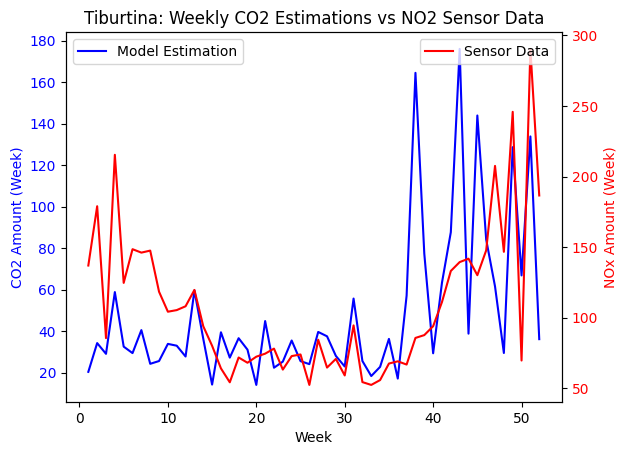


Mean Correlation across all areas: 0.045


In [ ]:
correlation_results_weekly = []

for area in stations_dictionary_rome:
  col_num = stations_dictionary_rome[area]['number']

  ts_co2_weekly_estimation = stations_dictionary_rome[area]['ts_weekly']

  # Group sensor emissions by week and take the mean
  ts_nox_weekly_sensor = sensors_rome.groupby(['week'])[col_num].mean().reset_index()

  correlation = plot_pollutant_correlation(ts_co2_weekly_estimation, ts_nox_weekly_sensor, no2_col=col_num, time_period='week', area_name=area)

  # Append the correlation result to the list
  correlation_results_weekly.append(correlation)

# Calculate the mean correlation
mean_correlation_weekly = sum(correlation_results_weekly) / len(correlation_results_weekly)

# Display the mean correlation result
print(f'Mean Correlation across all areas: {mean_correlation_weekly:.3f}')

Correlation coefficient between Model and Sensor (monthly, Arenula): -0.24


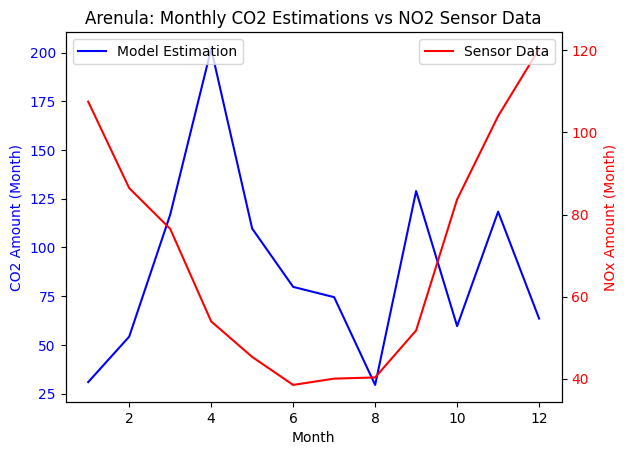


Correlation coefficient between Model and Sensor (monthly, Bufalotta): 0.47


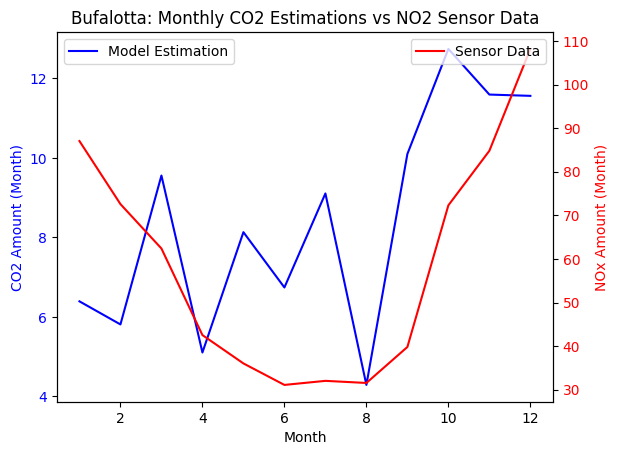


Correlation coefficient between Model and Sensor (monthly, C.so Francia): 0.17


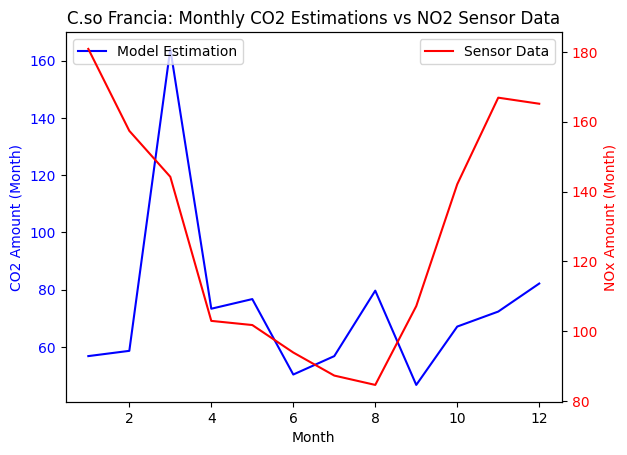


Correlation coefficient between Model and Sensor (monthly, Cinecitta): 0.16


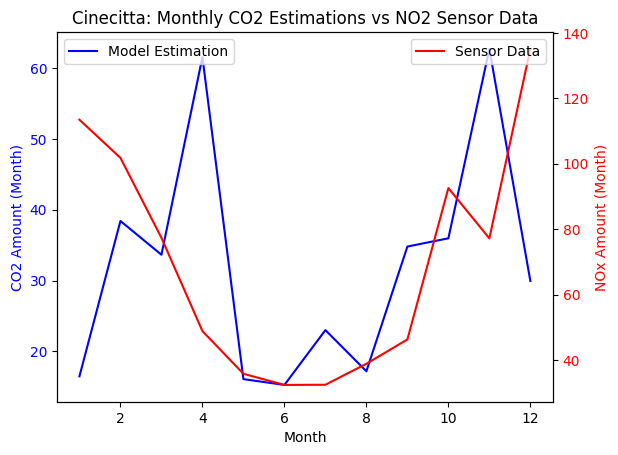


Correlation coefficient between Model and Sensor (monthly, Cipro): -0.42


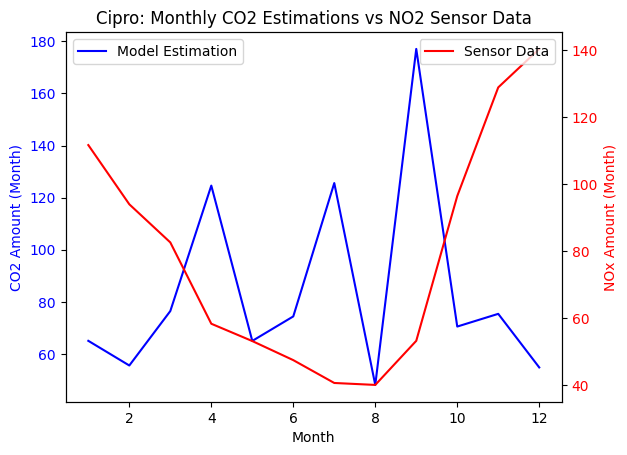


Correlation coefficient between Model and Sensor (monthly, Fermi): -0.09


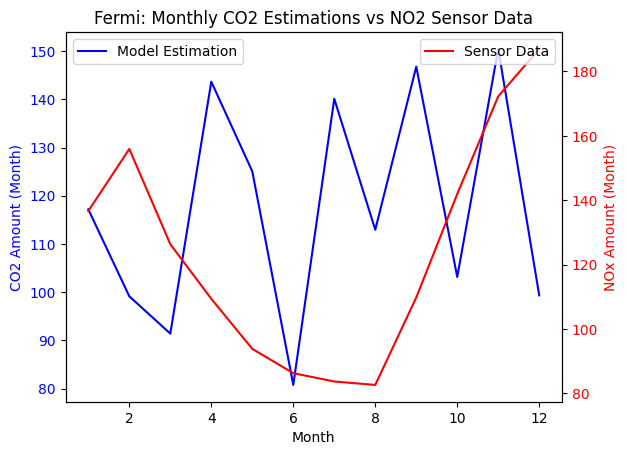


Correlation coefficient between Model and Sensor (monthly, L.go Magna Grecia): -0.65


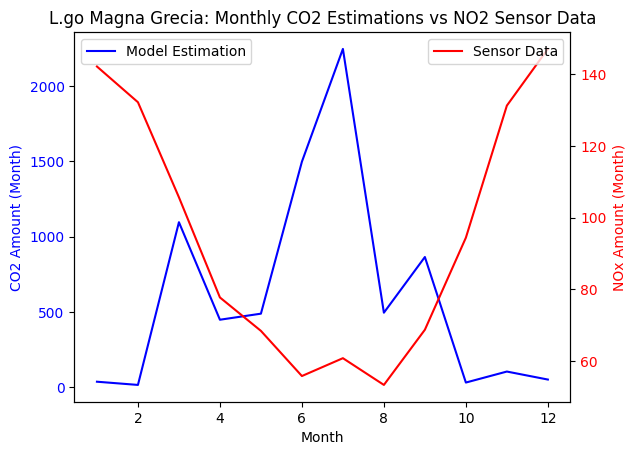


Correlation coefficient between Model and Sensor (monthly, Villa Ada): 0.71


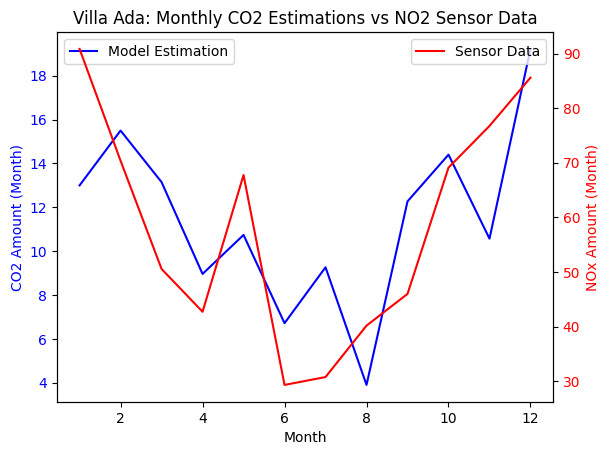


Correlation coefficient between Model and Sensor (monthly, Malagrotta): 0.55


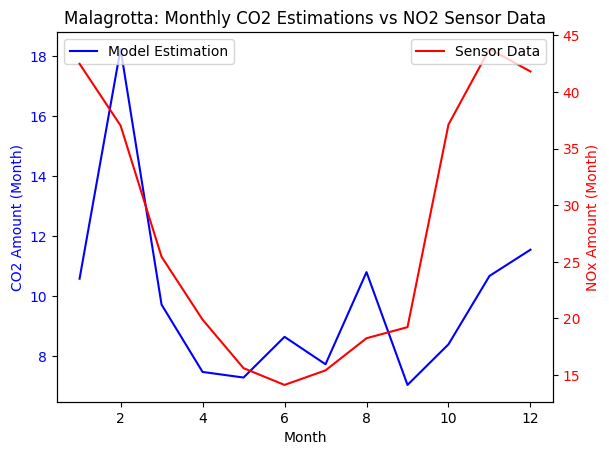


Correlation coefficient between Model and Sensor (monthly, Preneste): -0.33


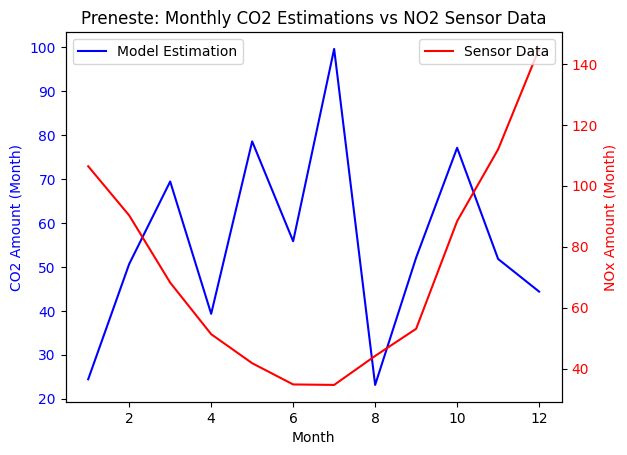


Correlation coefficient between Model and Sensor (monthly, Tiburtina): 0.51


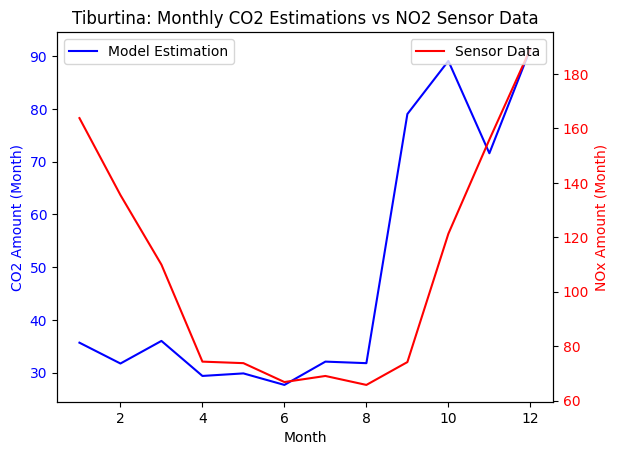


Mean Correlation across all areas: 0.076


In [ ]:
correlation_results_monthly = []

for area in stations_dictionary_rome:
  col_num = stations_dictionary_rome[area]['number']

  ts_co2_weekly_estimation = stations_dictionary_rome[area]['ts_weekly']

  # Group sensor emissions by week and take the mean
  ts_nox_monthly_sensor = sensors_rome.groupby(['month'])[col_num].mean().reset_index()

  correlation = plot_pollutant_correlation(ts_co2_weekly_estimation, ts_nox_monthly_sensor, no2_col=col_num, time_period='month', area_name=area)

  # Append the correlation result to the list
  correlation_results_monthly.append(correlation)


# Calculate the mean correlation
mean_correlation_monthly = sum(correlation_results_monthly) / len(correlation_results_monthly)

# Display the mean correlation result
print(f'Mean Correlation across all areas: {mean_correlation_monthly:.3f}')

Correlation coefficient between Model and Sensor (quarterly, Arenula): -0.46


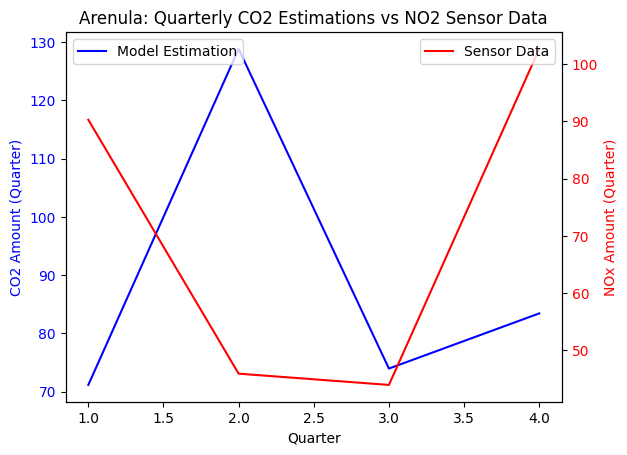


Correlation coefficient between Model and Sensor (quarterly, Bufalotta): 0.74


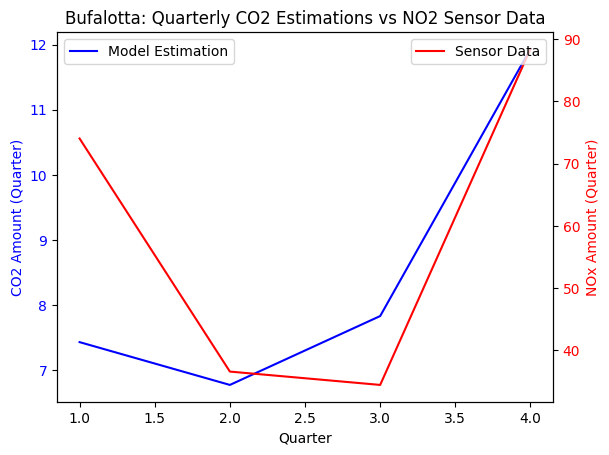


Correlation coefficient between Model and Sensor (quarterly, C.so Francia): 0.79


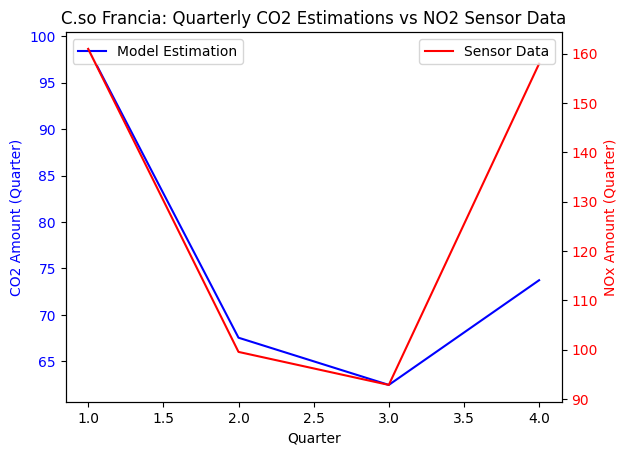


Correlation coefficient between Model and Sensor (quarterly, Cinecitta): 0.71


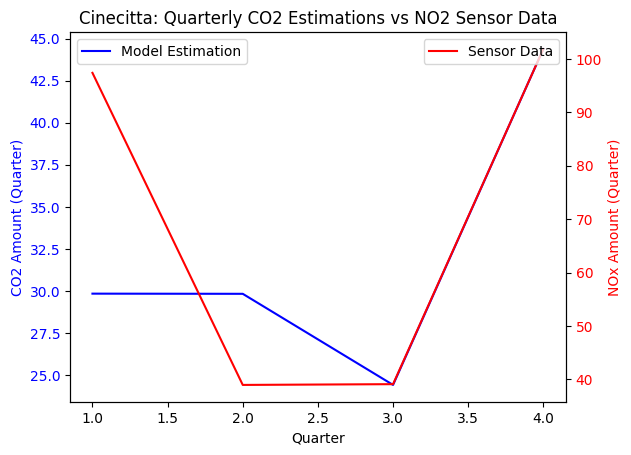


Correlation coefficient between Model and Sensor (quarterly, Cipro): -0.87


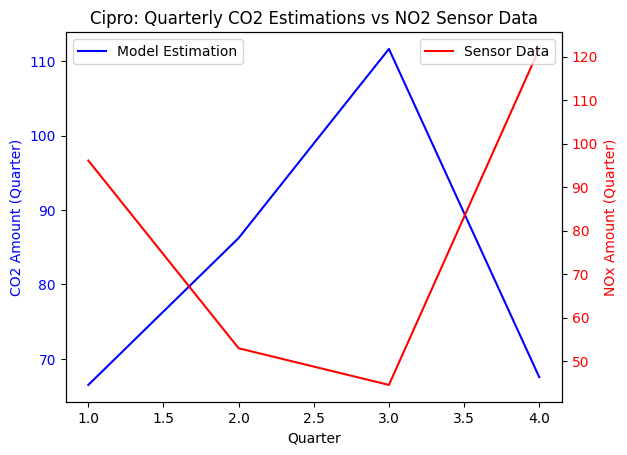


Correlation coefficient between Model and Sensor (quarterly, Fermi): -0.43


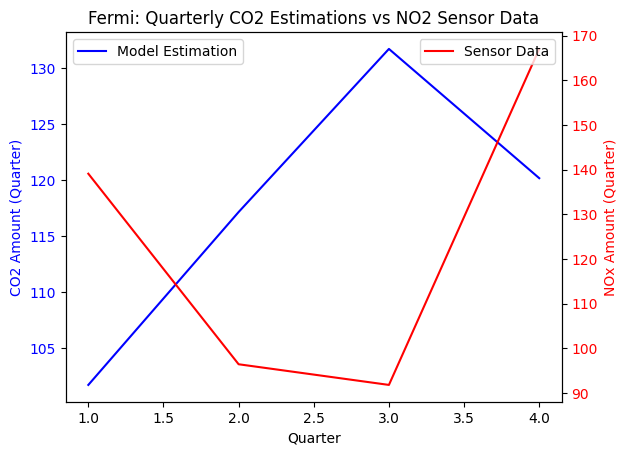


Correlation coefficient between Model and Sensor (quarterly, L.go Magna Grecia): -0.90


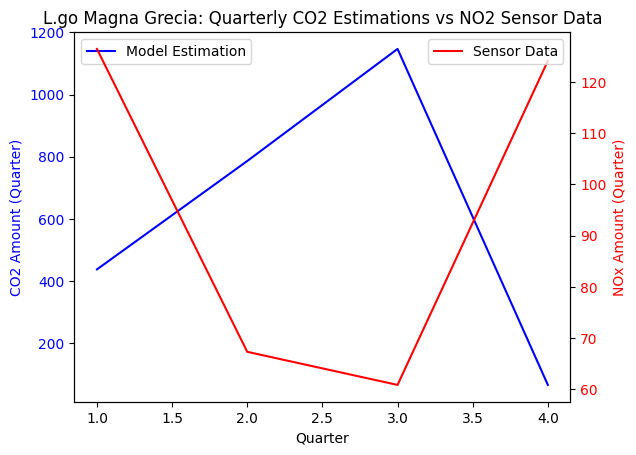


Correlation coefficient between Model and Sensor (quarterly, Villa Ada): 0.99


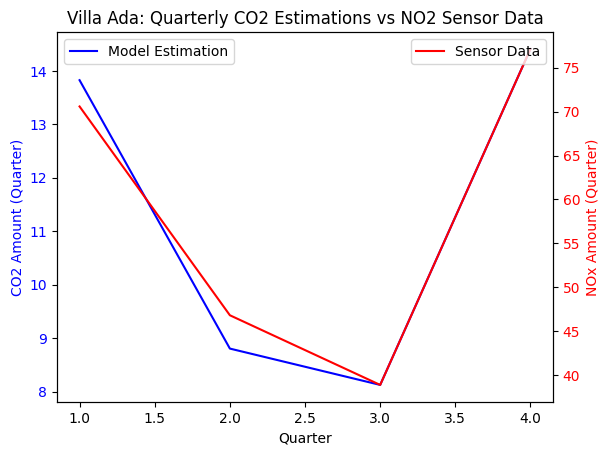


Correlation coefficient between Model and Sensor (quarterly, Malagrotta): 0.77


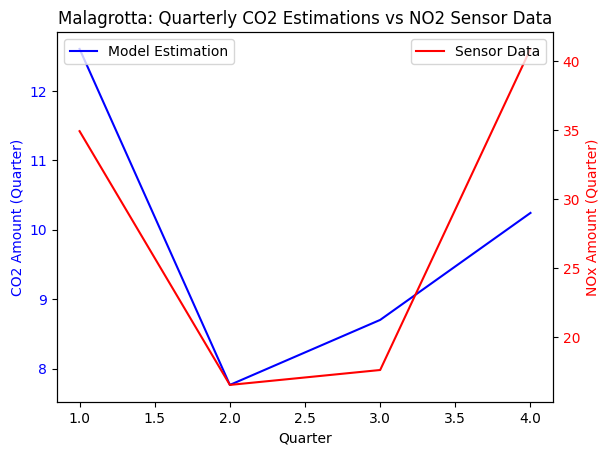


Correlation coefficient between Model and Sensor (quarterly, Preneste): -0.30


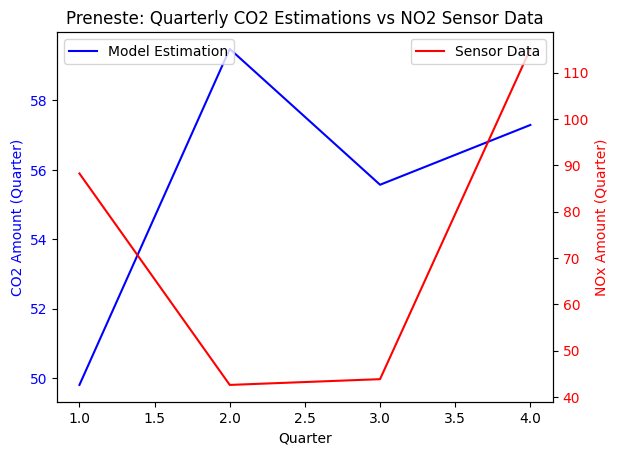


Correlation coefficient between Model and Sensor (quarterly, Tiburtina): 0.63


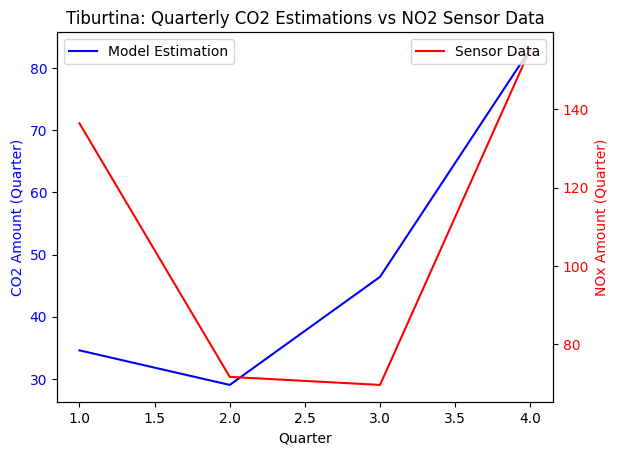


Mean Correlation across all areas: 0.152


In [ ]:
correlation_results_quarterly = []

for area in stations_dictionary_rome:
  col_num = stations_dictionary_rome[area]['number']

  ts_co2_weekly_estimation = stations_dictionary_rome[area]['ts_weekly']

  # Group sensor emissions by week and take the mean
  ts_nox_quarterly_sensor = sensors_rome.groupby(['quarter'])[col_num].mean().reset_index()

  correlation = plot_pollutant_correlation(ts_co2_weekly_estimation, ts_nox_quarterly_sensor, no2_col=col_num, time_period='quarter', area_name=area)

  # Append the correlation result to the list
  correlation_results_quarterly.append(correlation)


# Calculate the mean correlation
mean_correlation_quarterly = sum(correlation_results_quarterly) / len(correlation_results_quarterly)

# Display the mean correlation result
print(f'Mean Correlation across all areas: {mean_correlation_quarterly:.3f}')

In [ ]:
# # prompt: Using dataframe roads_borghetto: import and emission dataset and merge with roads_borghetto based on start and end points

# # Assuming you have a dataframe named 'emission' with columns 'start_point' and 'end_point'
# # Replace 'emission' with your actual dataframe name

# # Merge the two dataframes based on start_point and end_point
# weekly_estimations = road_data.merge(df, on=['start_point','end_point'], how='inner')

# # Print the resulting dataframe
# # merged_df['CO_2'] = merged_df['CO_2'] * road_segments['length']
# print(f"No.: {weekly_estimations.shape[0]}")

# # Group by standardized start and end points and week, then sum CO_2 and NO_x
# df_grouped = weekly_estimations.groupby(['week', 'week_start']).agg({
#     'CO_2': 'sum',
#     'NO_x': 'sum'
# }).reset_index()

# # Sort the DataFrame based on the 'date' column
# ts_weekly = df_grouped.sort_values(by='week')

# ts_weekly

In [ ]:
# df_sorted_cipro.loc[(df_sorted_cipro['week'] == 37.0) & (df_sorted_cipro['CO_2'].round(6) == 500.990763), 'CO_2'] = 300
# df_sorted_cipro.loc[(df_sorted_cipro['week'] == 38.0) & (df_sorted_cipro['CO_2'].round(6) == 827.619086), 'CO_2'] = 250
# # df_sorted_cipro

In [ ]:
# from datetime import timedelta

# # Convert 'week_start' to datetime format
# # df_sorted_cipro['week_start'] = pd.to_datetime(df_sorted_passi['week_start'])

# # Function to determine month based on majority of days in the week
# def get_majority_month(week_start):
#     week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
#     month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
#     return month_counts.idxmax()  # Return the month with the most days

# # Apply the functions to the df_sorted_passi DataFrame
# ts_weekly['month'] = ts_weekly['week_start'].apply(get_majority_month)

# # Define quarter based on the month
# ts_weekly['quarter'] = ts_weekly['month'].apply(lambda x: (x - 1) // 3 + 1)

# ts_weekly.head()

### After Imputation

Preprocessing Model Estimations Data

In [ ]:
city = 'rome'
estimation_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'
imputation_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/xgb_xgb'


In [ ]:
weekly_carbon_df = pd.read_csv(estimation_path + 'rome_weekly_emissions_simple_undirected_network.csv')
weekly_carbon_df = weekly_carbon_df[weekly_carbon_df['CO_2']>0]
# Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
start_of_year = pd.to_datetime('2017-01-01')
# Calculate the start date of each week
weekly_carbon_df['week_start'] = weekly_carbon_df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
  week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
  month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
  return month_counts.idxmax()  # Return the month with the most days

# Map the week to the a month
weekly_carbon_df['month'] = weekly_carbon_df['week_start'].apply(get_majority_month)

estimations_df = weekly_carbon_df.groupby(['start_point', 'end_point', 'month'])['CO_2'].mean().reset_index()
print(len(estimations_df))
estimations_df.head()

534720


start_point  end_point  month      CO_2
0     21637960  347298638      1  2.972954
1     21637960  347298638      2  4.733936
2     21637960  347298638      3  4.170370
3     21637960  347298638      4  3.140286
4     21637960  347298638      5  1.315579

In [ ]:
estimations_df = weekly_carbon_df.groupby(['start_point', 'end_point', 'month'])['CO_2'].mean().reset_index()
print(len(estimations_df))
estimations_df.head()

534720


start_point  end_point  month      CO_2
0     21637960  347298638      1  2.972954
1     21637960  347298638      2  4.733936
2     21637960  347298638      3  4.170370
3     21637960  347298638      4  3.140286
4     21637960  347298638      5  1.315579

In [ ]:
import glob

# Step 1: Create a list of Excel file paths
file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/xgb_xgb/rome/*.csv')  # Adjust the path to your Excel files

# Step 2: Read each Excel file into a DataFrame and store them in a list
dataframes = [pd.read_csv(file) for file in file_paths]

# Step 3: Concatenate all DataFrames into one
imputation_df = pd.concat(dataframes, ignore_index=True)[['start_point', 'end_point', 'month', 'CO_2_imputed']]

# View the combined DataFrame
print(len(imputation_df))
imputation_df.head()


612864


start_point   end_point  month  CO_2_imputed
0     21637971  4246023914      1      1.772756
1     21638011   366164457      1      0.814067
2     21638011   370042353      1      1.548495
3     21638030   388127379      1      1.071361
4     21638030   388127383      1      1.132339

In [ ]:
imputation_df = imputation_df.rename(columns={'CO_2_imputed':'CO_2'})

In [ ]:
imputation_df.columns

Index(['start_point', 'end_point', 'month', 'CO_2'], dtype='object')

In [ ]:
# # Step 1: Create a set of (start_point, end_point) pairs from df1 (original values)
# df1_pairs = set(zip(estimations_df['start_point'], estimations_df['end_point']))

# # Step 2: Create a set of (start_point, end_point) pairs from df2 (imputed values)
# df2_pairs = set(zip(imputation_df['start_point'], imputation_df['end_point']))

# # Step 3: Find the difference (pairs in df2 that are not in df1)
# unique_pairs_in_df2 = df2_pairs - df1_pairs

# # Step 4: Filter df2 to keep only rows with unique (start_point, end_point) pairs
# df2_unique = imputation_df[imputation_df.apply(lambda row: (row['start_point'], row['end_point']) in unique_pairs_in_df2, axis=1)]

# # View the filtered DataFrame
# print(len(df2_unique))
# df2_unique.head()


In [ ]:
import pandas as pd
from scipy import stats

def calculate_monthly_correlations(sensor_df, stations_dict):
    """
    This function calculates Pearson correlation coefficients between aggregated monthly CO2 estimations
    and NOx sensor data for multiple areas.

    Parameters:
    sensor_df (pd.DataFrame): DataFrame containing NOx sensor data for multiple areas.
    stations_dict (dict): Dictionary containing model estimations (ts_weekly) for different areas.

    Returns:
    pd.DataFrame: A DataFrame containing the correlations and p-values for each month.
    """

    # Ensure the 'month' column is numeric in sensor_df
    if not pd.api.types.is_numeric_dtype(sensor_df['month']):
        sensor_df['month'] = sensor_df['month'].astype(int)

    # Extract the area numbers from the stations dictionary that exist in both sensor_df and stations_dict
    valid_areas = [info['number'] for info in stations_dict.values() if info['number'] in sensor_df.columns]
    print("Valid areas:", valid_areas)

    # Prepare an empty list to store all model data
    model_data_list = []

    # Loop over each area in the stations dictionary to collect model data (ts_weekly)
    for station_name, info in stations_dict.items():
        area_number = info['number']
        ts_weekly = info.get('ts_weekly')  # Assuming weekly estimates are stored in 'ts_weekly'

        if ts_weekly is not None:
            # Add the area column to the ts_weekly DataFrame for merging
            ts_weekly['area'] = area_number
            model_data_list.append(ts_weekly)

    # Combine all model data into a single DataFrame
    model_df = pd.concat(model_data_list, ignore_index=True)

    # Aggregate weekly data to monthly using the mean
    model_df = model_df.groupby(['area', 'month']).sum('CO_2').reset_index()

    # Aggregate the sensor data by month using the mean
    sensor_df_agg = sensor_df.groupby('month').mean().reset_index()

    # Reshape the sensor data to long format using only the valid areas
    sensor_long = pd.melt(sensor_df_agg, id_vars=['month'], value_vars=valid_areas,
                          var_name='area', value_name='NOx_sensor')

    # Merge sensor and model data by 'month' and 'area'
    merged_df = pd.merge(sensor_long, model_df, on=['month', 'area'], suffixes=('_sensor', '_model'))

    # Create a DataFrame to store correlation results
    results = []

    # Loop through each month and calculate correlation
    for month in merged_df['month'].unique():
        month_data = merged_df[merged_df['month'] == month]

        # Check for sufficient data to compute correlation (need at least 2 points)
        if len(month_data) > 1:
            # Drop rows with NaN values in either 'NOx_sensor' or 'CO_2'
            month_data_clean = month_data[['NOx_sensor', 'CO_2']].dropna()

            # Ensure there are still at least 2 data points after dropping NaNs
            if len(month_data_clean) > 1:
                y_values = month_data_clean['NOx_sensor']  # Sensor measurements (y-axis)
                x_values = month_data_clean['CO_2']        # Model estimations (x-axis)

                # print(month_data_clean)
                # print()
                # Calculate Pearson correlation
                correlation, p_value = stats.pearsonr(x_values, y_values)
            else:
                correlation, p_value = None, None  # Insufficient data after removing NaNs
        else:
            correlation, p_value = None, None  # Insufficient data for correlation

        # Store the results
        results.append({
            'month': month,
            'correlation': correlation,
            'p_value': p_value
        })

    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)

    # Return the correlation results
    return results_df


In [ ]:
# try different factors for imputation_df

import matplotlib.pyplot as plt
# 115 m [0.4759088549850022, 0.45394090516701513, 0.4507907993131309, 0.4366636332819452, 0.4204624085590671, 0.36984963863081416]
# 80 m  [0.48747153545202654, 0.45370941790696917, 0.449035723628151, 0.4280537739312292, 0.4038604047062028, 0.3287108038392716]

correlations = list()
for factor in [-1, 0, 0.1, 0.5, 0.9, 2]:
  imputation_df = pd.concat(dataframes, ignore_index=True)[['start_point', 'end_point', 'month', 'CO_2_imputed']]
  imputation_df = imputation_df.rename(columns={'CO_2_imputed':'CO_2'})
  imputation_df['CO_2'] = factor * imputation_df['CO_2']
  print(imputation_df['CO_2'].head(1))
  print()
  # Concatenate imputation_df and estimations_df row by row (row-wise)
  combined_df = pd.concat([imputation_df, estimations_df], axis=0, ignore_index=True)
  grouped_combined_df = combined_df.groupby(['start_point', 'end_point', 'month'])['CO_2'].sum().reset_index()

  for area in stations_dictionary_rome:

    lat = stations_dictionary_rome[area]['lat']
    lon = stations_dictionary_rome[area]['lon']

    roads_around_point = get_road_segments(lat, lon, dist=80, network_type='drive_service',
                                  retain_all=False, truncate_by_edge=True, simplify=True)

    # Merge the two dataframes based on start_point and end_point
    monthly_estimations = roads_around_point.merge(grouped_combined_df, on=['start_point','end_point'], how='inner')

    # Print the length of the merge dataframe
    print(f"No.: {monthly_estimations.shape[0]}")

    # Group by standardized start and end points and month, then sum CO_2/m
    df_grouped = monthly_estimations.groupby(['month']).agg({
    'CO_2': 'sum',
    }).reset_index()

    # Sort the DataFrame based on the 'date' column
    ts_monthly = df_grouped.sort_values(by='month')

    stations_dictionary_rome[area]['ts_weekly'] = ts_monthly
    # print(f"Total amount of CO_2: {sum(ts_monthly['CO_2'])}")
    # print()

  # all stations
  results_by_month = calculate_monthly_correlations(sensors_rome, stations_dictionary_rome)
  # print(results_by_month)

  # the mean of the correlations
  mean_correlation = results_by_month['correlation'].mean()
  correlations.append(mean_correlation)
  print(factor, mean_correlation)

print(correlations)

0   -1.772756
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
-1 0.48747153545202654
0    0.0
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
0 0.45370941790696917
0    0.177276
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
0.1 0.449035723628151
0    0.886378
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
0.5 0.4280537739312292
0    1.59548
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
0.9 0.4038604047062028
0    3.545512
Name: CO_2, dtype: float64



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 27
No.: 180


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 47
No.: 288


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 43
No.: 276


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 5
No.: 24


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 21
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 41
No.: 264


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 19
No.: 120


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 36
No.: 228


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 26
No.: 168
Valid areas: ['56', '48', '3', '8', '49', '47', '5', '2', '55']
2 0.3287108038392716
[0.48747153545202654, 0.45370941790696917, 0.449035723628151, 0.4280537739312292, 0.4038604047062028, 0.3287108038392716]


In [ ]:
# Concatenate imputation_df and estimations_df row by row (row-wise)
combined_df = pd.concat([imputation_df, estimations_df], axis=0, ignore_index=True)
combined_df = combined_df.groupby(['start_point', 'end_point', 'month'])['CO_2'].sum().reset_index()

# View the combined DataFrame
print(len(combined_df))
combined_df.head()


1147584


start_point  end_point  month      CO_2
0     21637960  347298638      1  2.972954
1     21637960  347298638      2  4.733936
2     21637960  347298638      3  4.170370
3     21637960  347298638      4  3.140286
4     21637960  347298638      5  1.315579

In [ ]:



# # city_df = city_df[['week', 'week_start', 'road_link', 'CO_2']]

# total = df['CO_2'].sum()
# print(total)

# # Group NO2 data by week and take mean
# df = df.groupby(['road_link', 'week'], as_index=False)[['CO_2', 'NO_x']].sum()

# import ast
# # Convert string representation of tuples into actual tuples
# df['road_link'] = df['road_link'].apply(ast.literal_eval)

# # Now split the tuples into two columns
# df[['start_point', 'end_point', 'zero']] = pd.DataFrame(df['road_link'].tolist(), index=df.index)


# df = df[['week', 'start_point', 'end_point', 'road_link', 'CO_2', 'NO_x']]

# # Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
# start_of_year = pd.to_datetime('2017-01-01')
# # Calculate the start date of each week
# df['week_start'] = df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# # df = df[
# #     ~(
# #         ((df['week'] == 52) & (df['anno'] == 2017) & (df['date'].dt.month == 1)) |
# #         ((df['week'] == 1) & (df['anno'] == 2017) & (df['date'].dt.month == 12))
# #     )
# # ]


# print(len(df))
# df.head()

calculate emissions around stations

In [ ]:
# Calculate emissions around stations

# OK: Arenula, Bufalotta, Cipro, C.so Francia, Cinecitta, Fermi, L.go Magna Grecia, Villa Ada, Malagrotta, Preneste, Boncompagni, Tiburtina
# PROBLEM: Castel di Guido, Tenuta del Cavaliere (can't simplify)

# area = 'Tiburtina'

for area in stations_dictionary_rome:

    lat = stations_dictionary_rome[area]['lat']
    lon = stations_dictionary_rome[area]['lon']

    roads_around_point = get_road_segments(lat, lon, dist=200, network_type='drive_service',
                                  retain_all=True, truncate_by_edge=False, simplify=True)

    # Merge the two dataframes based on start_point and end_point
    monthly_estimations = roads_around_point.merge(combined_df, on=['start_point','end_point'], how='inner')

    # Print the length of the merge dataframe
    print(f"No.: {monthly_estimations.shape[0]}")

    # Group by standardized start and end points and month, then sum CO_2/m
    df_grouped = monthly_estimations.groupby(['month']).agg({
    'CO_2': 'sum',
    }).reset_index()

    # Sort the DataFrame based on the 'date' column
    ts_monthly = df_grouped.sort_values(by='month')

    stations_dictionary_rome[area]['ts_weekly'] = ts_monthly
    print(f"Total amount of CO_2: {sum(ts_monthly['CO_2'])}")



/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Arenula: 105
No.: 648
Total amount of CO_2: 1780.4463515094612


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Bufalotta: 81
No.: 480
Total amount of CO_2: 589.5530480761619


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in C.so Francia: 68
No.: 420
Total amount of CO_2: 1125.5016257393304


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cinecitta: 39
No.: 216
Total amount of CO_2: 549.7939600257685


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Cipro: 61
No.: 360
Total amount of CO_2: 921.8177261219263


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Fermi: 93
No.: 576
Total amount of CO_2: 1587.6188730920499


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in L.go Magna Grecia: 54
No.: 336
Total amount of CO_2: 8366.998006227022


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Villa Ada: 10
No.: 48
Total amount of CO_2: 151.77860587179418


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Malagrotta: 42
No.: 240
Total amount of CO_2: 436.80901046818457


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Preneste: 112
No.: 636
Total amount of CO_2: 1392.6623037952177


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of roads around the station in Tiburtina: 54
No.: 324
Total amount of CO_2: 825.6200825084873


In [ ]:
# Copy ts_monthly to the smaller dictionaries
for area_name, info in stations_dictionary_rome.items():
    if area_name in rome_traffic_stations_dictionary:
        rome_traffic_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_background_stations_dictionary:
        rome_background_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_good_stations_dictionary:
        rome_good_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']
    if area_name in rome_bad_stations_dictionary:
        rome_bad_stations_dictionary[area_name]['ts_weekly'] = info['ts_weekly']

# Check the results
# print("Rome Traffic Stations:", rome_traffic_stations_dictionary)

In [ ]:
# all stations
results_by_month = calculate_monthly_correlations(sensors_rome, stations_dictionary_rome)
print(results_by_month)

Valid areas: ['56', '48', '3', '8', '49', '47', '5', '39', '57', '2', '55']
     NOx_sensor        CO_2
0    108.874770  114.153559
12    85.400000   52.786920
24   181.566667   62.214701
36   109.333333   25.004468
48   110.400000   63.284929
60   133.900000  157.012626
72   138.666667   34.474691
84    90.700000    9.861326
96    41.996830   36.403369
108  103.333333   68.066895
120  159.800000   57.592765

     NOx_sensor        CO_2
1     86.428571  114.308867
13    78.944034   45.673651
25   162.043396   77.862272
37   101.785714   49.403472
49    93.964286   58.021864
61   155.928571  131.127580
73   132.142857   35.165413
85    72.529286    6.623604
97    37.035714   39.472460
109   90.250000   93.773090
121  139.433998   40.966742

     NOx_sensor         CO_2
2     76.516129   217.329400
14    62.387097    45.932537
26   144.225806   186.323209
38    79.645433    95.049079
50    82.580645   105.381397
62   130.331112   116.225845
74   105.645161  1287.096237
86    54.472258   

----------------
Plotting Correlations

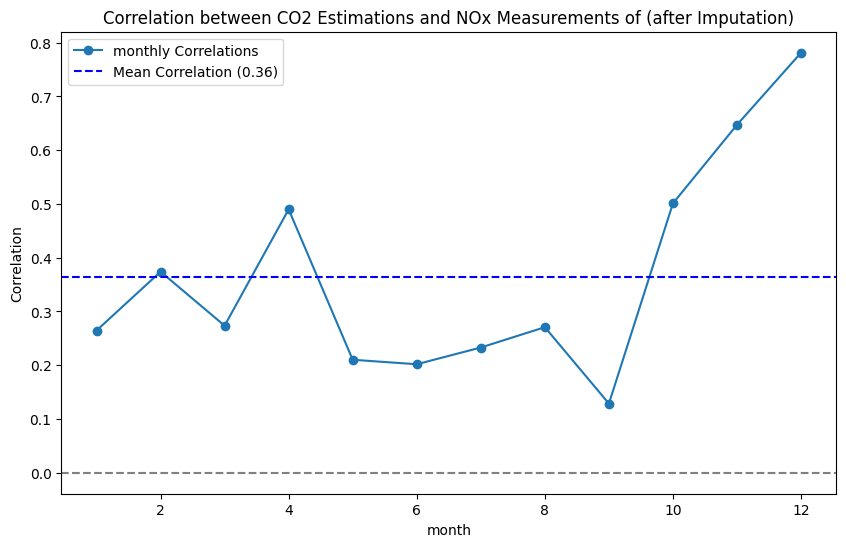

In [ ]:
import matplotlib.pyplot as plt

# the mean of the correlations
mean_correlation = results_by_month['correlation'].mean()

# the plot for monthly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_month['month'], results_by_month['correlation'], marker='o', label='monthly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('Correlation between CO2 Estimations and NOx Measurements of (after Imputation)')
plt.xlabel('month')
plt.ylabel('Correlation')
plt.legend()
plt.show()


In [ ]:
# all stations
results_by_month_good = calculate_monthly_correlations(sensors_rome, rome_good_stations_dictionary)
print(results_by_month_good)

Valid areas: ['48', '3', '8', '47', '5', '39', '57', '2', '55']
    NOx_sensor        CO_2
0    85.400000   52.786920
12  181.566667   62.214701
24  109.333333   25.004468
36  133.900000  157.012626
48  138.666667   34.474691
60   90.700000    9.861326
72   41.996830   36.403369
84  103.333333   68.066895
96  159.800000   57.592765

    NOx_sensor        CO_2
1    78.944034   45.673651
13  162.043396   77.862272
25  101.785714   49.403472
37  155.928571  131.127580
49  132.142857   35.165413
61   72.529286    6.623604
73   37.035714   39.472460
85   90.250000   93.773090
97  139.433998   40.966742

    NOx_sensor         CO_2
2    62.387097    45.932537
14  144.225806   186.323209
26   79.645433    95.049079
38  130.331112   116.225845
50  105.645161  1287.096237
62   54.472258    14.295082
74   27.316445    45.602754
86   70.555714   121.015751
98  109.967742    53.830758

    NOx_sensor        CO_2
3    42.533333   45.814138
15  102.933333   83.002252
27   48.833333  110.901518
39  1

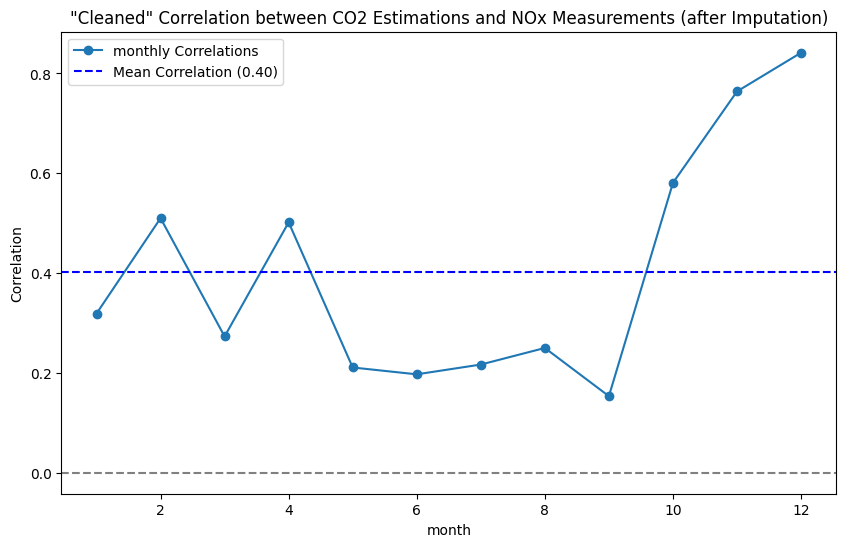

In [ ]:
import matplotlib.pyplot as plt

# the mean of the correlations
mean_correlation = results_by_month_good['correlation'].mean()

# the plot for monthly correlations
plt.figure(figsize=(10, 6))

plt.plot(results_by_month_good['month'], results_by_month_good['correlation'], marker='o', label='monthly Correlations')

plt.axhline(y=0, color='gray', linestyle='--')  # Zero correlation line
plt.axhline(y=mean_correlation, color='blue', linestyle='--', label=f'Mean Correlation ({mean_correlation:.2f})')  # Mean line

plt.title('"Cleaned" Correlation between CO2 Estimations and NOx Measurements (after Imputation)')
plt.xlabel('month')
plt.ylabel('Correlation')
plt.legend()
plt.show()


## Borghetto

In [ ]:
df_borghetto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/validation/borghetto_pisa_air_quality.csv')
df_borghetto.head()

date   pm25  pm10  o3   no2  so2  co
0  2017/1/10   85.0  34.0 NaN  48.0  NaN NaN
1  2017/1/11   89.0  52.0 NaN  35.0  NaN NaN
2  2017/1/12  134.0  19.0 NaN  26.0  NaN NaN
3  2017/1/13   46.0  33.0 NaN  36.0  NaN NaN
4  2017/1/14   80.0  21.0 NaN  31.0  NaN NaN

In [ ]:
df_borghetto.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')

In [ ]:
df_borghetto.co.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2784 entries, 0 to 2783
Series name: co
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 21.9 KB


In [ ]:
df_borghetto.o3.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2784 entries, 0 to 2783
Series name: o3
Non-Null Count  Dtype  
--------------  -----  
282 non-null    float64
dtypes: float64(1)
memory usage: 21.9 KB


In [ ]:
df_borghetto.pm25.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2784 entries, 0 to 2783
Series name: pm25
Non-Null Count  Dtype  
--------------  -----  
2705 non-null   float64
dtypes: float64(1)
memory usage: 21.9 KB


In [ ]:
df_borghetto.no2.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2784 entries, 0 to 2783
Series name: no2
Non-Null Count  Dtype  
--------------  -----  
2727 non-null   float64
dtypes: float64(1)
memory usage: 21.9 KB


In [ ]:
df_borghetto.replace(np.nan, 0, inplace=True)
df_borghetto

date   pm25  pm10   o3   no2  so2   co
0     2017/1/10   85.0  34.0  0.0  48.0  0.0  0.0
1     2017/1/11   89.0  52.0  0.0  35.0  0.0  0.0
2     2017/1/12  134.0  19.0  0.0  26.0  0.0  0.0
3     2017/1/13   46.0  33.0  0.0  36.0  0.0  0.0
4     2017/1/14   80.0  21.0  0.0  31.0  0.0  0.0
...         ...    ...   ...  ...   ...  ...  ...
2779   2024/8/5   57.0  18.0  0.0  12.0  0.0  0.0
2780   2024/8/6   50.0  15.0  0.0  11.0  0.0  0.0
2781   2024/8/7   46.0  16.0  0.0  10.0  0.0  0.0
2782   2024/8/8   46.0  19.0  0.0  16.0  0.0  0.0
2783   2024/8/9   55.0  18.0  0.0  17.0  0.0  0.0

[2784 rows x 7 columns]

In [ ]:
df_borghetto.no2 = df_borghetto.no2.apply(np.int64)
df_borghetto.no2.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2784 entries, 0 to 2783
Series name: no2
Non-Null Count  Dtype
--------------  -----
2784 non-null   int64
dtypes: int64(1)
memory usage: 21.9 KB


In [ ]:
# Convert the 'date' column to datetime format
df_borghetto['date'] = pd.to_datetime(df_borghetto['date'], format='%Y/%m/%d')

# Sort the DataFrame based on the 'date' column
df_sorted = df_borghetto.sort_values(by='date')

# Filter rows where the year is 2017
df_borghetto_2017 = df_sorted[df_sorted['date'].dt.year == 2017]

In [ ]:
df_borghetto_2017.head()

date   pm25  pm10   o3  no2  so2   co
10 2017-01-02    0.0  19.0  0.0   35  0.0  0.0
21 2017-01-03   57.0  46.0  0.0   46  0.0  0.0
24 2017-01-04  104.0  20.0  0.0   35  0.0  0.0
25 2017-01-05   59.0  15.0  0.0   27  0.0  0.0
26 2017-01-06   50.0  22.0  0.0   34  0.0  0.0

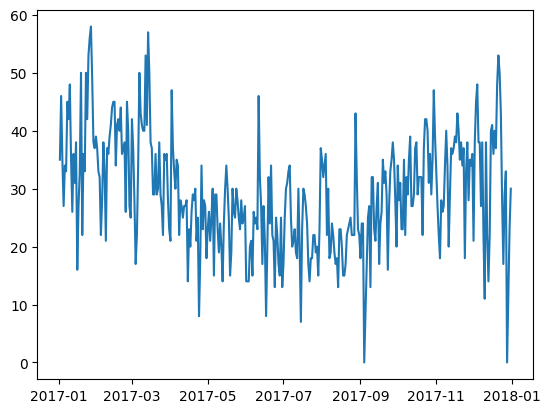

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(df_borghetto_2017.date, df_borghetto_2017['no2'])

In [ ]:
# Aggregating NO2 data to weekly averages
df_borghetto_2017['week'] = pd.to_datetime(df_borghetto_2017['date']).dt.isocalendar().week

# Group NO2 data by week and take mean
weekly_no2_borghetto_sensor = df_borghetto_2017.groupby(['week'])['no2'].mean().reset_index()

<ipython-input-52-a33f3f496da2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_borghetto_2017['week'] = pd.to_datetime(df_borghetto_2017['date']).dt.isocalendar().week


In [ ]:
# Aggregating NO2 data to monthly averages
df_borghetto_2017['month'] = pd.to_datetime(df_borghetto_2017['date']).dt.month

# Group NO2 data by week and take mean
monthly_no2_borghetto_sensor = df_borghetto_2017.groupby(['month'])['no2'].mean().reset_index()

<ipython-input-75-ca3137e6e797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_borghetto_2017['month'] = pd.to_datetime(df_borghetto_2017['date']).dt.month


## Passi

In [ ]:
df_passi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/validation/passi_pisa_air_quality.csv')
df_passi.head()

date   pm25  pm10    o3   no2  so2  co
0  2017/1/10   65.0  31.0  22.0  39.0  NaN NaN
1  2017/1/11   78.0  46.0   7.0  28.0  NaN NaN
2  2017/1/12  112.0  14.0  29.0  15.0  NaN NaN
3  2017/1/13   30.0  23.0  22.0  27.0  NaN NaN
4  2017/1/14   57.0  14.0  26.0  24.0  NaN NaN

In [ ]:
df_passi.replace(np.nan, 0, inplace=True)
df_passi

date   pm25  pm10    o3   no2  so2   co
0     2017/1/10   65.0  31.0  22.0  39.0  0.0  0.0
1     2017/1/11   78.0  46.0   7.0  28.0  0.0  0.0
2     2017/1/12  112.0  14.0  29.0  15.0  0.0  0.0
3     2017/1/13   30.0  23.0  22.0  27.0  0.0  0.0
4     2017/1/14   57.0  14.0  26.0  24.0  0.0  0.0
...         ...    ...   ...   ...   ...  ...  ...
2787   2024/8/5   50.0  16.0   0.0   5.0  0.0  0.0
2788   2024/8/6   46.0  15.0   0.0   4.0  0.0  0.0
2789   2024/8/7   38.0  14.0   0.0   3.0  0.0  0.0
2790   2024/8/8   46.0  17.0   0.0   7.0  0.0  0.0
2791   2024/8/9   50.0  19.0   0.0   6.0  0.0  0.0

[2792 rows x 7 columns]

In [ ]:
# df_passi.no2.astype(int)
df_passi.no2 = df_passi.no2.apply(np.int64)
df_passi.no2.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2792 entries, 0 to 2791
Series name: no2
Non-Null Count  Dtype
--------------  -----
2792 non-null   int64
dtypes: int64(1)
memory usage: 21.9 KB


In [ ]:
df_passi.no2.unique()

array([39, 28, 15, 27, 24,  0,  8, 34, 22, 14,  9, 33, 41, 44, 50, 38, 30,
       32, 26, 19, 11, 25, 31, 13, 16, 17, 20, 29, 35, 23, 18,  6, 36, 37,
       42, 12, 59,  5, 10, 21,  7,  4,  1,  2, 46,  3])

In [ ]:
# Convert the 'date' column to datetime format
df_passi['date'] = pd.to_datetime(df_passi['date'], format='%Y/%m/%d')

# Sort the DataFrame based on the 'date' column
df_sorted = df_passi.sort_values(by='date')

# Filter rows where the year is 2017
df_passi_2017 = df_sorted[df_sorted['date'].dt.year == 2017]

In [ ]:
df_passi_2017.head()

date  pm25  pm10    o3  no2  so2   co
10 2017-01-02   0.0  15.0   0.0    0  0.0  0.0
21 2017-01-03  42.0  36.0   6.0   34  0.0  0.0
24 2017-01-04  82.0  16.0   0.0    0  0.0  0.0
25 2017-01-05  50.0  13.0  23.0   26  0.0  0.0
26 2017-01-06  42.0  19.0  26.0   30  0.0  0.0

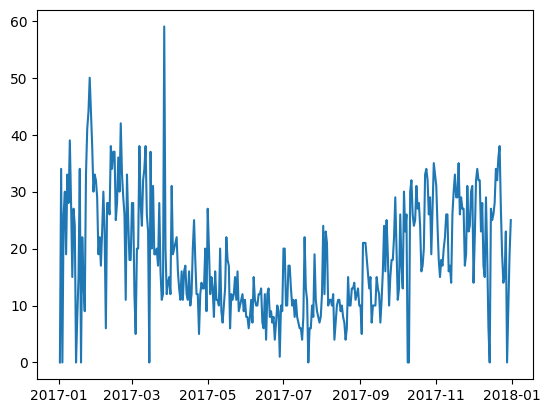

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(df_passi_2017.date, df_passi_2017['no2'])

In [ ]:
# Aggregating NO2 data to weekly averages
df_passi_2017['week'] = pd.to_datetime(df_passi_2017['date']).dt.isocalendar().week

# Group NO2 data by week and take mean
weekly_no2_passi_sensor = df_passi_2017.groupby(['week'])['no2'].mean().reset_index()


<ipython-input-71-6cd4758dec7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passi_2017['week'] = pd.to_datetime(df_passi_2017['date']).dt.isocalendar().week


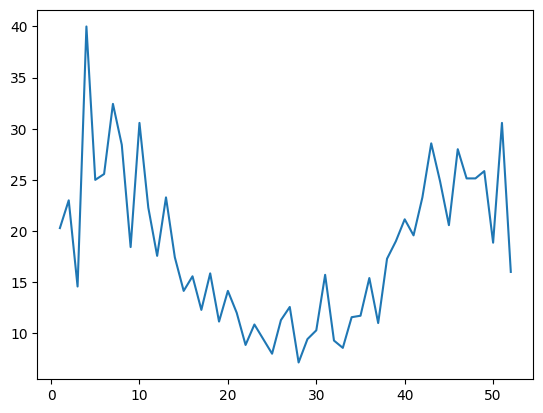

In [ ]:
plt.plot(weekly_no2_passi_sensor.week, weekly_no2_passi_sensor['no2'])

<ipython-input-73-49a84f4293fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passi_2017['month'] = pd.to_datetime(df_passi_2017['date']).dt.month


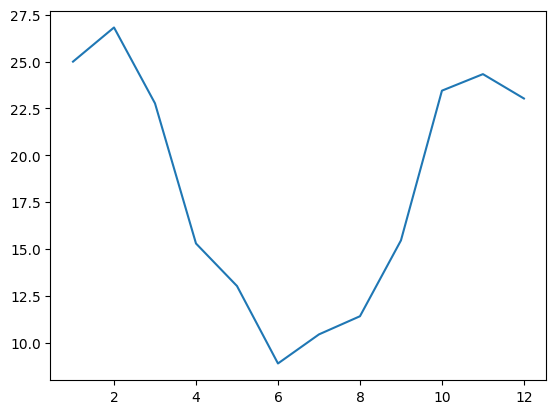

In [ ]:
# Aggregating NO2 data to monthly averages
df_passi_2017['month'] = pd.to_datetime(df_passi_2017['date']).dt.month

# Group NO2 data by month and take mean
monthly_no2_passi_sensor = df_passi_2017.groupby(['month'])['no2'].mean().reset_index()

plt.plot(monthly_no2_passi_sensor.month, monthly_no2_passi_sensor['no2'])

<ipython-input-74-191909bd2557>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passi_2017['quarter'] = pd.to_datetime(df_passi_2017['date']).dt.quarter


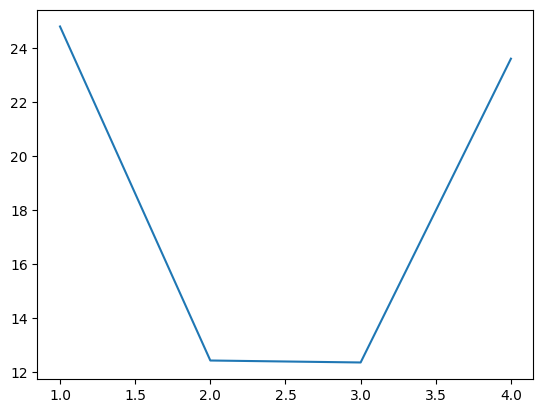

In [ ]:
# Aggregating NO2 data to quarterly averages
df_passi_2017['quarter'] = pd.to_datetime(df_passi_2017['date']).dt.quarter

# Group NO2 data by quarter and take mean
quarterly_no2_passi_sensor = df_passi_2017.groupby(['quarter'])['no2'].mean().reset_index()

plt.plot(quarterly_no2_passi_sensor.quarter, quarterly_no2_passi_sensor['no2'])

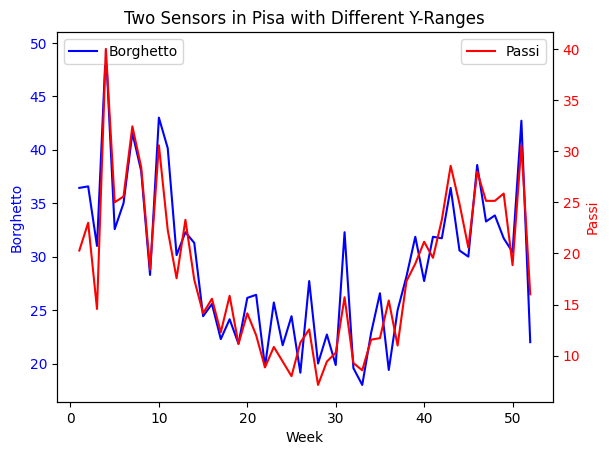

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot first time series
ax1.plot(weekly_no2_borghetto.week, weekly_no2_borghetto['no2'], 'b-', label='Borghetto')
ax1.set_xlabel('Week')
ax1.set_ylabel('Borghetto', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the second series
ax2 = ax1.twinx()
ax2.plot(weekly_no2_passi.week, weekly_no2_passi['no2'], 'r-', label='Passi')
ax2.set_ylabel('Passi', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Two Sensors in Pisa with Different Y-Ranges')

# Show plot
plt.show()

## Total Values

In [ ]:
import ast

city = 'pisa'
city_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/thesis_data/emissions/new_{}_emissions.csv'.format(city.lower()))
city_df = city_df[['week', 'week_start', 'road_link', 'CO_2']]

# convert the column
city_df['road_link'] = city_df['road_link'].apply(ast.literal_eval)
# Split the tuples into three columns
city_df[['start_point', 'end_point', 'extra_value']] = pd.DataFrame(city_df['road_link'].tolist(), index=city_df.index)

# some road links have two values: with extra value 1 and 0. Group them
city_df = city_df.drop('extra_value', axis=1)


total = city_df['CO_2'].sum()
print(total)

3579903.348155739


In [ ]:
print(len(city_df))
city_df.head()

934768


week  week_start                    road_link       CO_2  start_point  \
0   1.0  2017-01-02  (1671940644, 1671940667, 0)   2.485652   1671940644   
1   1.0  2017-01-02   (243837437, 2453539061, 0)   1.146029    243837437   
2   1.0  2017-01-02  (2023232628, 2479137357, 0)  16.544215   2023232628   
3   1.0  2017-01-02    (218778112, 907486383, 0)   1.984661    218778112   
4   1.0  2017-01-02   (262984066, 3118669003, 0)   6.513946    262984066   

    end_point  
0  1671940667  
1  2453539061  
2  2479137357  
3   907486383  
4  3118669003

In [ ]:
city_df['uid'].nunique()

11087

In [ ]:
date = "06_21_2024"
city = 'Pisa'

path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/'

embs_n_co2m = pd.read_csv(path+'{}_embs_n_co2m.csv'.format(city.lower()))
embs_n_co2m = embs_n_co2m[['road_link', 'start_point', 'end_point', 'CO_2/m']]

embs_with_predictions = pd.read_csv(path+'xgb_xgb/mdi_preds_{}_{}_125.csv'.format(city.lower(), date))
embs_with_predictions = embs_with_predictions.rename(columns={'predicted_carbon':'CO_2/m'})
embs_with_predictions = embs_with_predictions[['road_link', 'start_point', 'end_point', 'CO_2/m']]

# embs_all = embs_with_predictions.append(embs_n_co2m, ignore_index=True)
# df_merged = pd.concat([embs_with_predictions, embs_n_co2m], ignore_index=True, sort=False)
df_merged = embs_n_co2m

In [ ]:
print(len(df_merged))
df_merged.head()

30741


road_link  start_point   end_point    CO_2/m
0    (7257369708, 31770729, 0)   7257369708    31770729  0.266387
1    (33681447, 3044082602, 0)     33681447  3044082602  0.529803
2  (3044082602, 6957424170, 0)   3044082602  6957424170  0.239792
3  (6957424170, 9986411817, 0)   6957424170  9986411817  0.190269
4   (213417023, 9986411817, 0)    213417023  9986411817  0.351395

In [ ]:
edge_lens = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/phd_data/OSM_{}_raw_segment'.format(city))
edge_lens = edge_lens[['s_id', 'e_id', 'lanes', 'maxspeed', 'length']]
edge_lens.rename(columns={'s_id': 'start_point', 'e_id': 'end_point'}, inplace=True)
edge_lens.head()

start_point   end_point lanes maxspeed  length
0     31770729  7257369708     2       50   6.135
1   7257369708    31770729     2       50   6.135
2     33681447  3044082602     2       NG  15.567
3   3044082602  6957424170     2       NG  16.040
4   6957424170  9986411817     2       NG   9.738

In [ ]:
edge_lens.lanes.unique()

array(['2', 'NG', '4', '1', '3', '6'], dtype=object)

In [ ]:
co2_n_lens = pd.merge(df_merged, edge_lens, on=['start_point', 'end_point'])
co2_n_lens['CO_2'] = co2_n_lens['CO_2/m'] * co2_n_lens['length']
co2_n_lens = co2_n_lens.drop({'length', 'CO_2/m'}, axis=1)

len(co2_n_lens) # from 36k to 32k

30741

In [ ]:
print(len(co2_n_lens))
co2_n_lens.head()

30741


road_link  start_point   end_point lanes maxspeed  \
0    (7257369708, 31770729, 0)   7257369708    31770729     2       50   
1    (33681447, 3044082602, 0)     33681447  3044082602     2       NG   
2  (3044082602, 6957424170, 0)   3044082602  6957424170     2       NG   
3  (6957424170, 9986411817, 0)   6957424170  9986411817     2       NG   
4   (213417023, 9986411817, 0)    213417023  9986411817     2       NG   

       CO_2  
0  1.634282  
1  8.247451  
2  3.846260  
3  1.852835  
4  2.860000

In [ ]:
Total = co2_n_lens['CO_2'].sum()
print(Total)

3064793.3004616504


## Local Emissions

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'

city = 'pisa'
total_co2 = pd.read_csv(path+'{}_total_carbon_by_segment.csv'.format(city.lower()))
# embs_n_co2m = embs_n_co2m[['road_link', 'start_point', 'end_point', 'CO_2/m']]
print(len(total_co2))
total_co2.head()

36061


road_link   start_point     end_point      CO_2
0    (10018130858, 251350640, 0)  1.001813e+10  2.513506e+08  1.541559
1  (10021446943, 10021446944, 0)  1.002145e+10  1.002145e+10  0.618368
2   (10021446943, 7592895126, 0)  1.002145e+10  7.592895e+09  7.182241
3  (10021446944, 10021446943, 0)  1.002145e+10  1.002145e+10  1.934310
4  (10021446944, 10021446945, 0)  1.002145e+10  1.002145e+10  3.019397

In [ ]:
total_co2.CO_2.sum()

3508873.208976101

In [ ]:
co2_n_lens[co2_n_lens.start_point == 2261354605]

road_link  start_point   end_point lanes maxspeed  \
15284  (2261354605, 2261354597, 0)   2261354605  2261354597    NG       NG   
15288  (2261354605, 2261354607, 0)   2261354605  2261354607    NG       NG   

            CO_2  
15284  18.693386  
15288   0.640844

In [ ]:
city = 'pisa'
path = '/content/drive/MyDrive/Colab Notebooks/phd_data/pisa_full_network_emissions_11025_users.csv'
df = pd.read_csv(path)
df.head()

week  week_start     uid                    road_link       CO_2      NO_x  \
0   1.0  2017-01-02  2329.0  (1671940644, 1671940667, 0)   2.485652  0.001211   
1   1.0  2017-01-02  2329.0   (243837437, 2453539061, 0)   1.146029  0.001257   
2   1.0  2017-01-02  2386.0  (2023232628, 2479137357, 0)  16.544215  0.003011   
3   1.0  2017-01-02  2386.0    (218778112, 907486383, 0)   1.984661  0.000248   
4   1.0  2017-01-02  2386.0   (262984066, 3118669003, 0)   6.513946  0.002346   

         PM       VOC  
0  0.000078  0.004477  
1  0.000004  0.008940  
2  0.000000  0.022354  
3  0.000000  0.004469  
4  0.000000  0.008960

In [ ]:
import ast
# Convert string representation of tuples into actual tuples
df['road_link'] = df['road_link'].apply(ast.literal_eval)

# Now split the tuples into two columns
df[['start_point', 'end_point', 'zero']] = pd.DataFrame(df['road_link'].tolist(), index=df.index)
df.head()

week  week_start     uid                    road_link       CO_2      NO_x  \
0   1.0  2017-01-02  2329.0  (1671940644, 1671940667, 0)   2.485652  0.001211   
1   1.0  2017-01-02  2329.0   (243837437, 2453539061, 0)   1.146029  0.001257   
2   1.0  2017-01-02  2386.0  (2023232628, 2479137357, 0)  16.544215  0.003011   
3   1.0  2017-01-02  2386.0    (218778112, 907486383, 0)   1.984661  0.000248   
4   1.0  2017-01-02  2386.0   (262984066, 3118669003, 0)   6.513946  0.002346   

         PM       VOC  start_point   end_point  zero  
0  0.000078  0.004477   1671940644  1671940667     0  
1  0.000004  0.008940    243837437  2453539061     0  
2  0.000000  0.022354   2023232628  2479137357     0  
3  0.000000  0.004469    218778112   907486383     0  
4  0.000000  0.008960    262984066  3118669003     0

In [ ]:
df = df[(df.start_point == 249497032) | (df.end_point == 249497032)]

# Group by standardized start and end points and week, then sum CO_2 and NO_x
df_grouped = df_borghetto.groupby(['road_link', 'week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum',
    'uid': 'count'
}).reset_index()

# Sort the DataFrame based on the 'date' column
df_sorted = df_grouped.sort_values(by='week')

df_sorted

road_link  week  week_start      CO_2      NO_x  uid
0    (249497030, 249497032, 0)   2.0  2017-01-09  1.162680  0.001264    1
48  (249497032, 9569606699, 0)   2.0  2017-01-09  3.912919  0.004352    2
49  (249497032, 9569606699, 0)   3.0  2017-01-16  1.672614  0.001863    1
1    (249497030, 249497032, 0)   3.0  2017-01-16  2.314819  0.002524    1
50  (249497032, 9569606699, 0)   4.0  2017-01-23  2.631457  0.002659    1
..                         ...   ...         ...       ...       ...  ...
45   (249497030, 249497032, 0)  49.0  2017-12-04  2.905714  0.003160    3
94  (249497032, 9569606699, 0)  50.0  2017-12-11  1.706793  0.001879    1
46   (249497030, 249497032, 0)  50.0  2017-12-11  3.377833  0.003742    2
47   (249497030, 249497032, 0)  51.0  2017-12-18  1.157115  0.001262    1
95  (249497032, 9569606699, 0)  51.0  2017-12-18  3.920091  0.004356    1

[96 rows x 6 columns]

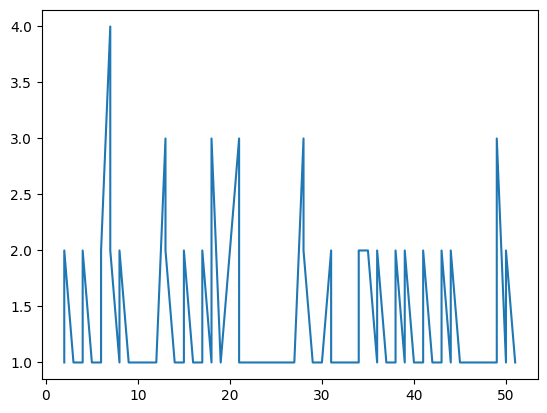

In [ ]:
plt.plot(df_sorted.week, df_sorted.uid)

CO2 and NOx by week and road segment

In [ ]:
city = 'pisa'
path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/pisa_full_network_emissions_11025_users.csv'
df = pd.read_csv(path)
# city_df = city_df[['week', 'week_start', 'road_link', 'CO_2']]

total = df['CO_2'].sum()
print(total)

# Group NO2 data by week and take mean
df = df.groupby(['road_link', 'week', 'week_start'], as_index=False)[['CO_2', 'NO_x']].sum()

import ast
# Convert string representation of tuples into actual tuples
df['road_link'] = df['road_link'].apply(ast.literal_eval)

# Now split the tuples into two columns
df[['start_point', 'end_point', 'zero']] = pd.DataFrame(df['road_link'].tolist(), index=df.index)

df = df[['week', 'week_start', 'start_point', 'end_point', 'CO_2', 'NO_x']]

df.head()

3508873.208976101


week  week_start  start_point    end_point      CO_2      NO_x
0  19.0  2017-05-08  10018130858    251350640  0.962989  0.000794
1  34.0  2017-08-21  10018130858    251350640  0.578570  0.000625
2  25.0  2017-06-19  10021446943  10021446944  0.618368  0.000649
3  10.0  2017-03-06  10021446943   7592895126  0.585222  0.000634
4  11.0  2017-03-13  10021446943   7592895126  1.106000  0.001238

### PASSI

In [ ]:
# point = 4550569914
# df_borghetto = df[(df.start_point == point) | (df.end_point == point)] # via ridolfi
# df_borghetto

In [ ]:
# # PASSI

# # FALCONE: 10911074429, 9285980792, 10911074428, 8869785116
# # 24 MAGGIO: 8809172557, 6966024046, 2261354601, 3107523661, 279566747, 4550569914, 10885271530, 1677340417
# # GIORDANO: 7052659946, 7052659948, 10905154746, 7052659935, 8553675834, 9309467009
# # MONTI: 7052659949, 7052659943, 11619078605, 7052659947, 7052659934, 7052659938, 8809172521
# # SANCTIS: 283632738, 7052659939, 7052659927, 8809172547, 1677340167, 283632768, 8553675841
# # VERGA: 1677340396, 11619236983, 283632739
# # NIEVO: 1677340167, 9301315494, 7052659953, 10885271526

# # (df.start_point == 2261354605) | (df.end_point == 2261354605) | (df.start_point == 8809172564) | (df.end_point == 8809172564)
# # df = df[(df.start_point == 2261354601) | (df.end_point == 2261354601) | (df.start_point == 2261354605) | (df.end_point == 2261354605) | (df.start_point == 8809172564) | (df.end_point == 8809172564)]

# points_passi = [283632768, 1677340417, 9309467009, 1677340167, 279566747, 8869785116,
# 9301315494, 8809172521, 8553675834, 10905154746, 4550569914, 8553675841,
# 8809172547, 8809172557, 3107523661, 11619078605, 7052659927, 7052659934,
# 7052659935, 7052659938, 283632738, 7052659939, 283632739, 10885271526,
# 7052659943, 2261354601, 10885271530, 7052659946, 7052659948, 7052659949,
# 6966024046, 7052659947, 1677340396, 7052659953, 11619236983, 9285980792,
# 10911074428, 10911074429]

# # Filter the DataFrame using .isin()
# df_passi = df[(df.start_point.isin(points_passi)) | (df.end_point.isin(points_passi))]

# # Group by standardized start and end points and week, then sum CO_2 and NO_x
# df_grouped = df_passi.groupby(['week', 'week_start']).agg({
#     'CO_2': 'sum',
#     'NO_x': 'sum'
# }).reset_index()

# # Sort the DataFrame based on the 'date' column
# df_sorted = df_grouped.sort_values(by='week')

# df_sorted

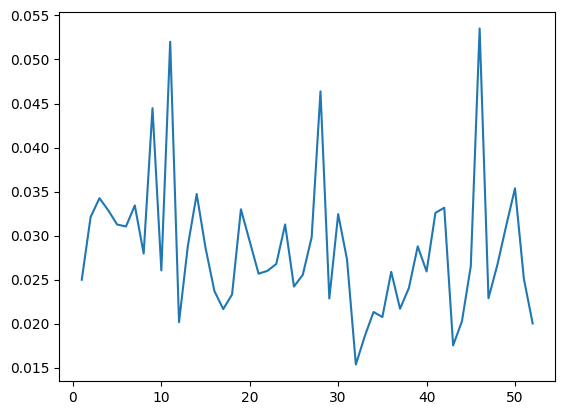

In [ ]:
plt.plot(df_sorted.week, df_sorted['NO_x'])

In [ ]:
# Replace the value in CO_2 for week 44 with 12
df_sorted.loc[(df_sorted['week'] == 22.0) & (df_sorted['CO_2'].round(6) == 248.153379), 'CO_2'] = 41
# df_sorted.loc[(df_sorted['week'] == 44.0) & (df_sorted['CO_2'].round(6) == 124.162680), 'CO_2'] = 12

In [ ]:
df_sorted.loc[(df_sorted['week'] == 22.0) & (df_sorted['NO_x'].round(6) == 0.164814), 'NO_x'] = 0.026
# df_sorted.loc[(df_sorted['week'] == 44.0) & (df_sorted['NO_x'].round(6) == 0.080860), 'NO_x'] = 0.003

Text(0.5, 1.0, 'Passi: CO2 Estimations')

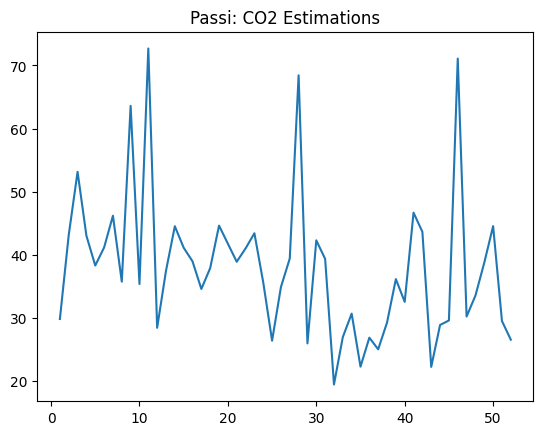

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(df_sorted.week, df_sorted['CO_2'])

# Add title
plt.title('Passi: CO2 Estimations')


Text(0.5, 1.0, 'Passi: NO2 Estimations')

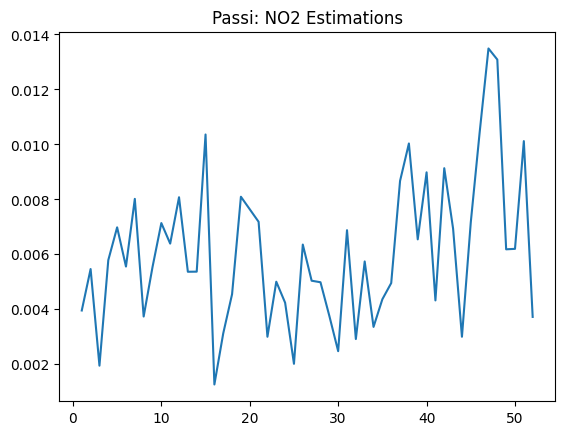

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(df_sorted.week, df_sorted['NO_x'])

# Add title
plt.title('Passi: NO2 Estimations')

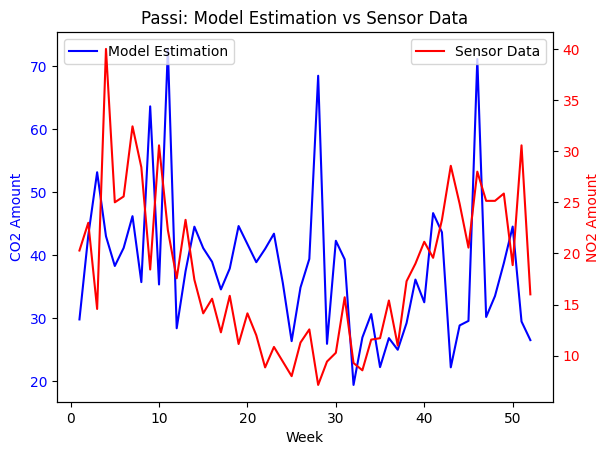

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot first time series
ax1.plot(df_sorted.week, df_sorted['CO_2'], 'b-', label='Model Estimation')
ax1.set_xlabel('Week')
ax1.set_ylabel('CO2 Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the second series
ax2 = ax1.twinx()
ax2.plot(weekly_no2_passi.week, weekly_no2_passi['no2'], 'r-', label='Sensor Data')
ax2.set_ylabel('NO2 Amount', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Passi: Model Estimation vs Sensor Data')

# Show plot
plt.show()

Monthly Emission Estimations in Passi

In [ ]:
from datetime import timedelta

# Convert 'week_start_date' to datetime format
df_sorted['week_start'] = pd.to_datetime(df_sorted['week_start'])

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
    week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
    month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
    return month_counts.idxmax()  # Return the month with the most days

# Apply the functions to the DataFrame
df_sorted['month'] = df_sorted['week_start'].apply(get_majority_month)
# Define quarter based on the month
df_sorted['quarter'] = df_sorted['month'].apply(lambda x: (x - 1) // 3 + 1)


Text(0.5, 1.0, 'Passi: Monthly CO2 Estimations')

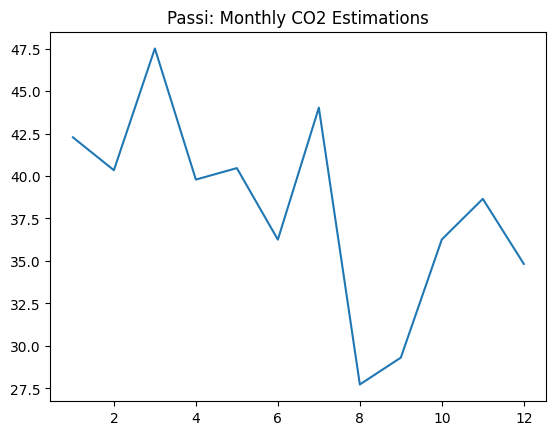

In [ ]:
# Group CO2 data by month and take mean
monthly_co2_passi_model = df_sorted.groupby(['month'])['CO_2'].mean().reset_index()

plt.plot(monthly_co2_passi_model.month, monthly_co2_passi_model['CO_2'])

# Add title
plt.title('Passi: Monthly CO2 Estimations')


In [ ]:
# Calculate Pearson correlation coefficient between Series1 and Series2
correlation = monthly_no2_passi_sensor['no2'].corr(monthly_co2_passi_model['CO_2'])

# Display the result
print(f'Correlation coefficient between Model and Sensor: {correlation:.2f}')


Correlation coefficient between Model and Sensor: 0.29


Comparison Quarterly Emissions in Passi

Correlation coefficient between Model and Sensor: 0.62


Text(0.5, 1.0, 'Passi: Quarterly CO2 Estimations')

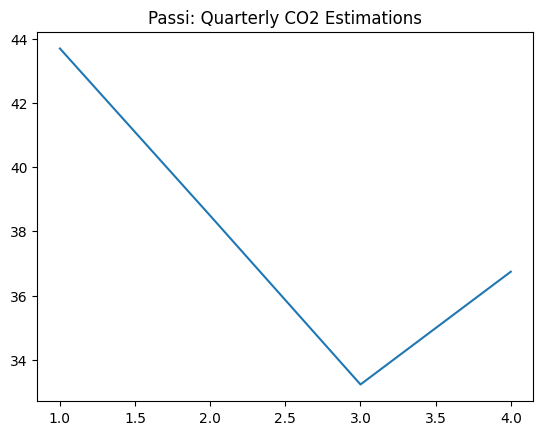

In [ ]:
# Group CO2 data by month and take mean
quarterly_co2_passi_model = df_sorted.groupby(['quarter'])['CO_2'].mean().reset_index()

# Calculate Pearson correlation coefficient between Series1 and Series2
correlation = quarterly_no2_passi_sensor['no2'].corr(quarterly_co2_passi_model['CO_2'])

# Display the result
print(f'Correlation coefficient between Model and Sensor: {correlation:.2f}')

# Create figure and axis
fig, ax1 = plt.subplots()

# Plot first time series
ax1.plot(quarterly_co2_passi_model.quarter, quarterly_co2_passi_model['CO_2'], 'b-', label='Model Estimation')
ax1.set_xlabel('Week')
ax1.set_ylabel('CO2 Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the second series
ax2 = ax1.twinx()
ax2.plot(weekly_no2_passi.week, weekly_no2_passi['no2'], 'r-', label='Sensor Data')
ax2.set_ylabel('NO2 Amount', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Passi: Quarterly CO2 Estimations')

# Show plot
plt.show()


In [ ]:
# # Standardize start and end points
# def standardize_road_link(row):
#     start = min(row['start_point'], row['end_point'])
#     end = max(row['start_point'], row['end_point'])
#     return pd.Series([start, end])

# df[['standard_start', 'standard_end']] = df.apply(standardize_road_link, axis=1)

# # Group by standardized start and end points and week, then sum CO_2 and NO_x
# df_grouped = df.groupby(['standard_start', 'standard_end', 'week', 'week_start']).agg({
#     'CO_2': 'sum',
#     'NO_x': 'sum'
# }).reset_index()

# # Sort the DataFrame based on the 'date' column
# df_sorted = df_grouped.sort_values(by='week')

# df_sorted

### Borghetto

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# location_borghetto =  (48.40980, 16.13586)

# Define your Gauss-Boaga coordinates
gb_x, gb_y = 1613586, 4840980  # Easting, Northing in EPSG:3003

# Initialize the transformer to convert from EPSG:3003 (Gauss-Boaga) to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:3003", "EPSG:4326", always_xy=True)

# Convert the coordinates to WGS84 (latitude/longitude)
lon, lat = transformer.transform(gb_x, gb_y)

G = ox.graph_from_point((lat, lon), dist=200, network_type=network_type, retain_all=True,
                        truncate_by_edge=False, simplify=False)

roads_borghetto = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()
roads_borghetto = roads_borghetto.rename(columns={'u':'start_point','v': 'end_point'})
roads_borghetto = roads_borghetto[['start_point', 'end_point', 'length']] #gives you a pandas series with edge lengths
print(f"No. of road segments: {roads_borghetto.shape[0]}")
# roads_borghetto = roads_borghetto.groupby(['start_point', 'end_point'])[['CO_2', 'NO_x', 'PM', 'VOC']].sum().reset_index()
roads_borghetto.head()

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of road segments: 202


start_point   end_point  length
0     31770719  5598713027   6.514
1     31770722  1952494735   5.826
2     31770722  3011686026   5.723
3     31770734  6301741720  11.738
4     31770734  5562981073   7.645

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

# Define the location and network type
location = 'Pisa, Italy'
network_type = 'drive_service'

# Define your Gauss-Boaga coordinates
gb_x, gb_y = 1612822, 4843724  # Easting, Northing in EPSG:3003

# Initialize the transformer to convert from EPSG:3003 (Gauss-Boaga) to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:3003", "EPSG:4326", always_xy=True)

# Convert the coordinates to WGS84 (latitude/longitude)
lon, lat = transformer.transform(gb_x, gb_y)


network_type = 'drive_service'
lont, lat = 11.908954, 42.157856

G = ox.graph_from_point((lat, lon), dist=200, network_type=network_type, retain_all=True,
                        truncate_by_edge=False, simplify=False)

roads_passi = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()
roads_passi = roads_passi.rename(columns={'u':'start_point','v': 'end_point'})
roads_passi = roads_passi[['start_point', 'end_point', 'length']] #gives you a pandas series with edge lengths
print(f"No. of road segments: {roads_passi.shape[0]}")
# roads_borghetto = roads_borghetto.groupby(['start_point', 'end_point'])[['CO_2', 'NO_x', 'PM', 'VOC']].sum().reset_index()
roads_passi.head()

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


No. of road segments: 239


start_point    end_point  length
0    279566747   3107523661   9.437
1    279566747   9309467009   3.406
2    279566747  11619078645  30.750
3    283632729  10885271525  13.943
4    283632729  10905154750  11.183

In [ ]:
# prompt: Using dataframe roads_borghetto: import and emission dataset and merge with roads_borghetto based on start and end points

# Assuming you have a dataframe named 'emission' with columns 'start_point' and 'end_point'
# Replace 'emission' with your actual dataframe name

# Merge the two dataframes based on start_point and end_point
weekly_estimations_passi = roads_passi.merge(df, on=['start_point', 'end_point'])
# merged_df['CO_2'] = merged_df['CO_2'] * road_segments['length']
print(f"No.: {weekly_estimations_passi.shape[0]}")

# Group by standardized start and end points and week, then sum CO_2 and NO_x
df_grouped = weekly_estimations_passi.groupby(['week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum'
}).reset_index()

# new_row = pd.DataFrame({
#     'week': [22.0],
#     'week_start': ['2017-05-29'],          # Use pd.NaT for missing dates
#     'CO_2': [5],
#     'NO_x': [0.003]
# })

# df_grouped = pd.concat([df_grouped, new_row], ignore_index=True)

# Sort the DataFrame based on the 'date' column
df_sorted_passi = df_grouped.sort_values(by='week')

df_sorted_passi

No.: 1359


week  week_start        CO_2      NO_x
0    1.0  2017-01-02    1.152687  0.001260
1    2.0  2017-01-09   80.206920  0.059376
2    3.0  2017-01-16   95.556341  0.068941
3    4.0  2017-01-23   80.371970  0.057184
4    5.0  2017-01-30  112.282395  0.084009
5    6.0  2017-02-06   76.573996  0.052469
6    7.0  2017-02-13   79.835172  0.062926
7    8.0  2017-02-20   73.325678  0.056347
8    9.0  2017-02-27  104.897362  0.076515
9   10.0  2017-03-06   72.030197  0.053514
10  11.0  2017-03-13  117.074692  0.083894
11  12.0  2017-03-20   67.089325  0.051986
12  13.0  2017-03-27   86.424203  0.067103
13  14.0  2017-04-03   76.762976  0.054493
14  15.0  2017-04-10  111.219499  0.077123
15  16.0  2017-04-17   70.194329  0.049609
16  17.0  2017-04-24   59.455492  0.041499
17  18.0  2017-05-01   64.015382  0.045928
18  19.0  2017-05-08   91.712962  0.068385
19  21.0  2017-05-22   91.937310  0.047599
20  22.0  2017-05-29   26.196201  0.020819
21  23.0  2017-06-05   90.819151  0.060419
22  24.0  2017-06-12   79.594938  0.059784
23  25.0  2017-06-19   66.967514  0.049768
24  26.0  2017-06-26   80.264669  0.066056
25  27.0  2017-07-03   78.632995  0.060752
26  28.0  2017-07-10  130.030931  0.090951
27  29.0  2017-07-17   82.288608  0.058928
28  30.0  2017-07-24   84.564654  0.059170
29  31.0  2017-07-31   64.477921  0.043357
30  32.0  2017-08-07   63.190623  0.047415
31  33.0  2017-08-14   54.818879  0.038138
32  34.0  2017-08-21   55.074131  0.044911
33  35.0  2017-08-28   59.309091  0.043922
34  36.0  2017-09-04   85.788080  0.067610
35  37.0  2017-09-11   74.711377  0.058474
36  38.0  2017-09-18   65.168575  0.049344
37  39.0  2017-09-25   83.476806  0.058987
38  40.0  2017-10-02   76.277847  0.056243
39  41.0  2017-10-09   79.003986  0.055121
40  42.0  2017-10-16   78.290464  0.065072
41  43.0  2017-10-23   66.947560  0.052967
42  44.0  2017-10-30  106.367392  0.086879
43  45.0  2017-11-06   82.424604  0.071195
44  46.0  2017-11-13   96.544675  0.076983
45  47.0  2017-11-20   92.366505  0.061389
46  48.0  2017-11-27   60.527875  0.054644
47  49.0  2017-12-04   84.515563  0.053735
48  50.0  2017-12-11   94.775393  0.078030
49  51.0  2017-12-18   91.291686  0.070989
50  52.0  2017-12-25   85.063056  0.065837

In [ ]:
# # Create a standardized representation of each road link
# roads_borghetto['standardized_pair'] = roads_borghetto.apply(lambda row: tuple(sorted([row['start_point'], row['end_point']])), axis=1)

# # Find rows with duplicate standardized pairs
# duplicates = roads_borghetto[roads_borghetto.duplicated(subset='standardized_pair', keep=False)].sort_values(by='standardized_pair')
# duplicates

Replace outliers with smaller values

In [ ]:
# Replace the value in CO_2 for week 23, 30, and 32 in df_sorted_passi
df_sorted_passi.loc[(df_sorted_passi['week'] == 23.0) & (df_sorted_passi['CO_2'].round(6) == 90.819151), 'CO_2'] = 53
df_sorted_passi.loc[(df_sorted_passi['week'] == 28.0) & (df_sorted_passi['CO_2'].round(6) == 130.030931), 'CO_2'] = 80
# df_sorted_passi.loc[(df_sorted_passi['week'] == 32.0) & (df_sorted_passi['CO_2'].round(6) == 162.110930), 'CO_2'] = 58
# df_sorted_passi.loc[(df_sorted_passi['week'] == 36.0) & (df_sorted_passi['CO_2'].round(6) == 333.592698), 'CO_2'] = 40


In [ ]:
# df_sorted.loc[(df_sorted['week'] == 30.0) & (df_sorted['NO_x'].round(6) == 0.125685), 'NO_x'] = 0.047
# df_sorted.loc[(df_sorted['week'] == 32.0) & (df_sorted['NO_x'].round(6) == 0.191573), 'NO_x'] = 0.046
# df_sorted.loc[(df_sorted['week'] == 42.0) & (df_sorted['NO_x'].round(6) == 0.225519), 'NO_x'] = 0.03

In [ ]:
from datetime import timedelta

# Convert 'week_start' to datetime format
df_sorted_passi['week_start'] = pd.to_datetime(df_sorted_passi['week_start'])

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
    week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
    month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
    return month_counts.idxmax()  # Return the month with the most days

# Apply the functions to the df_sorted_passi DataFrame
df_sorted_passi['month'] = df_sorted_passi['week_start'].apply(get_majority_month)

# Define quarter based on the month
df_sorted_passi['quarter'] = df_sorted_passi['month'].apply(lambda x: (x - 1) // 3 + 1)


Correlation coefficient between Model and Sensor (week, Passi): 0.25


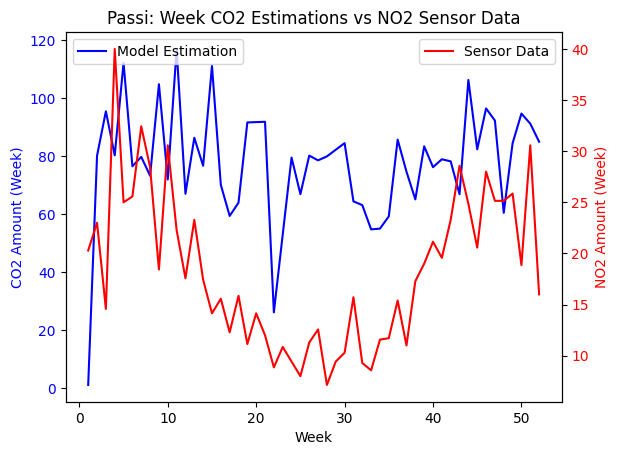

In [ ]:
plot_pollutant_correlation(df_sorted_passi, weekly_no2_passi_sensor, time_period='week', area_name='Passi')

Correlation coefficient between Model and Sensor (month, Passi): 0.46


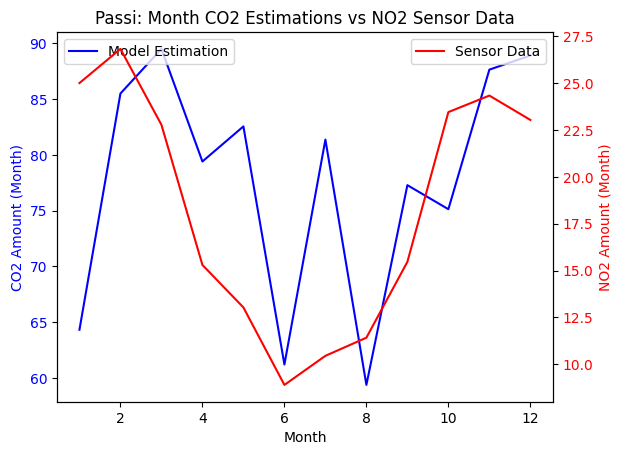

In [ ]:
plot_pollutant_correlation(df_sorted_passi, monthly_no2_passi_sensor, time_period='month', area_name='Passi')

Correlation coefficient between Model and Sensor (quarter, Passi): 0.95


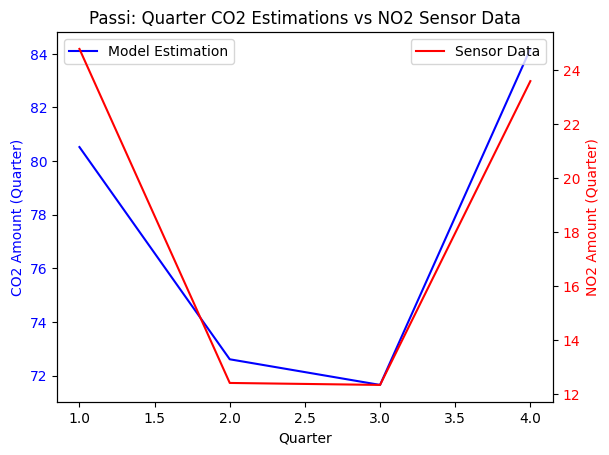

In [ ]:
plot_pollutant_correlation(df_sorted_passi, quarterly_no2_passi_sensor, time_period='quarter', area_name='Passi')

In [ ]:
point = 3691217190
df_borghetto = df[(df.start_point == point) | (df.end_point == point)] # via ridolfi
df_borghetto

week  week_start  start_point   end_point       CO_2      NO_x
18478    2.0  2017-01-09  10921438358  3691217190   1.106000  0.001238
18479    3.0  2017-01-16  10921438358  3691217190   0.553000  0.000619
18480    4.0  2017-01-23  10921438358  3691217190   1.106000  0.001238
18481    6.0  2017-02-06  10921438358  3691217190   2.637896  0.001219
18482    7.0  2017-02-13  10921438358  3691217190   2.448102  0.001216
...      ...         ...          ...         ...        ...       ...
215309  48.0  2017-11-27   3691217190  5113254262   8.153937  0.004616
215310  49.0  2017-12-04   3691217190  5113254262   3.297860  0.002399
215311  50.0  2017-12-11   3691217190  5113254262  11.583951  0.008362
215312  51.0  2017-12-18   3691217190  5113254262   5.086027  0.003797
215313  52.0  2017-12-25   3691217190  5113254262   6.987634  0.004307

[81 rows x 6 columns]

In [ ]:
# 1386672977, 3446498300,3446498299,3446498298,3446498297,1386672980,3446498329,3446498330,1386672970,3446498331,3446498306,3446498332,3446498334,3446498335,3446498336,3446498337,3446498338,3446498305,3446498333,31770713,3446498339,3446498340,3446498341,3446498304,3082461961,3446498303,1386672959,3446498301,213421614,3446498302,3446498326, 3446498345, 3446498310, 3082461964, 3446498328, 3082461963, 3446498327, 3446498307, 3082461965, 3082461964, 3082461966, 3446498309, 1386672995, 3446498342, 3446498308, 6740134630, 8913553260, 6740134629, 6740134631, 6740134628, 1946207902, 213434538, 213434540, 1946207902, 1946207904, 1946207900, 1946207906, 8730764522, 1946207887, 1386672980 - piazza caduti
# 248172983 ponte - lungarno buozzi
# 10917714289, 8857329623, 8857329624, - lungarno buozzi
# 249497034 - buozzi and rifolfi
# 249497030, 249497032, 9569606699, 11724956112, 10917714294 = ridolfi


# 249497029 - ridolfi and borghetto
# 31770712 - aqui and matteotti
# 213434537 - caduti and buozzi

# 10804384097 - matteotti
# 8821185658, 3738141474, 2995105060, 8821185665 - via borghetto

# df_borghetto = df[(df.start_point == 7033352452) | (df.end_point == 7033352452) | (df.start_point == 249497034) | (df.end_point == 249497034)] # lungarno

points = [248172983, 31770712, 213434537, 1386672977, 10804384097, 8821185658, 3738141474, 2995105060, 8821185665, 3446498300, 3446498299, 3446498298,
          3446498297, 1386672980, 3446498329, 3446498330, 1386672970, 3446498331, 3446498306, 3446498332, 3446498334, 3446498335, 3446498336, 3446498337,
          3446498338, 3446498305, 3446498333, 31770713, 3446498339, 3446498340, 3446498341, 3446498304, 3082461961, 3446498303, 1386672959, 3446498301,
          213421614, 3446498302, 3446498326, 3446498345, 3446498310, 3082461964, 3446498328, 3082461963, 3446498327, 3446498307, 3082461965, 3082461966,
          3446498309, 1386672995, 3446498342, 3446498308, 6740134630, 8913553260, 6740134629, 6740134631, 6740134628, 1946207902, 213434538, 213434540,
          1946207904, 1946207900, 1946207906, 8730764522, 1946207887, 11659355290, 3640327113, 774990272, 10917714289, 8857329623, 8857329624, 249497034,
          249497030, 249497032, 9569606699, 11724956112, 10917714294, 249497029, 3639229515, 11659355275, 392131676, 3446498296, 3446498294, 3446498295,
          1386672976, 31770715, 241508771, 3787844862, 8980969877, 5285711365, 8860189644, 5598713026, 31770719, 5598713027, 8730764539, 5285711364, 685329968,
          10921438358, 3691217190, 3446498293, 3446497191, 3446497192, 3082461960, 3446497190, 3446497189, 3446497188, 3446497187, 3446497186, 3446497185,
          3446498325, 1386672987, 3446497184, 3446497183, 3446497182, 3446498324, 3446497181, 213421795, 3446498323, 3446497180, 3446498364, 3446498322,
          3446498363, 31770716, 3446498321, 3082461971, 3446498357, 3446498320, 3446498358, 1386673005, 3446498359, 3446498319, 3446498360, 3082461970,
          3446498361, 3446498318, 3446498362, 3082461959, 3446498317, 3082461969, 3446498316, 1386672992]
# df_borghetto = df[(df.start_point == 249497032) | (df.end_point == 249497032)] # via ridolfi

# Filter the DataFrame using .isin()
df_borghetto = df[(df.start_point.isin(points)) | (df.end_point.isin(points))]

# Group by standardized start and end points and week, then sum CO_2 and NO_x
df_grouped = df_borghetto.groupby(['week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum'
}).reset_index()

# new_row = pd.DataFrame({
#     'week': [22.0],
#     'week_start': ['2017-05-29'],          # Use pd.NaT for missing dates
#     'CO_2': [5],
#     'NO_x': [0.003]
# })

# df_grouped = pd.concat([df_grouped, new_row], ignore_index=True)

# Sort the DataFrame based on the 'date' column
df_sorted = df_grouped.sort_values(by='week')

df_sorted

week  week_start        CO_2      NO_x
0    1.0  2017-01-02   47.165843  0.034330
1    2.0  2017-01-09   36.880384  0.032913
2    3.0  2017-01-16   56.839956  0.044263
3    4.0  2017-01-23   40.992633  0.036309
4    5.0  2017-01-30   44.338504  0.035243
5    6.0  2017-02-06   44.831097  0.037648
6    7.0  2017-02-13   55.230805  0.042067
7    8.0  2017-02-20   52.987723  0.040003
8    9.0  2017-02-27   49.221083  0.042343
9   10.0  2017-03-06   49.667841  0.037875
10  11.0  2017-03-13   43.554605  0.037829
11  12.0  2017-03-20   40.900025  0.035986
12  13.0  2017-03-27   61.116204  0.053278
13  14.0  2017-04-03   27.523192  0.024746
14  15.0  2017-04-10   45.152822  0.032661
15  16.0  2017-04-17   64.612114  0.057908
16  17.0  2017-04-24   43.102137  0.033729
17  18.0  2017-05-01   41.951355  0.031342
18  19.0  2017-05-08   42.318416  0.036714
19  21.0  2017-05-22   86.523084  0.060779
20  22.0  2017-05-29   17.345728  0.011719
21  23.0  2017-06-05   61.569507  0.047003
22  24.0  2017-06-12   47.945381  0.041818
23  25.0  2017-06-19   40.050467  0.034024
24  26.0  2017-06-26   51.925155  0.036088
25  27.0  2017-07-03   53.142023  0.044511
26  28.0  2017-07-10   61.185199  0.040335
27  29.0  2017-07-17   48.332008  0.036351
28  30.0  2017-07-24  183.808085  0.125685
29  31.0  2017-07-31   81.054451  0.058848
30  32.0  2017-08-07   58.046702  0.034094
31  33.0  2017-08-14   55.614061  0.035665
32  34.0  2017-08-21   72.230508  0.050928
33  35.0  2017-08-28   77.113692  0.051956
34  36.0  2017-09-04  240.988606  0.191573
35  37.0  2017-09-11   57.318527  0.042960
36  38.0  2017-09-18   44.692817  0.041235
37  39.0  2017-09-25   44.699675  0.027728
38  40.0  2017-10-02   42.131713  0.030398
39  41.0  2017-10-09   41.657165  0.029606
40  42.0  2017-10-16  333.592698  0.225519
41  43.0  2017-10-23   39.950458  0.032214
42  44.0  2017-10-30   41.574272  0.030609
43  45.0  2017-11-06   51.188168  0.032804
44  46.0  2017-11-13   35.639021  0.028756
45  47.0  2017-11-20   43.627626  0.038274
46  48.0  2017-11-27   43.218613  0.033461
47  49.0  2017-12-04   84.990079  0.055027
48  50.0  2017-12-11   48.264524  0.038047
49  51.0  2017-12-18   45.482267  0.035091
50  52.0  2017-12-25   38.849537  0.023579

In [ ]:
# prompt: Using dataframe roads_borghetto: import and emission dataset and merge with roads_borghetto based on start and end points

# Assuming you have a dataframe named 'emission' with columns 'start_point' and 'end_point'
# Replace 'emission' with your actual dataframe name

# Merge the two dataframes based on start_point and end_point
weekly_estimations_borghetto = roads_borghetto.merge(df, on=['start_point', 'end_point'])
# merged_df['CO_2'] = merged_df['CO_2'] * road_segments['length']
print(f"No.: {weekly_estimations_borghetto.shape[0]}")

# Group by standardized start and end points and week, then sum CO_2 and NO_x
df_grouped = weekly_estimations_borghetto.groupby(['week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum'
}).reset_index()

# new_row = pd.DataFrame({
#     'week': [22.0],
#     'week_start': ['2017-05-29'],          # Use pd.NaT for missing dates
#     'CO_2': [5],
#     'NO_x': [0.003]
# })


# df_grouped = pd.concat([df_grouped, new_row], ignore_index=True)

# Sort the DataFrame based on the 'date' column
df_sorted = df_grouped.sort_values(by='week')

df_sorted

No.: 1471


week  week_start        CO_2      NO_x
0    2.0  2017-01-09   67.923716  0.061175
1    3.0  2017-01-16  157.176910  0.118660
2    4.0  2017-01-23   62.915496  0.052912
3    5.0  2017-01-30  112.232110  0.084500
4    6.0  2017-02-06   56.264615  0.046946
5    7.0  2017-02-13   73.953892  0.068613
6    8.0  2017-02-20   67.495812  0.054838
7    9.0  2017-02-27   69.665767  0.061159
8   10.0  2017-03-06   64.226740  0.053319
9   11.0  2017-03-13   65.749664  0.053972
10  12.0  2017-03-20   90.010045  0.063185
11  13.0  2017-03-27   70.876587  0.062151
12  14.0  2017-04-03   65.027563  0.054279
13  15.0  2017-04-10   50.784913  0.042493
14  16.0  2017-04-17   65.024190  0.054877
15  17.0  2017-04-24   49.079784  0.041885
16  18.0  2017-05-01   33.480201  0.031056
17  19.0  2017-05-08   61.198133  0.047818
18  21.0  2017-05-22   88.286002  0.069369
19  22.0  2017-05-29   18.205260  0.014701
20  23.0  2017-06-05  146.239787  0.110003
21  24.0  2017-06-12   52.648488  0.046862
22  25.0  2017-06-19   74.694285  0.067326
23  26.0  2017-06-26   73.508289  0.066506
24  27.0  2017-07-03   79.343485  0.070274
25  28.0  2017-07-10  112.923435  0.077495
26  29.0  2017-07-17   55.021245  0.054054
27  30.0  2017-07-24  205.911829  0.142173
28  31.0  2017-07-31   66.662209  0.050193
29  32.0  2017-08-07  162.110930  0.109879
30  33.0  2017-08-14   51.944465  0.041110
31  34.0  2017-08-21   84.737264  0.064262
32  35.0  2017-08-28   62.746111  0.047627
33  36.0  2017-09-04  114.648318  0.084024
34  37.0  2017-09-11   81.643925  0.076236
35  38.0  2017-09-18   89.546683  0.072774
36  39.0  2017-09-25   66.451907  0.056439
37  40.0  2017-10-02   52.458304  0.044603
38  41.0  2017-10-09   57.941812  0.052114
39  42.0  2017-10-16   56.811464  0.047226
40  43.0  2017-10-23   52.065081  0.049717
41  44.0  2017-10-30   49.115446  0.042302
42  45.0  2017-11-06   45.337619  0.038551
43  46.0  2017-11-13   38.969874  0.030933
44  47.0  2017-11-20   52.622826  0.046456
45  48.0  2017-11-27   71.000302  0.056073
46  49.0  2017-12-04   61.981469  0.051102
47  50.0  2017-12-11   63.209189  0.050995
48  51.0  2017-12-18   45.638631  0.042199
49  52.0  2017-12-25   39.068505  0.029842

In [ ]:
from datetime import timedelta

# Convert 'week_start_date' to datetime format
df_sorted['week_start'] = pd.to_datetime(df_sorted['week_start'])

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
    week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
    month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
    return month_counts.idxmax()  # Return the month with the most days

# Apply the functions to the DataFrame
df_sorted['month'] = df_sorted['week_start'].apply(get_majority_month)
# Define quarter based on the month
df_sorted['quarter'] = df_sorted['month'].apply(lambda x: (x - 1) // 3 + 1)


NameError: name 'df_sorted' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_pollutant_correlation(df, sensor_df, time_period='quarter', area_name='Borghetto', co2_col='CO_2', no2_col='no2'):
    """
    This function groups CO2 data by a specified time period (week, month, or quarter),
    calculates the mean, computes the Pearson correlation coefficient between NO2 and CO2 data,
    and plots both time series. The title of the plot dynamically includes the area name.

    Parameters:
    df (pd.DataFrame): DataFrame containing time period and CO2 data.
    sensor_df (pd.DataFrame): DataFrame containing time period and NO2 sensor data.
    time_period (str): Time period for grouping ('week', 'month', 'quarter'). Default is 'quarter'.
    area_name (str): Name of the area for which the data is being plotted. Default is 'Borghetto'.
    co2_col (str): The name of the CO2 column in df. Default is 'CO_2'.
    no2_col (str): The name of the NO2 column in sensor_df. Default is 'no2'.

    Returns:
    None: Displays the plot and prints the correlation coefficient.
    """

    # Group CO2 data by the specified time period and calculate the mean
    grouped_co2 = df.groupby([time_period])[co2_col].mean().reset_index()

    # Calculate Pearson correlation coefficient between NO2 and CO2 data
    correlation = sensor_df[no2_col].corr(grouped_co2[co2_col])

    # Display the correlation result
    print(f'Correlation coefficient between Model and Sensor ({time_period}ly, {area_name}): {correlation:.2f}')

    # Create figure and axis for the plot
    fig, ax1 = plt.subplots()

    # Plot the CO2 model data on the first axis
    ax1.plot(grouped_co2[time_period], grouped_co2[co2_col], 'b-', label='Model Estimation')
    ax1.set_xlabel(time_period.capitalize())  # Dynamically set x-label based on the time period
    ax1.set_ylabel(f'CO2 Amount ({time_period.capitalize()})', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis for the NO2 sensor data
    ax2 = ax1.twinx()
    ax2.plot(sensor_df[time_period], sensor_df[no2_col], 'r-', label='Sensor Data')
    ax2.set_ylabel(f'NO2 Amount ({time_period.capitalize()})', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legends to both plots
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Add title to the plot
    plt.title(f'{area_name}: {time_period.capitalize()}ly CO2 Estimations vs NO2 Sensor Data')

    # Show the plot
    plt.show()



Replace outliers with smaller values

In [ ]:
# Replace the value in CO_2 for week 44 with 12
df_sorted.loc[(df_sorted['week'] == 23.0) & (df_sorted['CO_2'].round(6) == 146.239787), 'CO_2'] = 35
df_sorted.loc[(df_sorted['week'] == 30.0) & (df_sorted['CO_2'].round(6) == 205.911829), 'CO_2'] = 60
df_sorted.loc[(df_sorted['week'] == 32.0) & (df_sorted['CO_2'].round(6) == 162.110930), 'CO_2'] = 58
# df_sorted.loc[(df_sorted['week'] == 36.0) & (df_sorted['CO_2'].round(6) == 333.592698), 'CO_2'] = 40

In [ ]:
df_sorted.loc[(df_sorted['week'] == 30.0) & (df_sorted['NO_x'].round(6) == 0.125685), 'NO_x'] = 0.047
df_sorted.loc[(df_sorted['week'] == 32.0) & (df_sorted['NO_x'].round(6) == 0.191573), 'NO_x'] = 0.046
df_sorted.loc[(df_sorted['week'] == 42.0) & (df_sorted['NO_x'].round(6) == 0.225519), 'NO_x'] = 0.03

Correlation coefficient between Model and Sensor (weekly, Borghetto): 0.10


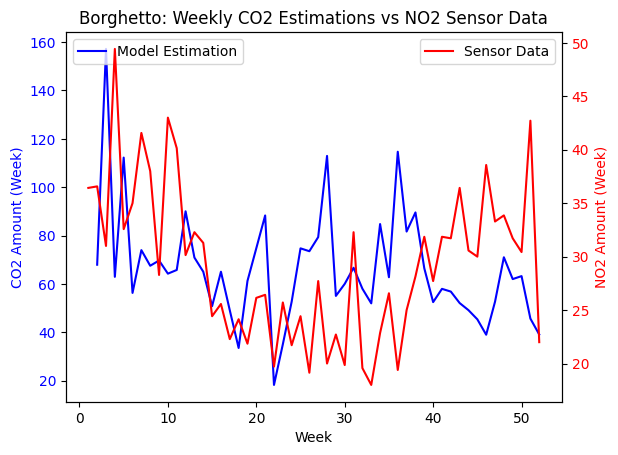

In [ ]:
plot_pollutant_correlation(df_sorted, weekly_no2_borghetto_sensor, time_period='week', area_name='Borghetto')

Correlation coefficient between Model and Sensor (month, Borghetto): 0.29


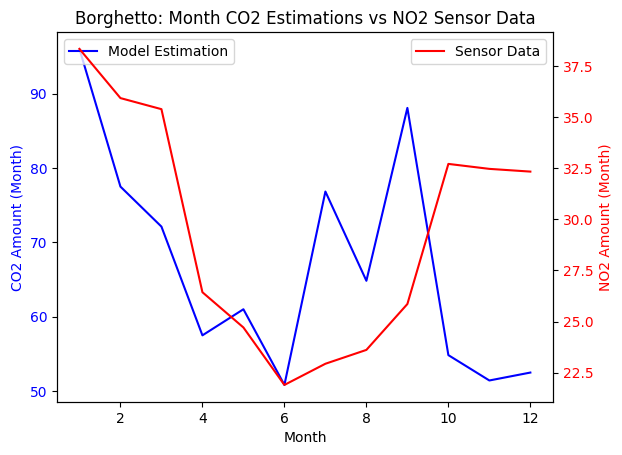

In [ ]:
plot_pollutant_correlation(df_sorted, monthly_no2_borghetto_sensor, time_period='month', area_name='Borghetto')

Correlation coefficient between Model and Sensor (quarter, Borghetto): 0.23


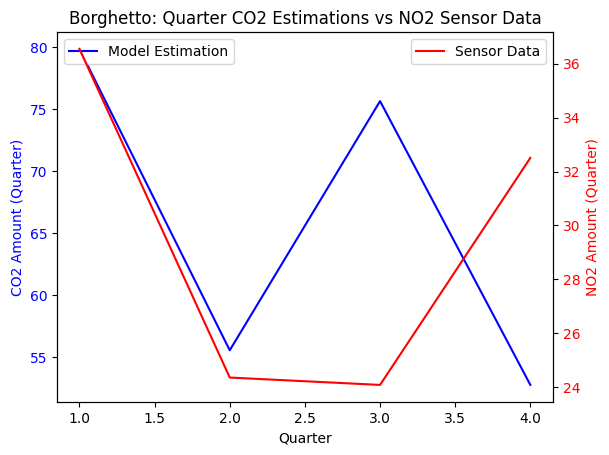

In [ ]:
plot_pollutant_correlation(df_sorted, quarterly_no2_borghetto_sensor, time_period='quarter', area_name='Borghetto')

### Whole Pisa

In [ ]:
# Group by standardized start and end points and week, then sum CO_2 and NO_x
df_grouped = df.groupby(['week', 'week_start']).agg({
    'CO_2': 'sum',
    'NO_x': 'sum'
}).reset_index()

# Sort the DataFrame based on the 'date' column
df_sorted_total = df_grouped.sort_values(by='week')

df_sorted_total.loc[(df_sorted_total['week'] == 20.0) & (df_sorted_total['CO_2'].round(6) == 205.760754), 'CO_2'] = 72000
df_sorted_total.loc[(df_sorted_total['week'] == 20.0) & (df_sorted_total['NO_x'].round(6) == 0.094367), 'NO_x'] = 35

df_sorted_total

week  week_start          CO_2       NO_x
0    1.0  2017-01-02  53289.193111  27.045352
1    2.0  2017-01-09  55096.313064  25.184558
2    3.0  2017-01-16  56045.859389  26.576563
3    4.0  2017-01-23  59672.370472  28.002676
4    5.0  2017-01-30  56006.773050  27.401071
5    6.0  2017-02-06  59960.202957  26.371300
6    7.0  2017-02-13  59390.496776  27.983862
7    8.0  2017-02-20  64640.088558  28.773280
8    9.0  2017-02-27  66050.265288  33.766599
9   10.0  2017-03-06  71570.028444  36.854433
10  11.0  2017-03-13  69059.605813  34.520408
11  12.0  2017-03-20  62187.185910  26.201288
12  13.0  2017-03-27  63018.942360  27.829529
13  14.0  2017-04-03  68024.736926  33.468019
14  15.0  2017-04-10  68148.184233  32.432797
15  16.0  2017-04-17  68427.699593  29.661520
16  17.0  2017-04-24  68832.897417  33.040075
17  18.0  2017-05-01  64452.127214  31.013674
18  19.0  2017-05-08  69142.791459  34.598189
19  20.0  2017-05-15  72000.000000  35.000000
20  21.0  2017-05-22  74392.616047  36.536673
21  22.0  2017-05-29  30709.420157  14.336553
22  23.0  2017-06-05  77471.903272  34.948074
23  24.0  2017-06-12  79004.580028  34.140990
24  25.0  2017-06-19  71076.644147  32.757530
25  26.0  2017-06-26  79440.545895  35.768368
26  27.0  2017-07-03  84325.295493  38.830272
27  28.0  2017-07-10  82218.156346  35.501019
28  29.0  2017-07-17  82347.189815  40.364566
29  30.0  2017-07-24  81892.859160  37.447510
30  31.0  2017-07-31  83770.242321  35.148426
31  32.0  2017-08-07  82073.680892  40.223509
32  33.0  2017-08-14  86165.568923  35.904316
33  34.0  2017-08-21  85956.939686  38.814003
34  35.0  2017-08-28  83433.164528  41.651854
35  36.0  2017-09-04  69614.340425  32.227720
36  37.0  2017-09-11  71351.029935  35.934477
37  38.0  2017-09-18  71002.880730  35.710177
38  39.0  2017-09-25  71028.930063  33.548534
39  40.0  2017-10-02  70735.562776  31.650619
40  41.0  2017-10-09  71465.824220  35.047372
41  42.0  2017-10-16  73358.177973  36.774880
42  43.0  2017-10-23  70696.168363  34.897918
43  44.0  2017-10-30  67012.954593  33.962443
44  45.0  2017-11-06  65825.550945  34.252110
45  46.0  2017-11-13  66408.590350  34.191820
46  47.0  2017-11-20  66421.365684  35.166296
47  48.0  2017-11-27  62595.934345  30.462060
48  49.0  2017-12-04  60438.287144  29.900478
49  50.0  2017-12-11  64304.605075  32.906798
50  51.0  2017-12-18  66776.909546  31.948953
51  52.0  2017-12-25  52335.767308  22.490747

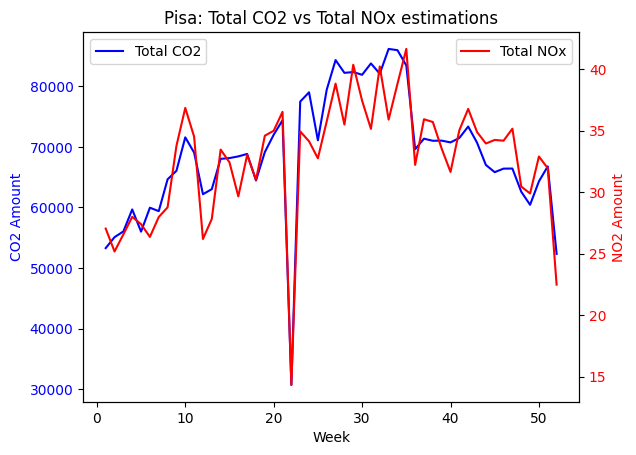

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot first time series
ax1.plot(df_sorted_total.week, df_sorted_total['CO_2'], 'b-', label='Total CO2')
ax1.set_xlabel('Week')
ax1.set_ylabel('CO2 Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the second series
ax2 = ax1.twinx()
ax2.plot(df_sorted_total.week, df_sorted_total['NO_x'], 'r-', label='Total NOx')
ax2.set_ylabel('NO2 Amount', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Pisa: Total CO2 vs Total NOx estimations')

# Show plot
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient between Series1 and Series2
correlation = df_sorted_total['NO_x'].corr(df_sorted_total['CO_2'])

# Display the result
print(f'Correlation coefficient between Model Estimations and Sensor Data: {correlation}')

Correlation coefficient between Model Estimations and Sensor Data: 0.9513585238059895


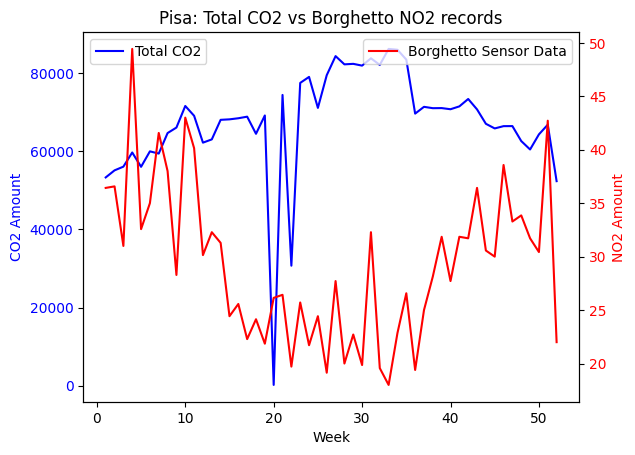

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots()

# Plot first time series
ax1.plot(df_sorted_total.week, df_sorted_total['CO_2'], 'b-', label='Total CO2')
ax1.set_xlabel('Week')
ax1.set_ylabel('CO2 Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the second series
ax2 = ax1.twinx()
ax2.plot(weekly_no2_borghetto.week, weekly_no2_borghetto['no2'], 'r-', label='Borghetto Sensor Data')
ax2.set_ylabel('NO2 Amount', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add title
plt.title('Pisa: Total CO2 vs Borghetto NO2 records')

# Show plot
plt.show()

# Map full network edges to simple map

In [ ]:
# Step 1: Load the vector dataset
city = 'Pisa'
input_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/'

df_vectors = pd.read_csv(input_path+'{}_embs_n_co2m.csv'.format(city.lower()))
df_vectors.head()

start_point   end_point         0         1         2         3         4  \
0   7257369708    31770729 -0.085884 -0.087289 -0.037153  0.067630  0.089840   
1     33681447  3044082602 -0.174782 -0.116663 -0.037823 -0.018866  0.074035   
2   3044082602  6957424170 -0.174141 -0.119883 -0.048034 -0.013717  0.076632   
3   6957424170  9986411817 -0.172700 -0.123810 -0.050842 -0.021721  0.074192   
4    213417023  9986411817 -0.155766 -0.135295 -0.046111 -0.027812  0.054545   

          5         6         7  ...       120       121       122       123  \
0 -0.091964 -0.003145  0.042195  ...  0.089255  0.213750  0.037217  0.115180   
1 -0.188407  0.017751  0.032223  ...  0.122307  0.049588 -0.016470  0.024147   
2 -0.188297  0.018823  0.021589  ...  0.116836  0.076877 -0.019096  0.043848   
3 -0.188648  0.024317  0.011438  ...  0.116804  0.086991 -0.026388  0.049518   
4 -0.173187  0.011500  0.023527  ...  0.111354  0.101505 -0.030091  0.046298   

        124       125       126       127                    road_link  \
0  0.099578 -0.016069  0.051196 -0.063270    (7257369708, 31770729, 0)   
1  0.039688 -0.074441 -0.149756 -0.001419    (33681447, 3044082602, 0)   
2  0.037676 -0.073209 -0.142323  0.000314  (3044082602, 6957424170, 0)   
3  0.028264 -0.078169 -0.146078  0.004928  (6957424170, 9986411817, 0)   
4  0.032838 -0.069481 -0.149988  0.012977   (213417023, 9986411817, 0)   

     CO_2/m  
0  0.266387  
1  0.529803  
2  0.239792  
3  0.190269  
4  0.351395  

[5 rows x 132 columns]

In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

# Step 2: Load the full network for Pisa, Italy (detailed network)
place_name = "Pisa, Pisa, Italy"  # Define the location as Pisa, Italy
G_full = ox.graph_from_place(place_name, simplify=False, retain_all=False, network_type='drive_service')

In [ ]:
gdf_full = ox.graph_to_gdfs(G_full, edges=True, nodes=False)

# Step 3: Ensure both GeoDataFrames are in the same CRS
gdf_full = gdf_full.to_crs(epsg=32632)  # UTM Zone 32N for Pisa

gdf_full['road_link'] = gdf_full.index
gdf_full = gdf_full.reset_index()
gdf_full = gdf_full.rename(columns={'u': 'start_point', 'v':'end_point'})
gdf_full = gdf_full[['start_point', 'end_point', 'key', 'length', 'oneway', 'lanes', 'maxspeed', 'geometry']]

print(len(gdf_full))
gdf_full.head(1)

51451


start_point   end_point  key  length  oneway lanes maxspeed  \
0      8437272  7756825242    0   42.43    True     2      130   

                                            geometry  
0  LINESTRING (608807.782 4843053.828, 608803.628...

In [ ]:
# Step 4: Merge vector data with the full network GeoDataFrame based on 'road_link'
# 'road_link' is the identifier here (start_point, end_point, key)
# Merge vector data with full network based on segment ID
merged_data = gdf_full.merge(df_vectors, on=['start_point', 'end_point'], how='inner')
print(len(merged_data))
merged_data.head(1)

# Step 5: Ensure `merged_data` is still a GeoDataFrame
merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Step 6: Create a spatial index on the simplified GeoDataFrame for faster spatial queries
# gdf_simplified.sindex

29001


In [ ]:
# Step 5: Load the simplified network for Pisa, Italy
G_simplified = ox.graph_from_place(place_name, network_type='drive_service', retain_all=False, simplify=True)
gdf_simplified = ox.graph_to_gdfs(G_simplified, edges=True, nodes=False)
# Step 6: Ensure the simplified GeoDataFrame is in the same CRS
gdf_simplified = gdf_simplified.to_crs(epsg=32632)  # UTM Zone 32N for Pisa

gdf_simplified['road_link'] = gdf_simplified.index
gdf_simplified = gdf_simplified.reset_index()
gdf_simplified = gdf_simplified.rename(columns={'u': 'start_point', 'v':'end_point'})
gdf_simplified = gdf_simplified[['start_point', 'end_point', 'key', 'length', 'oneway', 'lanes', 'maxspeed', 'geometry']]

print(len(gdf_simplified))
gdf_simplified.head(1)

12936


start_point  end_point  key   length  oneway lanes maxspeed  \
0      8437288  346235886    0  768.388    True     2      NaN   

                                            geometry  
0  LINESTRING (609472.166 4830319.036, 609466.063...

In [ ]:
# Step 7: Create a dictionary to hold the aggregated vectors for each simplified segment
simplified_vectors = {}

# Step 8: For each full road segment with vectors, find its corresponding simplified segment
for i, full_seg in merged_data.iterrows():
    # Find simplified segments that intersect with this full road segment
    matches = gdf_simplified[gdf_simplified.intersects(full_seg.geometry)]

    # For each matched simplified segment, aggregate vectors (columns 0 to 127)
    for j, match in matches.iterrows():
        match_id = (match['start_point'], match['end_point'], match['key'])  # Unique identifier for simplified segment

        # Initialize if not already present
        if match_id not in simplified_vectors:
            simplified_vectors[match_id] = []

        # Append the vector values (columns 0 to 127) from the full segment
        vector_values = full_seg.iloc[merged_data.columns.get_loc('0'):merged_data.columns.get_loc('127')+1].values  # Grab columns 0-127
        simplified_vectors[match_id].append(vector_values)

# Step 7: Convert the aggregated vectors into a DataFrame
# Aggregate the vectors by computing the average of each vector component
final_vectors = {}

for match_id, vector_list in simplified_vectors.items():
    # Convert the list of lists into a NumPy array for easier aggregation
    vector_array = np.array(vector_list)

    # Compute the average vector for each simplified segment
    aggregated_vector = vector_array.mean(axis=0)  # Compute the mean across rows (i.e., for each vector component)

    # Store the result
    final_vectors[match_id] = aggregated_vector

# Convert the dictionary to a DataFrame
vectors_df = pd.DataFrame.from_dict(final_vectors, orient='index')
vectors_df.reset_index(inplace=True)

# Rename the columns (optional, just for clarity)
vectors_df.columns = ['simplified_segment_id'] + [f'vector_{i}' for i in range(128)]

# Step 8: Merge the aggregated vectors back with the simplified GeoDataFrame (gdf_simplified)
# First, create an identifier in gdf_simplified to match against 'simplified_segment_id'
gdf_simplified['simplified_segment_id'] = list(zip(gdf_simplified['start_point'], gdf_simplified['end_point'], gdf_simplified['key']))


In [ ]:
# Now, merge the aggregated vector DataFrame with gdf_simplified
result = gdf_simplified.merge(vectors_df, on='simplified_segment_id', how='inner')

print(len(result))
result.head()

12043


start_point   end_point  key   length  oneway   lanes maxspeed  \
0      8437288   346235886    0  768.388    True       2      NaN   
1      8437288   367740049    0  745.184    True       2      130   
2     31680764   302338593    0  227.699    True  [2, 3]       50   
3     31680777  1117292464    0  162.006    True       2      NaN   
4     31680777  3488541943    0   65.969    True       2       50   

                                            geometry  \
0  LINESTRING (609472.166 4830319.036, 609466.063...   
1  LINESTRING (609472.166 4830319.036, 609476.784...   
2  LINESTRING (615655.163 4838686.104, 615650.784...   
3  LINESTRING (615687.467 4840295.679, 615699.950...   
4  LINESTRING (615687.467 4840295.679, 615689.088...   

       simplified_segment_id  vector_0  ...  vector_118  vector_119  \
0    (8437288, 346235886, 0) -0.020982  ...    0.021932   -0.156169   
1    (8437288, 367740049, 0) -0.057252  ...    0.068240   -0.164502   
2   (31680764, 302338593, 0)  0.042165  ...    0.096613    0.028628   
3  (31680777, 1117292464, 0) -0.151568  ...    0.122265    0.113445   
4  (31680777, 3488541943, 0) -0.124054  ...    0.106122    0.117674   

   vector_120  vector_121  vector_122  vector_123  vector_124  vector_125  \
0    0.120895    0.138591    0.017300    0.151953    0.009977   -0.160450   
1    0.103005    0.116652    0.018801    0.135922    0.026254   -0.153106   
2    0.019544    0.050344    0.041087    0.138578    0.021367   -0.029848   
3   -0.115014    0.065443    0.014771    0.051441   -0.018294   -0.042812   
4   -0.119080    0.068734    0.021115    0.071824   -0.030845   -0.032968   

   vector_126  vector_127  
0   -0.091948    0.039844  
1   -0.104921    0.030517  
2    0.109002    0.032280  
3    0.137723    0.002665  
4    0.154654   -0.006603  

[5 rows x 137 columns]

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/sarn/'
result.to_csv(output_path+'{}_simple_directed_network_embeddings.csv'.format(city.lower()), index=False)

In [ ]:
result

start_point   end_point  key   length  oneway   lanes maxspeed  \
0          8437288   346235886    0  768.388    True       2      NaN   
1          8437288   367740049    0  745.184    True       2      130   
2         31680764   302338593    0  227.699    True  [2, 3]       50   
3         31680777  1117292464    0  162.006    True       2      NaN   
4         31680777  3488541943    0   65.969    True       2       50   
...            ...         ...  ...      ...     ...     ...      ...   
12038  12156231466  3815498992    0   41.652    True       1      NaN   
12039  12201186151   213791384    0  147.193   False     NaN      NaN   
12040  12201186151  1676252636    0   25.367   False     NaN      NaN   
12041  12204016415   245398269    0   12.636   False       2       50   
12042  12204016415  6782431271    0  116.164   False       2       50   

                                                geometry  \
0      LINESTRING (609472.166 4830319.036, 609466.063...   
1      LINESTRING (609472.166 4830319.036, 609476.784...   
2      LINESTRING (615655.163 4838686.104, 615650.784...   
3      LINESTRING (615687.467 4840295.679, 615699.950...   
4      LINESTRING (615687.467 4840295.679, 615689.088...   
...                                                  ...   
12038  LINESTRING (614693.094 4840790.274, 614697.100...   
12039  LINESTRING (611728.042 4841863.669, 611725.949...   
12040  LINESTRING (611728.042 4841863.669, 611732.712...   
12041  LINESTRING (614114.636 4839893.518, 614102.554...   
12042  LINESTRING (614114.636 4839893.518, 614130.031...   

              simplified_segment_id  vector_0  ...  vector_118  vector_119  \
0           (8437288, 346235886, 0) -0.020982  ...    0.021932   -0.156169   
1           (8437288, 367740049, 0) -0.057252  ...    0.068240   -0.164502   
2          (31680764, 302338593, 0)  0.042165  ...    0.096613    0.028628   
3         (31680777, 1117292464, 0) -0.151568  ...    0.122265    0.113445   
4         (31680777, 3488541943, 0) -0.124054  ...    0.106122    0.117674   
...                             ...       ...  ...         ...         ...   
12038  (12156231466, 3815498992, 0) -0.101195  ...   -0.043031   -0.066736   
12039   (12201186151, 213791384, 0) -0.018052  ...   -0.003352   -0.168652   
12040  (12201186151, 1676252636, 0) -0.004332  ...   -0.009469   -0.183830   
12041   (12204016415, 245398269, 0) -0.141749  ...    0.090789    0.073619   
12042  (12204016415, 6782431271, 0) -0.091539  ...    0.079232    0.057539   

       vector_120  vector_121  vector_122  vector_123  vector_124  vector_125  \
0        0.120895    0.138591    0.017300    0.151953    0.009977   -0.160450   
1        0.103005    0.116652    0.018801    0.135922    0.026254   -0.153106   
2        0.019544    0.050344    0.041087    0.138578    0.021367   -0.029848   
3       -0.115014    0.065443    0.014771    0.051441   -0.018294   -0.042812   
4       -0.119080    0.068734    0.021115    0.071824   -0.030845   -0.032968   
...           ...         ...         ...         ...         ...         ...   
12038    0.097407   -0.130478   -0.035907   -0.026518    0.107462   -0.137717   
12039    0.049456   -0.009600   -0.079224   -0.039020   -0.076448    0.121514   
12040    0.069986   -0.011846   -0.070491   -0.045555   -0.097341    0.117125   
12041   -0.067968   -0.000787    0.067559    0.096434   -0.059938   -0.054635   
12042   -0.097765   -0.023929    0.060942    0.115895   -0.091905   -0.076389   

       vector_126  vector_127  
0       -0.091948    0.039844  
1       -0.104921    0.030517  
2        0.109002    0.032280  
3        0.137723    0.002665  
4        0.154654   -0.006603  
...           ...         ...  
12038   -0.040757   -0.027210  
12039   -0.061913   -0.014967  
12040   -0.124620   -0.029918  
12041    0.043234    0.006627  
12042    0.032402    0.091699  

[12043 rows x 137 columns]